In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

def histParam_kin(p_names,names,data,filename):
    for name in p_names:
        var_names = ["px","py","pz"]
        data_mom = data[names == name,5:]
        for j, var_name in enumerate(var_names):
            plt.figure()
            plt.hist(data_mom[:,j], bins=100)
            plt.xlabel(f'{var_name} (keV)')
            plt.ylabel('Counts')
            #plt.yscale('log')
            plt.title(name)
            plt.savefig(f'plots/{filename[6:-4]}_{name}_{var_name}.pdf')
        data_E = data[names == name,4]
        data_v = data_mom/data_E[:,np.newaxis]
        var_names2 = ["vx","vy","vz"]
        for j, var_name in enumerate(var_names2):
            plt.figure()
            plt.hist(data_v[:,j], bins=100)
            plt.xlabel(f'{var_name} (c)')
            plt.ylabel('Counts')
            #plt.yscale('log')
            plt.title(name)
            plt.savefig(f'plots/{filename[6:-4]}_{name}_{var_name}.pdf')
        if name in ['e+','e-']:
            data_dir = data_v/np.tile(np.linalg.norm(data_v,axis=1),(3,1)).T
            var_names3 = ["x_dir","y_dir","z_dir"]
            for j, var_name in enumerate(var_names3):
                plt.figure()
                plt.hist(data_dir[:,j], bins=100)
                plt.xlabel(f'{var_name}')
                plt.ylabel('Counts')
                #plt.yscale('log')
                plt.title(name)
                plt.savefig(f'plots/{filename[6:-4]}_{name}_{var_name}.pdf')

    chargedl_data = data[np.logical_or(names == 'e+',names == 'e-'),5:8]
    neutrino_data = data[np.logical_or(names == 'enu',names == 'enubar'),5:8]
    chargedl_data = chargedl_data/np.tile(np.linalg.norm(chargedl_data,axis=1),(3,1)).T
    neutrino_data = neutrino_data/np.tile(np.linalg.norm(neutrino_data,axis=1),(3,1)).T
    angle = np.sum(chargedl_data*neutrino_data,axis=1)
    plt.figure()
    plt.hist(angle, bins=100)
    plt.xlabel('cos(theta_{e,enu})')
    plt.ylabel('Counts')
    #plt.yscale('log')
    plt.savefig(f'plots/{filename[6:-4]}_angular_correlation_enu_e.pdf')
    
def phase_space(W, W0, **kwargs):
    """Phase space

    :param W: Electron energy in iunits of me c^2
    :param W0: Electron endpoint energy in units of me c^2

    """
    return np.sqrt(W**2-1)*(W-W0)**2*W

def fermi_function(W, Z, A, **kwargs):
    """Fermi Function

    :param Z: Proton number of the final nuclear state
    :param W: Electron energy in units of me c^2
    :param A: Mass number of the final (and initial) state
    """
    f = 1
    ALPHA = 0.0072973525643
    
    # R Nuclear radius in units of the electron Compton wavelength

    R = (1.15+1.8*A**(-2./3.)-1.2*A**(-4./3.))*A**(1./3.)*1e-15;
    R *= np.sqrt(5/3)/3.86159268e-13 
    
    if Z == 0:
        return f

    g = np.sqrt(1-(ALPHA*Z)**2)
    p = np.sqrt(W**2-1)
    y = -ALPHA*Z*W/p #beta+
    
    #We use the Fermi function with 2(1+gamma), consistent with CRADLE
    f = (2*(g+1)
            *np.power(2*p*R, 2*(g-1))
            *np.exp(np.pi*y)
            *(np.abs(sp.special.gamma(g+1.j*y))/(sp.special.gamma(1+2*g)))**2)

    return f

def minmax_f_plot(iFile,oFile=None):
    data_minmaxf = np.loadtxt(iFile)
    data_beta = np.sqrt(1-mass_e**2/data_minmaxf[:,0]**2)
    data_inversegamma = mass_e/data_minmaxf[:,0]
    fig, axs = plt.subplots(1,3,sharey=True,figsize=(12,5))
    axs[0].set_ylabel("F",size = 16)
    axs[0].plot(data_minmaxf[:,0],data_minmaxf[:,1],label="Maximum")
    axs[0].plot(data_minmaxf[:,0],data_minmaxf[:,2],label="Minimum")
    axs[0].plot(data_minmaxf[:,0],np.zeros_like(data_minmaxf[:,0]),color="#d0d0d080",linestyle="dashed")
    axs[0].legend()
    axs[0].set_xlabel("E (keV)",size = 16)
    axs[1].plot(data_beta,data_minmaxf[:,1],label="Maximum")
    axs[1].plot(data_beta,data_minmaxf[:,2],label="Minimum")
    axs[1].plot(data_beta,np.zeros_like(data_beta),color="#d0d0d080",linestyle="dashed")
    axs[1].legend()
    axs[1].set_xlabel("$\\beta_e$",size = 16)
    axs[2].plot(data_inversegamma,data_minmaxf[:,1],label="Maximum")
    axs[2].plot(data_inversegamma,data_minmaxf[:,2],label="Minimum")
    axs[2].plot(data_inversegamma,np.zeros_like(data_inversegamma),color="#d0d0d080",linestyle="dashed")
    axs[2].legend()
    axs[2].set_xlabel("m_e/E",size = 16)
    for ax in axs:
        ax.tick_params('both',labelsize = 12)
    if oFile != None:
        fig.savefig(oFile)
    plt.show()

In [19]:
mass_e = 510.9989461

class data_analysis:
    def __init__(self,fileName,betaType):
        data = np.genfromtxt(fileName, dtype=str)
        self.names = data[:,2]
        self.data = data[:, np.arange(data.shape[1]) != 2].astype(dtype=np.float32)
        self.events = data[:,0].astype(int)
        self.data[np.isnan(self.data)] = 0
        self.c_lepton = "e-" if (betaType == 1) else "e+"
        self.neutrino = "enubar" if (betaType == 1) else "enu"
    def __len__(self):
        return self.data.shape[0]
    def event_mask(self):
        pass
    def kinematical_data(self):
        #energy
        self.data_E_el = self.data[self.names == self.c_lepton ,4]
        
        #directions
        self.data_dir_el = self.data[self.names == self.c_lepton ,5:8]
        self.data_dir_el /= np.tile(np.linalg.norm(self.data_dir_el,axis=1),(3,1)).T
        self.data_dir_enu = self.data[self.names == self.neutrino ,5:8]
        self.data_dir_enu /= np.tile(np.linalg.norm(self.data_dir_enu,axis=1),(3,1)).T
        
        #angle between e and enu
        self.data_angle_elenu = np.sum(self.data_dir_el*self.data_dir_enu,axis=1)
     
    def kinematical_data_ref(self,polDir = np.array([0,0,1])):
        #angles in reference to polDir
        z_cross_elenu = np.sum(np.cross(self.data_dir_el,self.data_dir_enu)*polDir[np.newaxis,:],axis=1)
        self.cos_el = np.sum(self.data_dir_el*polDir[np.newaxis,:],axis=1)
        self.cos_enu = np.sum(self.data_dir_enu*polDir[np.newaxis,:],axis=1)
        sin_el = np.sqrt(1-self.cos_el**2)
        sin_enu = np.sqrt(1-self.cos_enu**2)
        data_cosphi = (self.data_angle_elenu-self.cos_el*self.cos_enu)
        data_sinphi = z_cross_elenu
        self.data_phi = np.arctan2(data_sinphi,data_cosphi)
    def plot_E_dist(self):
        print(self.data_E_el.size)
        plt.hist(self.data_E_el, bins=100)
        plt.xlabel('E')
        plt.ylabel('Counts')
        #plt.yscale('log')
        plt.title("e-")
        plt.show()
    def theoretical_dist(self, coeffs,numComp=False,bins=100):
        #note a, c, A, B and D need to be functions dependent on energy
        E_hist, E_bin = np.histogram(self.data_E_el, bins= 200)
        E_vals = (E_bin[1:]+E_bin[:-1])/2
        N = self.data_E_el.size

        z_el = np.linspace(-1,1,201)
        z_nu = z_el.copy()
        z_elenu = z_el.copy()
        phi = np.linspace(-np.pi,np.pi,501)

        self.z_el = z_el
        self.z_nu = z_nu
        self.z_elenu = z_elenu
        self.phi = phi
        
        self.z_el_theory = np.zeros_like(z_el)
        self.z_nu_theory = np.zeros_like(z_nu)
        self.z_elenu_theory = np.zeros_like(z_elenu)
        self.phi_theory = np.zeros_like(phi)

        for E, dist in zip(E_vals, E_hist):
            a, b, c, A, B, D = coeffs(E)
            beta = np.sqrt(1-mass_e**2/E**2)
            self.z_el_theory += dist/N*(1+b*mass_e/E+A*beta*z_el)/2/(1+b*mass_e/E) 
            self.z_elenu_theory += dist/N*(1+b*mass_e/E+a*beta*z_elenu)/2/(1+b*mass_e/E)
            self.z_nu_theory += dist/N*(1+b*mass_e/E+B*z_nu)/2/(1+b*mass_e/E)
            phi_theory_E = dist/N*(1 + b*mass_e/E + beta*((a+c/3)*np.cos(phi)+D*np.sin(phi))*(np.pi/4)**2)
            self.phi_theory += phi_theory_E/2/np.pi/(1+b*mass_e/E)
            
        if numComp:
            cos_el_hist, cos_el_bins = np.histogram(self.cos_el,bins=bins)
            cos_enu_hist, cos_enu_bins = np.histogram(self.cos_enu,bins=bins)
            cos_elenu_hist, cos_elenu_bins = np.histogram(self.data_angle_elenu,bins=bins)
            phi_hist, phi_bins = np.histogram(self.data_phi,bins=bins)
            
            self.cos_el_bins = (cos_el_bins[1:]+cos_el_bins[:-1])/2
            self.cos_enu_bins = (cos_enu_bins[1:]+cos_enu_bins[:-1])/2
            self.cos_elenu_bins = (cos_elenu_bins[1:]+cos_elenu_bins[:-1])/2
            self.phi_bins = (phi_bins[1:]+phi_bins[:-1])/2
            
            cos_el_theory = np.zeros_like(self.cos_el_bins)
            cos_enu_theory = np.zeros_like(self.cos_enu_bins)
            cos_elenu_theory = np.zeros_like(self.cos_elenu_bins)
            cphi_theory = np.zeros_like(self.phi_bins)
            
            for E, dist in zip(E_vals, E_hist):
                a, b, c, A, B, D = coeffs(E)
                beta = np.sqrt(1-mass_e**2/E**2)
                cos_el_theory += dist/bins*(1+b*mass_e/E+A*beta*self.cos_el_bins)/(1+b*mass_e/E) 
                cos_elenu_theory += dist/bins*(1+b*mass_e/E+a*beta*self.cos_elenu_bins)/(1+b*mass_e/E)
                cos_enu_theory += dist/bins*(1+b*mass_e/E+B*self.cos_enu_bins)/(1+b*mass_e/E)
                phi_theory_E = 1 + b*mass_e/E + beta*(np.pi/4)**2*((a+c/3)*np.cos(self.phi_bins)+
                                                                   D*np.sin(self.phi_bins))
                cphi_theory += dist/bins*phi_theory_E/(1+b*mass_e/E)
                           
            self.res_cos_el = (cos_el_hist-cos_el_theory)/np.sqrt(cos_el_hist)
            self.res_cos_enu = (cos_enu_hist-cos_enu_theory)/np.sqrt(cos_enu_hist)
            self.res_cos_elenu = (cos_elenu_hist-cos_elenu_theory)/np.sqrt(cos_elenu_hist)
            self.res_phi = (phi_hist-cphi_theory)/np.sqrt(phi_hist)
                                 
            self.xi2_cos_el = np.sum(self.res_cos_el**2)
            self.xi2_cos_enu = np.sum(self.res_cos_enu**2)
            self.xi2_cos_elenu = np.sum(self.res_cos_elenu**2)
            self.xi2_phi = np.sum(self.res_phi**2)
            print(self.xi2_cos_el/bins,self.xi2_cos_enu/bins,self.xi2_cos_elenu/bins,self.xi2_phi/bins)
    def theoretical_dist2(self, coeffs, numComp=False,bins=100):
        #note a, c, A, B and D need to be functions dependent on energy
        E_hist, E_bin = np.histogram(self.data_E_el, bins= 200)
        E_vals = (E_bin[1:]+E_bin[:-1])/2
        N = self.data_E_el.size

        z_el = np.linspace(-1,1,201)
        z_nu = z_el.copy()
        z_elenu = z_el.copy()
        phi = np.linspace(-np.pi,np.pi,501)

        self.z_el = z_el
        self.z_nu = z_nu
        self.z_elenu = z_elenu
        self.phi = phi
        
        self.z_el_theory2 = np.zeros_like(z_el)
        self.z_nu_theory2 = np.zeros_like(z_nu)
        self.z_elenu_theory2 = np.zeros_like(z_elenu)
        self.phi_theory2 = np.zeros_like(phi)

        for E, dist in zip(E_vals, E_hist):
            a, b, c, A, B, D = coeffs(E)
            beta = np.sqrt(1-mass_e**2/E**2)
            self.z_el_theory2 += dist/N*(1+b*mass_e/E+A*beta*z_el)/2/(1+b*mass_e/E) 
            self.z_elenu_theory2 += dist/N*(1+b*mass_e/E+a*beta*z_elenu)/2/(1+b*mass_e/E)
            self.z_nu_theory2 += dist/N*(1+b*mass_e/E+B*z_nu)/2/(1+b*mass_e/E)
            phi_theory_E = dist/N*(1 + b*mass_e/E + beta*((a+c/3)*np.cos(phi)+D*np.sin(phi))*(np.pi/4)**2)
            self.phi_theory2 += phi_theory_E/2/np.pi/(1+b*mass_e/E)
        
        if numComp:
            cos_el_hist, cos_el_bins = np.histogram(self.cos_el,bins=bins)
            cos_enu_hist, cos_enu_bins = np.histogram(self.cos_enu,bins=bins)
            cos_elenu_hist, cos_elenu_bins = np.histogram(self.data_angle_elenu,bins=bins)
            phi_hist, phi_bins = np.histogram(self.data_phi,bins=bins)
            
            self.cos_el_bins = (cos_el_bins[1:]+cos_el_bins[:-1])/2
            self.cos_enu_bins = (cos_enu_bins[1:]+cos_enu_bins[:-1])/2
            self.cos_elenu_bins = (cos_elenu_bins[1:]+cos_elenu_bins[:-1])/2
            self.phi_bins = (phi_bins[1:]+phi_bins[:-1])/2
            
            cos_el_theory = np.zeros_like(self.cos_el_bins)
            cos_enu_theory = np.zeros_like(self.cos_enu_bins)
            cos_elenu_theory = np.zeros_like(self.cos_elenu_bins)
            cphi_theory = np.zeros_like(self.phi_bins)
            
            for E, dist in zip(E_vals, E_hist):
                a, b, c, A, B, D = coeffs(E)
                beta = np.sqrt(1-mass_e**2/E**2)
                cos_el_theory += dist/bins*(1+b*mass_e/E+A*beta*self.cos_el_bins)/(1+b*mass_e/E) 
                cos_elenu_theory += dist/bins*(1+b*mass_e/E+a*beta*self.cos_elenu_bins)/(1+b*mass_e/E)
                cos_enu_theory += dist/bins*(1+b*mass_e/E+B*self.cos_enu_bins)/(1+b*mass_e/E)
                phi_theory_E = 1 + b*mass_e/E + beta*(np.pi/4)**2*((a+c/3)*np.cos(self.phi_bins)+
                                                                   D*np.sin(self.phi_bins))
                cphi_theory += dist/bins*phi_theory_E/(1+b*mass_e/E)
                           
            self.res_cos_el_2 = (cos_el_hist-cos_el_theory)/np.sqrt(cos_el_hist)
            self.res_cos_en_2 = (cos_enu_hist-cos_enu_theory)/np.sqrt(cos_enu_hist)
            self.res_cos_elenu_2 = (cos_elenu_hist-cos_elenu_theory)/np.sqrt(cos_elenu_hist)
            self.res_phi_2 = (phi_hist-cphi_theory)/np.sqrt(phi_hist)
                                 
            self.xi2_cos_el_2 = np.sum(self.res_cos_el**2)
            self.xi2_cos_enu_2 = np.sum(self.res_cos_enu**2)
            self.xi2_cos_elenu_2 = np.sum(self.res_cos_elenu**2)
            self.xi2_phi_2 = np.sum(self.res_phi**2)
            print(self.xi2_cos_el_2/bins,self.xi2_cos_enu_2/bins,self.xi2_cos_elenu_2/bins,self.xi2_phi_2/bins)

    def plot_kin_histograms(self,fileName):
        p_names = (set(self.names)&{'e+','e-','enubar','enu'})
        histParam_kin(p_names,self.names,self.data,fileName)
        plt.show()
    def plot_distribution_histograms(self,showTheory=True,compareTheory=False,bins=100,fileName=None,lwidth=2):
        fig, axs = plt.subplots(2,2,figsize=(10,7))
        for ax in axs.flatten():
            ax.tick_params('both',labelsize = 12)
        axs[0,0].hist(self.cos_el, bins=bins,density=True) #z component
        if showTheory:
            axs[0,0].plot(self.z_el,self.z_el_theory,linewidth = lwidth)
            if compareTheory:
                axs[0,0].plot(self.z_el,self.z_el_theory2,linewidth = lwidth)
        axs[0,0].set_xlabel("$\\cos \\theta_{e,j}$",size = 16)
        axs[0,0].set_ylabel('pdf',size = 16)
        #plt.yscale('log')
        axs[1,0].hist(self.cos_enu, bins=bins,density=True) #z component
        if showTheory: 
            axs[1,0].plot(self.z_nu,self.z_nu_theory,linewidth = lwidth)
            if compareTheory:
                axs[1,0].plot(self.z_nu,self.z_nu_theory2,linewidth = lwidth)
        axs[1,0].set_xlabel("$\\cos \\theta_{\\nu,j}$",size = 16)
        axs[1,0].set_ylabel('pdf',size = 16)
        #plt.yscale('log')
        axs[0,1].hist(self.data_angle_elenu, bins=bins,density=True)
        if showTheory: 
            axs[0,1].plot(self.z_elenu,self.z_elenu_theory,linewidth = lwidth)
            if compareTheory:
                axs[0,1].plot(self.z_elenu,self.z_elenu_theory2,linewidth = lwidth)
        axs[0,1].set_xlabel("$\\cos \\theta_{e,\\nu}$",size = 16)
        axs[0,1].set_ylabel('pdf',size = 16)
        #plt.yscale('log')
        axs[1,1].hist(self.data_phi, bins=bins,density=True)
        if showTheory: 
            axs[1,1].plot(self.phi,self.phi_theory,linewidth = lwidth)
            if compareTheory:
                axs[1,1].plot(self.phi,self.phi_theory2,linewidth = lwidth)
        axs[1,1].set_xlabel("$\\phi$",size = 16)
        axs[1,1].set_ylabel('pdf',size = 16)
        #plt.yscale('log')
        fig.tight_layout()
        if fileName != None:
            fig.savefig(f"plots/{fileName}.png")
        plt.show()
    def plot_residuals(self,fileName=None):
        fig, axs = plt.subplots(2,2,figsize=(10,7))
        for ax in axs.flatten():
            ax.tick_params('both',labelsize = 14)
        axs[0,0].plot(self.cos_el_bins,self.res_cos_el,"x") #z component
        axs[0,0].set_xlabel("$\\cos \\theta_{e,j}$",size = 16)
        axs[0,0].set_ylabel('Residual',size = 16)
        #plt.yscale('log')
        axs[1,0].plot(self.cos_enu_bins,self.res_cos_enu,"x") #z component
        axs[1,0].set_xlabel("$\\cos \\theta_{\\nu,j}$",size = 16)
        axs[1,0].set_ylabel('Residual',size = 16)
        #plt.yscale('log')
        axs[0,1].plot(self.cos_elenu_bins,self.res_cos_elenu,"x") #z component
        axs[0,1].set_xlabel("$\\cos \\theta_{e,\\nu}$",size = 16)
        axs[0,1].set_ylabel('Residual',size = 16)
        #plt.yscale('log')
        axs[1,1].plot(self.phi_bins,self.res_phi,"x") #z component
        axs[1,1].set_xlabel("$\\phi$",size = 16)
        axs[1,1].set_ylabel('Residual',size = 16)
        #plt.yscale('log')
        fig.tight_layout()
        if fileName != None:
            fig.savefig(f"plots/{fileName}.png")
        plt.show()
    def plot_2dhist(self,bins=20):
        plt.hist2d(self.cos_el,self.cos_enu,bins=bins)
        plt.colorbar()
        plt.xlabel("$\\cos \\theta_{e,j}$")
        plt.ylabel("$\\cos \\theta_{\\nu,j}$")
        plt.show()
        plt.hist2d(self.cos_el,self.data_phi,bins=bins)
        plt.colorbar()
        plt.xlabel("$\\cos \\theta_{e,j}$")
        plt.ylabel("$\\phi$")
        plt.show()
        plt.hist2d(self.cos_enu,self.data_phi,bins=bins)
        plt.colorbar()
        plt.xlabel("$\\cos \\theta_{\\nu,j}$")
        plt.ylabel("$\\phi$")
        plt.show()
    def plot_residuals2(self,fileName=None):
        fig, axs = plt.subplots(2,2,figsize=(10,7))
        for ax in axs.flatten():
            ax.tick_params('both',labelsize = 14)
        axs[0,0].plot(self.cos_el_bins,self.res_cos_el_2,"x") #z component
        axs[0,0].set_xlabel("$\\cos \\theta_{e,j}$",size = 16)
        axs[0,0].set_ylabel('Residual',size = 16)
        #plt.yscale('log')
        axs[1,0].plot(self.cos_enu_bins,self.res_cos_enu_2,"x") #z component
        axs[1,0].set_xlabel("$\\cos \\theta_{\\nu,j}$",size = 16)
        axs[1,0].set_ylabel('Residual',size = 16)
        #plt.yscale('log')
        axs[0,1].plot(self.cos_elenu_bins,self.res_cos_elenu_2,"x") #z component
        axs[0,1].set_xlabel("$\\cos \\theta_{e,\\nu}$",size = 16)
        axs[0,1].set_ylabel('Residual',size = 16)
        #plt.yscale('log')
        axs[1,1].plot(self.phi_bins,self.res_phi_2,"x") #z component
        axs[1,1].set_xlabel("$\\phi$",size = 16)
        axs[1,1].set_ylabel('Residual',size = 16)
        #plt.yscale('log')
        fig.tight_layout()
        if fileName != None:
            fig.savefig(f"plots/{fileName}.png")
        plt.show()        

In [20]:
class Ca39_data_analysis(data_analysis):
    def __init__(self, fileName):
        super().__init__(fileName, -1)
    def event_mask(self):
        part_events = np.bincount(self.events)
        events_mask = np.arange(part_events.size)[part_events == 3] #39K + e+ + enu
        self.data = self.data[np.isin(self.events, events_mask),:]
        self.names = self.names[np.isin(self.events, events_mask)]
        
#calculation of <beta>
W_0 = 5502.5/mass_e + 1
E_range = np.linspace(mass_e+0.1,5502.5+mass_e,6000)
dist_E = []
av_beta = 0
av_inversegamma = 0
for E in E_range:
    W = E/mass_e
    dist = phase_space(W,W_0)*fermi_function(W,19,39)
    dist_E.append(dist)
    av_beta += dist*np.sqrt(1-1/W**2)
    av_inversegamma += dist/W
dist_E = np.array(dist_E)
av_beta /= dist_E.sum()
av_inversegamma /= dist_E.sum()

print(av_beta,av_inversegamma,av_inversegamma*19/137)


W_0 = 960.4/mass_e + 1
E_range = np.linspace(mass_e+0.1,317.06+mass_e,6000)
dist_E = []
av_beta = 0
av_inversegamma = 0
for E in E_range:
    W = E/mass_e
    dist = phase_space(W,W_0)*fermi_function(W,28,60)
    dist_E.append(dist)
    av_beta += dist*np.sqrt(1-1/W**2)
    av_inversegamma += dist/W
dist_E = np.array(dist_E)
av_beta /= dist_E.sum()
av_inversegamma /= dist_E.sum()

print(av_beta,av_inversegamma,av_inversegamma*28/137)

W_0 = 18.59/mass_e + 1
E_range = np.linspace(mass_e+1,18.59+mass_e,200)
dist_E = []
av_beta = 0
av_inversegamma = 0
for E in E_range:
    W = E/mass_e
    dist = phase_space(W,W_0)*fermi_function(W,2,3)
    dist_E.append(dist)
    av_beta += dist*np.sqrt(1-1/W**2)
    av_inversegamma += dist/W
dist_E = np.array(dist_E)
av_beta /= dist_E.sum()
av_inversegamma /= dist_E.sum()

print(av_beta,av_inversegamma,av_inversegamma*2/137)

0.9743633990210445 0.19763754420613766 0.02740958642274902
0.6829308187961138 0.7201982362555319 0.14719380011061964
0.1565393861652789 0.9867099493148297 0.014404524807515763


1.4090773734264246 1.2072986858752852 0.8400128958761789 1.1105173860985904


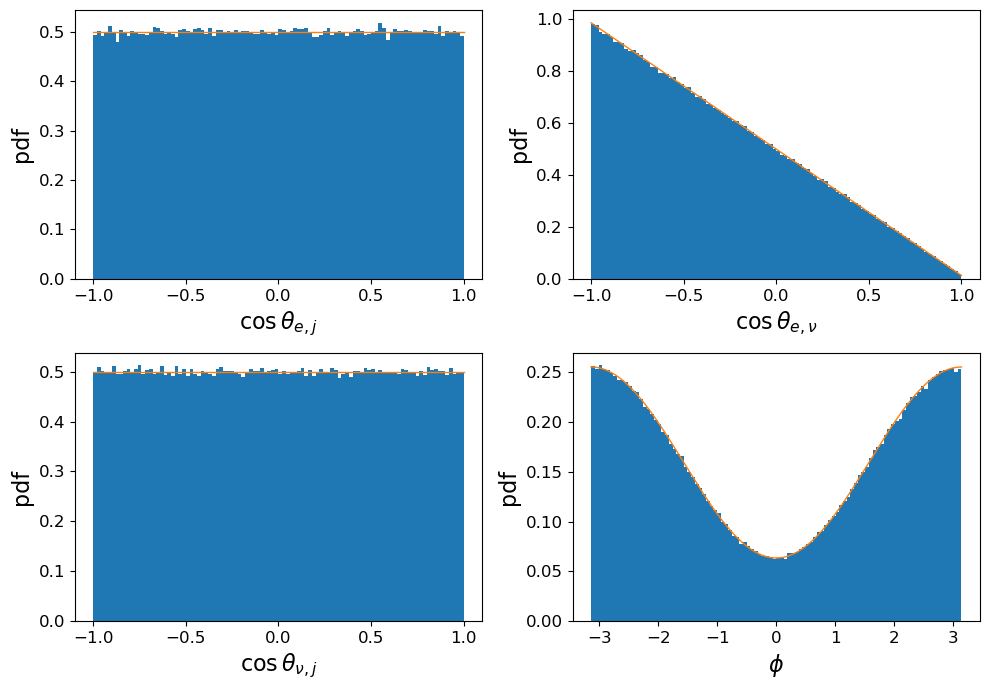

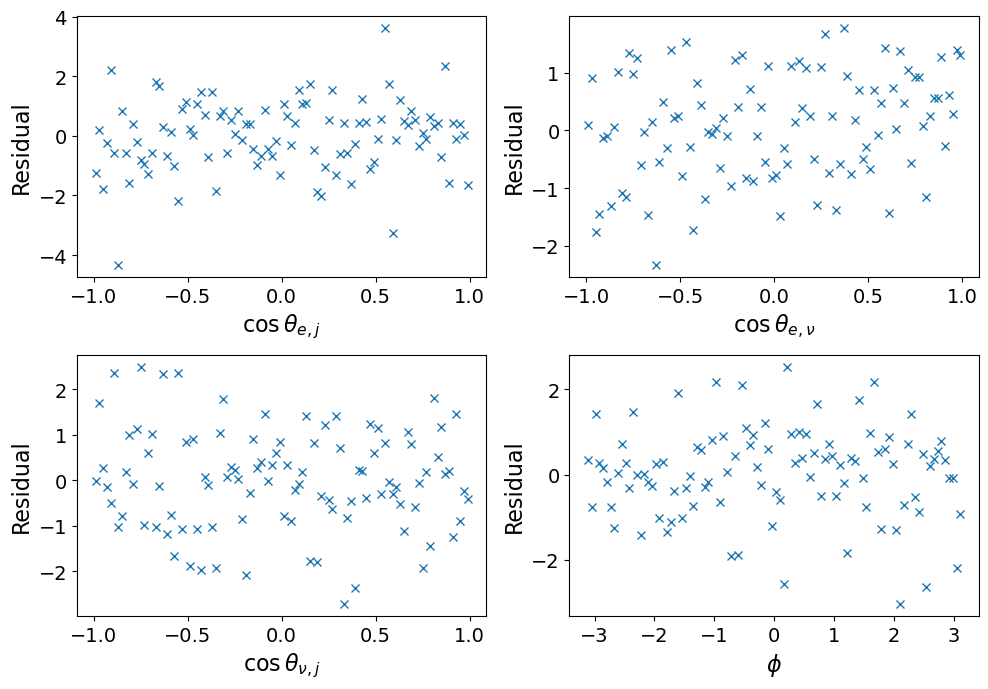

In [16]:
#cscsp

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5

def cscsp_real(E):
    xi = 2
    a = -2
    b = 0
    c = 0
    A = 0
    B = 0
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

cscspRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_cscsp_real.txt")
cscspRe_39Ca_polZpos.event_mask()
cscspRe_39Ca_polZpos.kinematical_data()
cscspRe_39Ca_polZpos.kinematical_data_ref()
cscspRe_39Ca_polZpos.theoretical_dist(cscsp_real,numComp=True)
cscspRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_cscsp_real_hist",lwidth=1)
cscspRe_39Ca_polZpos.plot_residuals(fileName="39Ca_cscsp_real_res")

0.9972420946836377 1.1091510457722473 0.9809695366795126 1.228798275928281


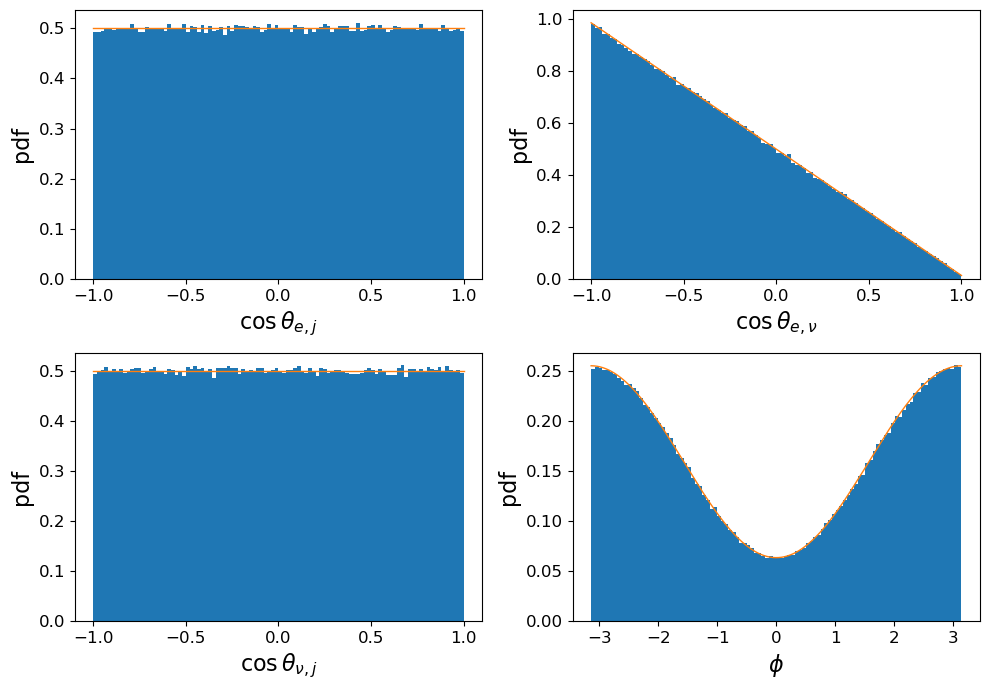

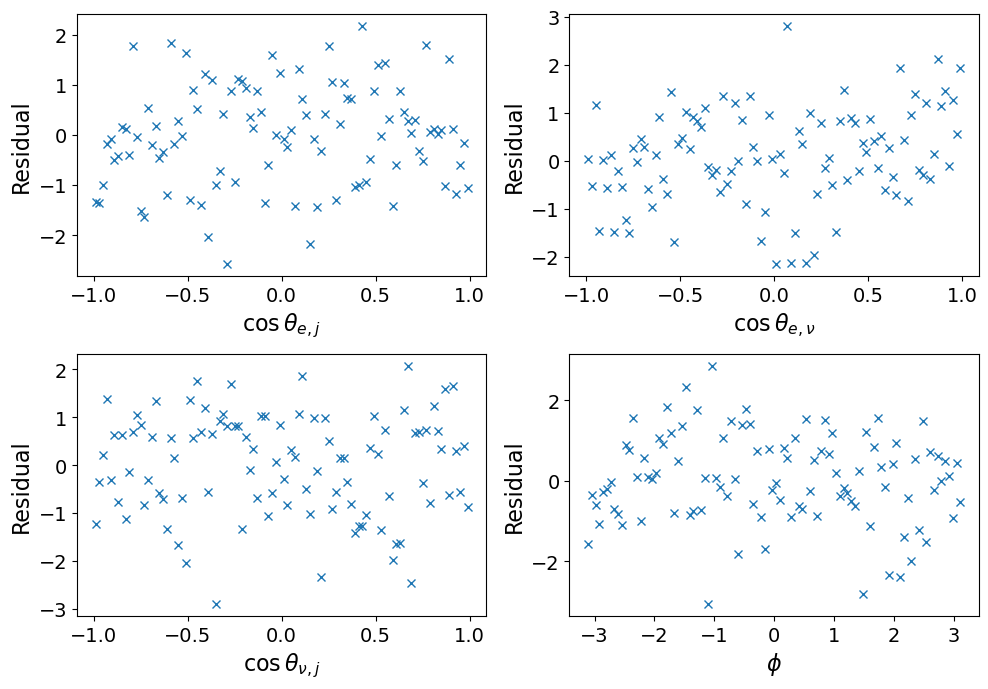

In [17]:
#cscsp

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5

def cscsp_imag(E):
    xi = 2
    a = -2
    b = 0
    c = 0
    A = 0
    B = 0
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

cscspIm_39Ca_polZpos = Ca39_data_analysis("build/39Ca_cscsp_imag.txt")
cscspIm_39Ca_polZpos.event_mask()
cscspIm_39Ca_polZpos.kinematical_data()
cscspIm_39Ca_polZpos.kinematical_data_ref()
cscspIm_39Ca_polZpos.theoretical_dist(cscsp_imag,numComp=True)
cscspIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_cscsp_imag_hist",lwidth=1)
cscspIm_39Ca_polZpos.plot_residuals(fileName="39Ca_cscsp_imag_res")

1.1172896887813697 1.2187550314588846 0.9243508926744655 1.2560568682159512


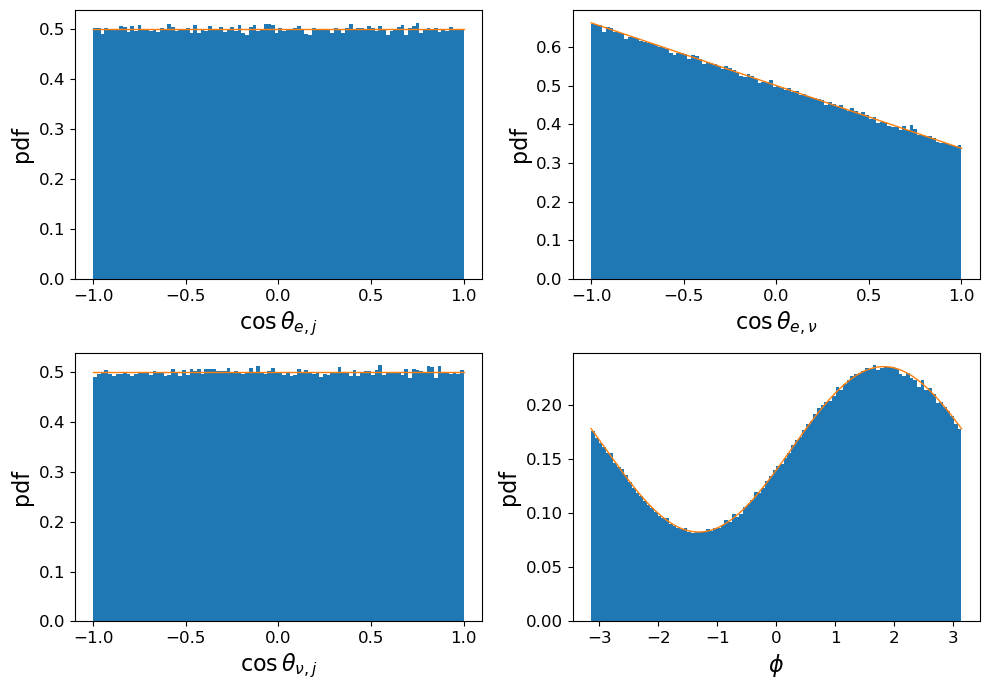

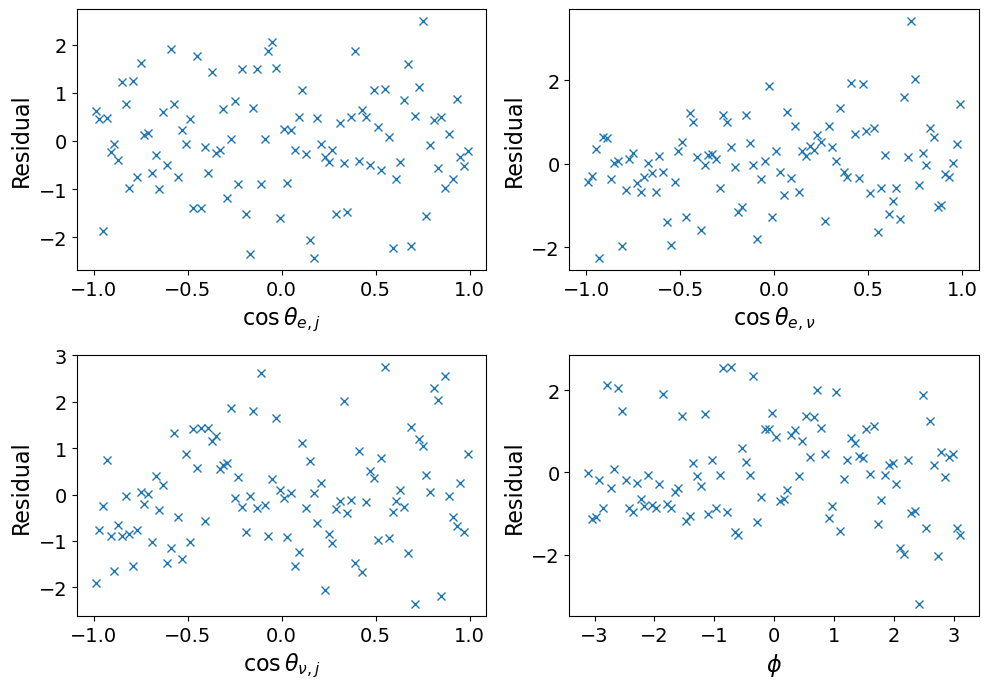

In [21]:
#csct

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5
sqrt_jj = np.sqrt(3/5)

def csct_imag(E):
    xi = 2
    a = -1+1/3
    b = 0
    c = -Lambda_jj
    A = 0
    B = 0
    D = 2*sqrt_jj
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

csctIm_39Ca_polZpos = Ca39_data_analysis("build/39Ca_csct_imag.txt")
csctIm_39Ca_polZpos.event_mask()
csctIm_39Ca_polZpos.kinematical_data()
csctIm_39Ca_polZpos.kinematical_data_ref()
csctIm_39Ca_polZpos.theoretical_dist(csct_imag,numComp=True)
csctIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_csct_imag_hist",lwidth=1)
csctIm_39Ca_polZpos.plot_residuals(fileName="39Ca_csct_imag_res")

0.9751119464636763 1.1851883895235977 0.7265634661955335 0.9080426414530613


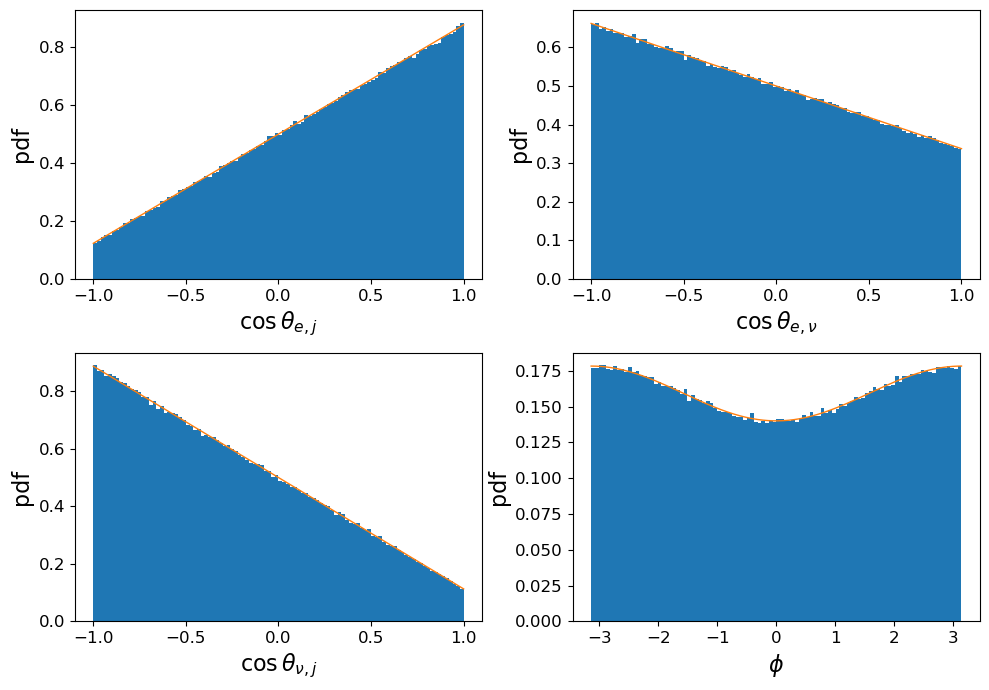

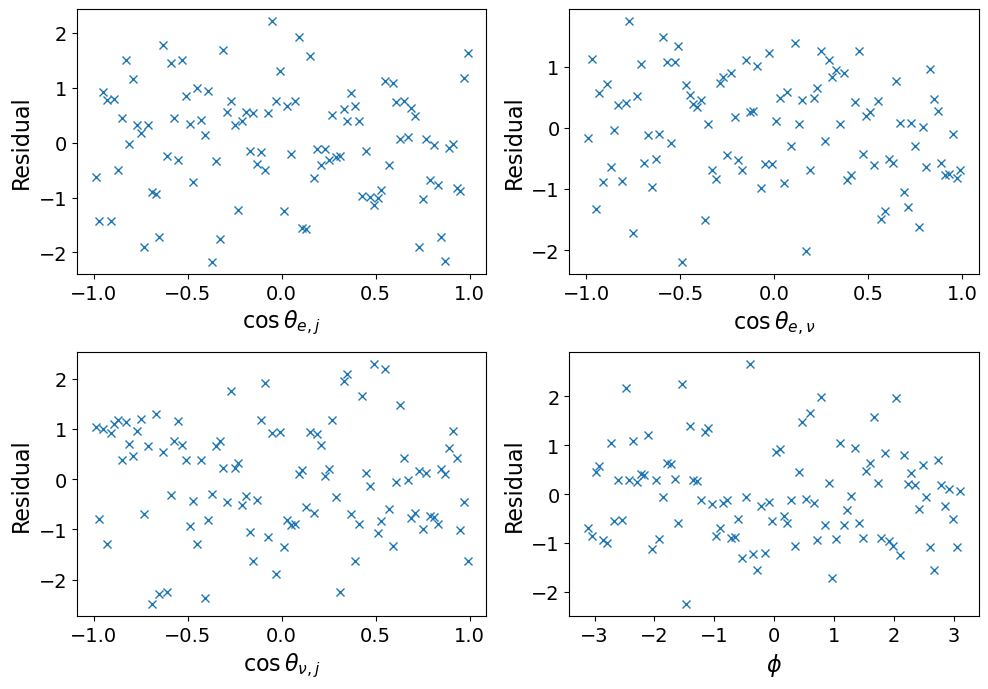

In [22]:
#csctp

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5
sqrt_jj = np.sqrt(3/5)

def csctp_real(E):
    xi = 2
    a = -1+1/3
    b = 0
    c = -Lambda_jj
    A = sqrt_jj*2
    B = -sqrt_jj*2
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

csctpRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_csctp_real.txt")
csctpRe_39Ca_polZpos.event_mask()
csctpRe_39Ca_polZpos.kinematical_data()
csctpRe_39Ca_polZpos.kinematical_data_ref()
csctpRe_39Ca_polZpos.theoretical_dist(csctp_real,numComp=True)
csctpRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_csctp_real_hist",lwidth=1)
csctpRe_39Ca_polZpos.plot_residuals(fileName="39Ca_csctp_real_res")

(-0.6666666666666666, 0.0, -0.4, 0.0, 0.0, 0.020813363758654935)
0.8195608891823802 0.9509561557754529 0.8766199853972252 1.0572653486851822


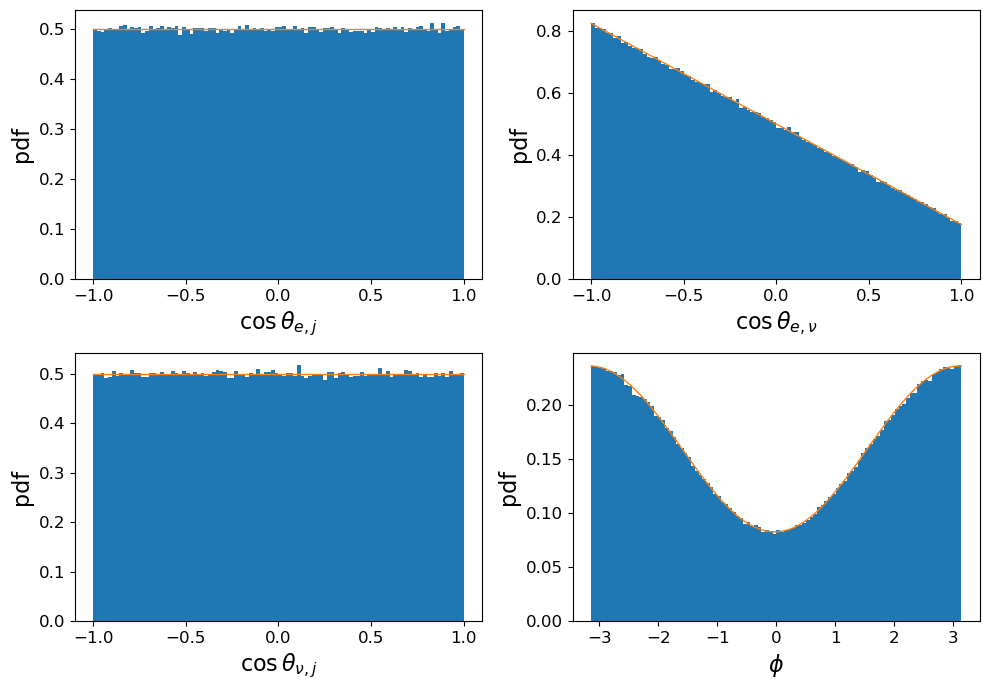

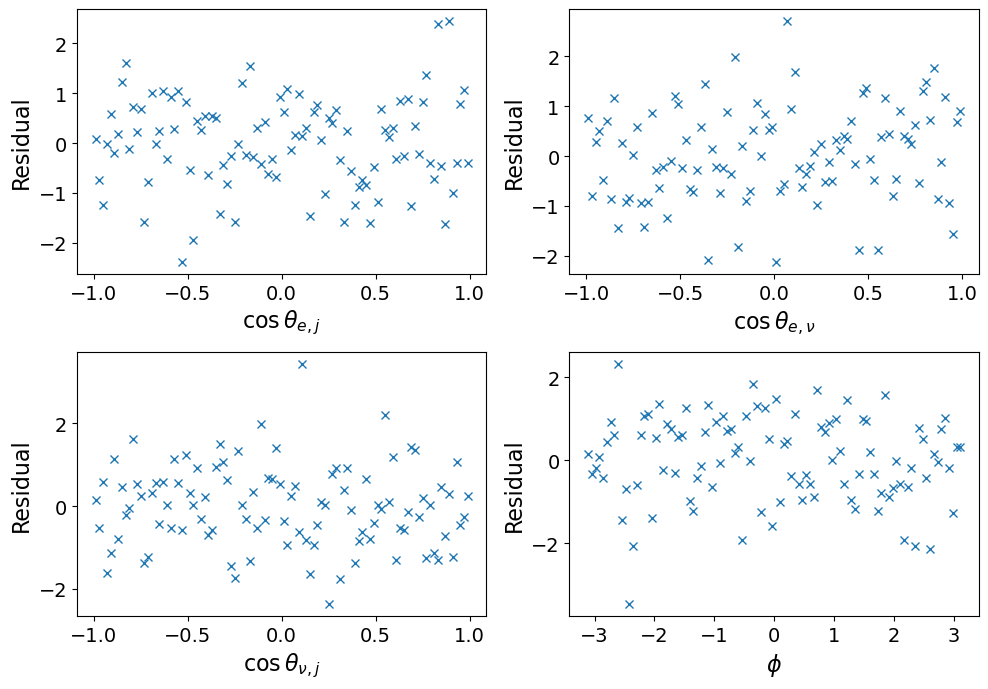

In [23]:
#csca

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5
sqrt_jj = np.sqrt(3/5)
Q = 6524.49

def csca_real(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2
    a = -1-1/3
    b = 0
    c = Lambda_jj
    A = 0
    B = 0
    D = sqrt_jj*2*coulombCorr
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

print(csca_real(Q/3+mass_e))

cscaRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_csca_real.txt")
cscaRe_39Ca_polZpos.event_mask()
cscaRe_39Ca_polZpos.kinematical_data()
cscaRe_39Ca_polZpos.kinematical_data_ref()
cscaRe_39Ca_polZpos.theoretical_dist(csca_real,numComp=True)
cscaRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_csca_real_hist",lwidth=1)
cscaRe_39Ca_polZpos.plot_residuals(fileName="39Ca_csca_real_res")

0.8222264577394407 1.1269140163315015 1.0457470938603173 0.9632361065571896


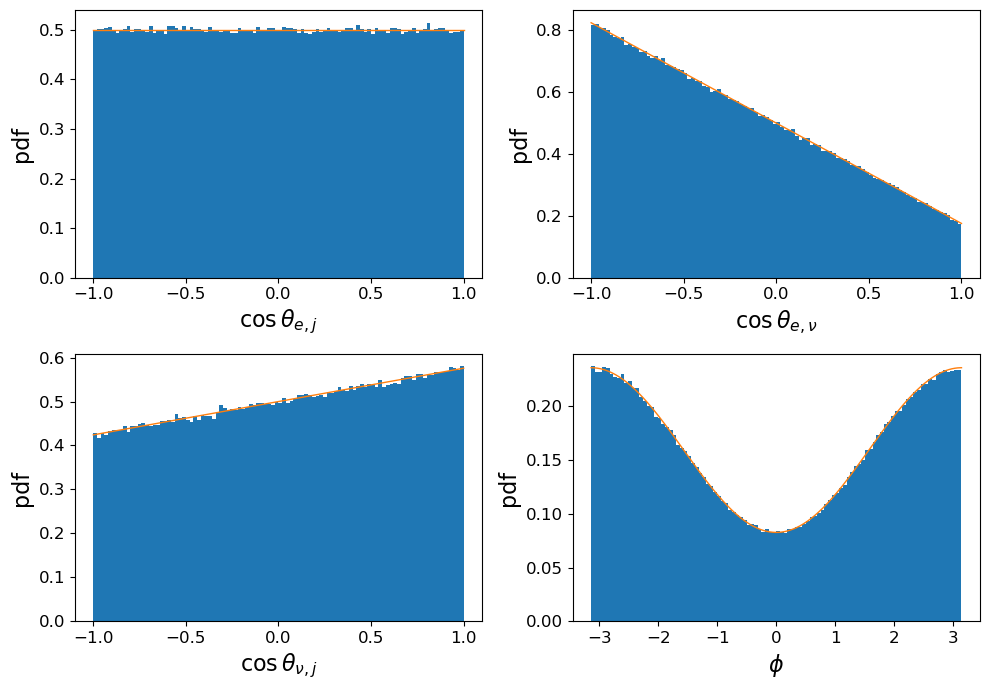

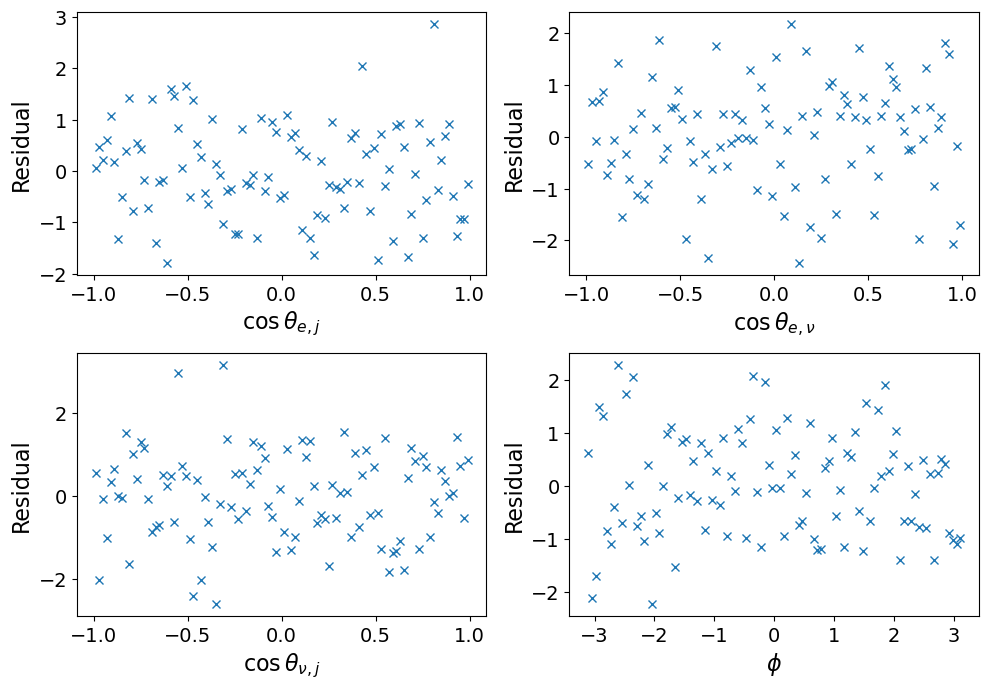

In [24]:
#cscap

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5
sqrt_jj = np.sqrt(3/5)

def cscap_real(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2
    a = -1-1/3
    b = 0
    c = Lambda_jj
    A = 0
    B = sqrt_jj*2*gamma*mass_e/E
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

cscapRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_cscap_real.txt")
cscapRe_39Ca_polZpos.event_mask()
cscapRe_39Ca_polZpos.kinematical_data()
cscapRe_39Ca_polZpos.kinematical_data_ref()
cscapRe_39Ca_polZpos.theoretical_dist(cscap_real,numComp=True)
cscapRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_cscap_real_hist",lwidth=1)
cscapRe_39Ca_polZpos.plot_residuals(fileName="39Ca_cscap_real_res")

(-0.6666666666666666, 0.0, -0.4, -0.023977508866162768, 0.0, 0.0) 0.975972249863188
1.1617857715806215 0.9046911199569517 0.8694048192335366 1.1330832793556604


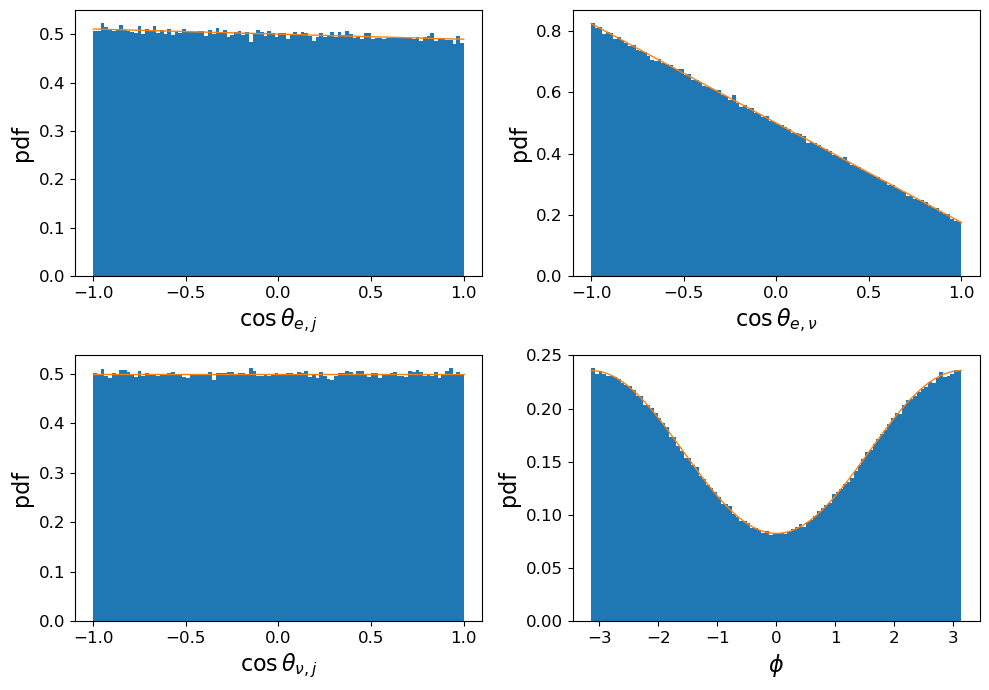

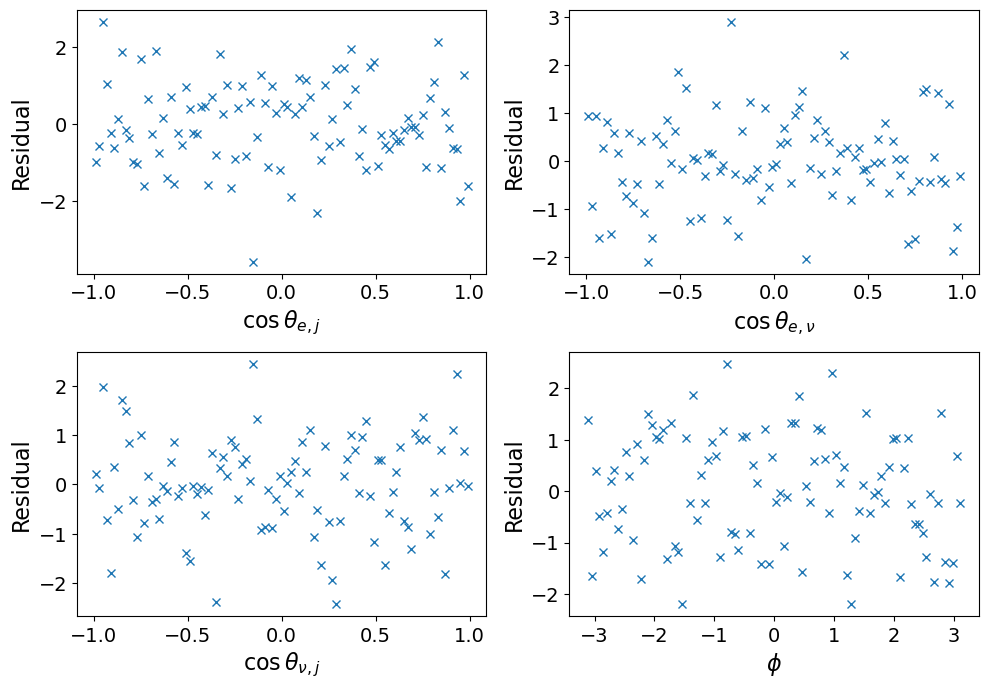

In [25]:
#cscap

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5
sqrt_jj = np.sqrt(3/5)
Q = 6524.49 - 2*mass_e
def beta_E(E):
    return np.sqrt(1-mass_e**2/E**2)
    
def cscap_imag(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2
    a = -1-1/3
    b = 0
    c = Lambda_jj
    A = -sqrt_jj*2*coulombCorr
    B = 0
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

print(cscap_imag(mass_e+Q/3),beta_E(mass_e+Q/3))

cscapIm_39Ca_polZpos = Ca39_data_analysis("build/39Ca_cscap_imag.txt")
cscapIm_39Ca_polZpos.event_mask()
cscapIm_39Ca_polZpos.kinematical_data()
cscapIm_39Ca_polZpos.kinematical_data_ref()
cscapIm_39Ca_polZpos.theoretical_dist(cscap_imag,numComp=True)
cscapIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_cscap_imag_hist",lwidth=1)
cscapIm_39Ca_polZpos.plot_residuals(fileName="39Ca_cscap_imag_res")

0.8907593068995387 1.085698784642795 0.9740441974098759 1.0029811831474842


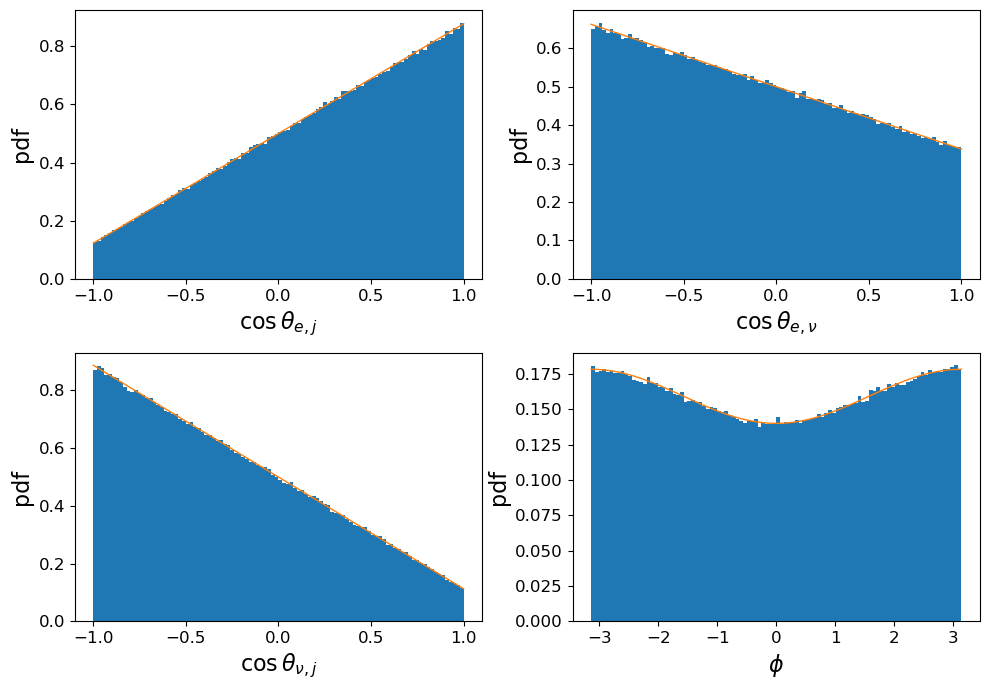

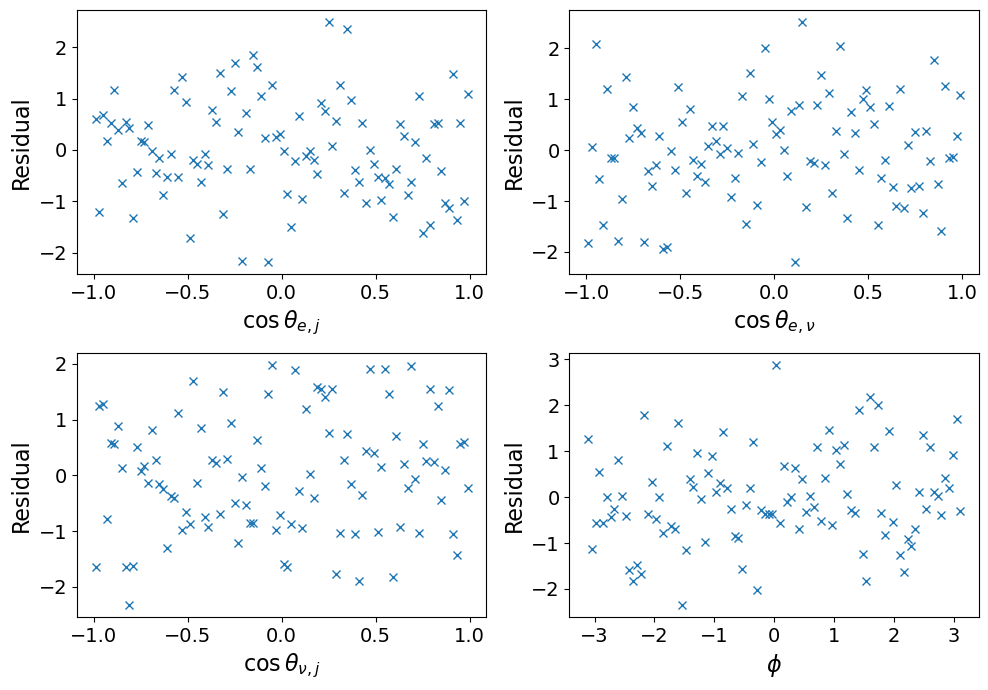

In [26]:
#cspct

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5
sqrt_jj = np.sqrt(3/5)
Q = 6524.49 - 2*mass_e
    
def cspct_real(E):
    xi = 2
    a = -1+1/3
    b = 0
    c = -Lambda_jj
    A = sqrt_jj*2
    B = -sqrt_jj*2
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

cspctRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_cspct_real.txt")
cspctRe_39Ca_polZpos.event_mask()
cspctRe_39Ca_polZpos.kinematical_data()
cspctRe_39Ca_polZpos.kinematical_data_ref()
cspctRe_39Ca_polZpos.theoretical_dist(cspct_real,numComp=True)
cspctRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_cspct_real_hist",lwidth=1)
cspctRe_39Ca_polZpos.plot_residuals(fileName="39Ca_cspct_real_res")

0.9299297025505929 1.1788587148475724 1.3603119941676365 1.2683438643420564


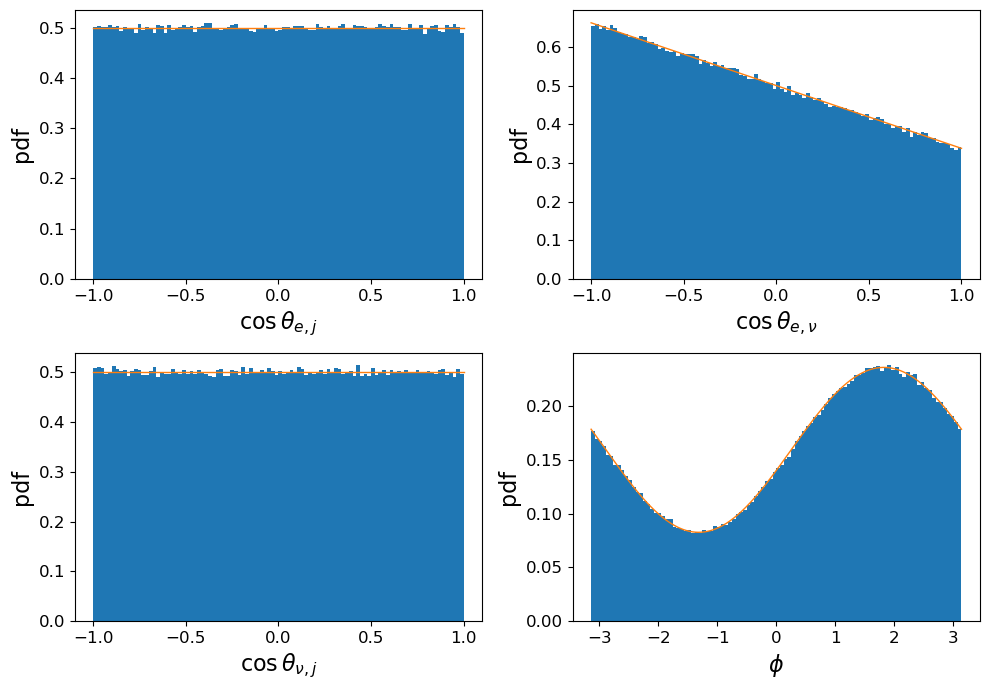

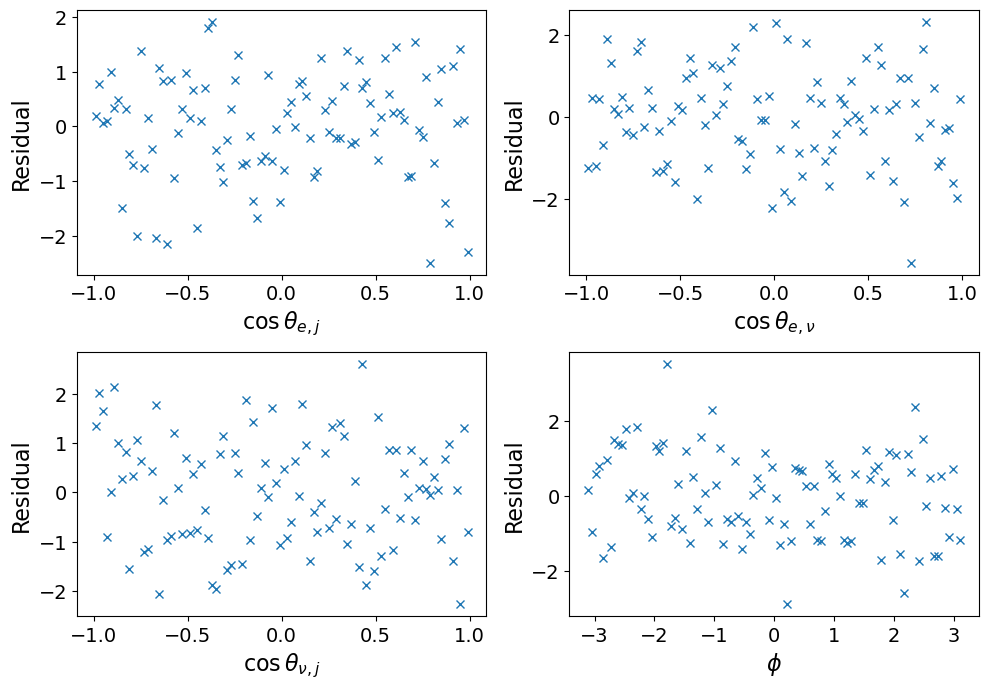

In [28]:
#cspctp

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5
sqrt_jj = np.sqrt(3/5)

def cspctp_imag(E):
    xi = 2
    a = -1+1/3
    b = 0
    c = -Lambda_jj
    A = 0
    B = 0
    D = 2*sqrt_jj
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

cspctpRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_cspctp_imag.txt")
cspctpRe_39Ca_polZpos.event_mask()
cspctpRe_39Ca_polZpos.kinematical_data()
cspctpRe_39Ca_polZpos.kinematical_data_ref()
cspctpRe_39Ca_polZpos.theoretical_dist(cspctp_imag,numComp=True)
cspctpRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_cspctp_real_hist",lwidth=1)
cspctpRe_39Ca_polZpos.plot_residuals(fileName="39Ca_cspctp_real_res")

0.8951597011104707 0.8732910762595975 0.8932605787782764 1.225315616498912


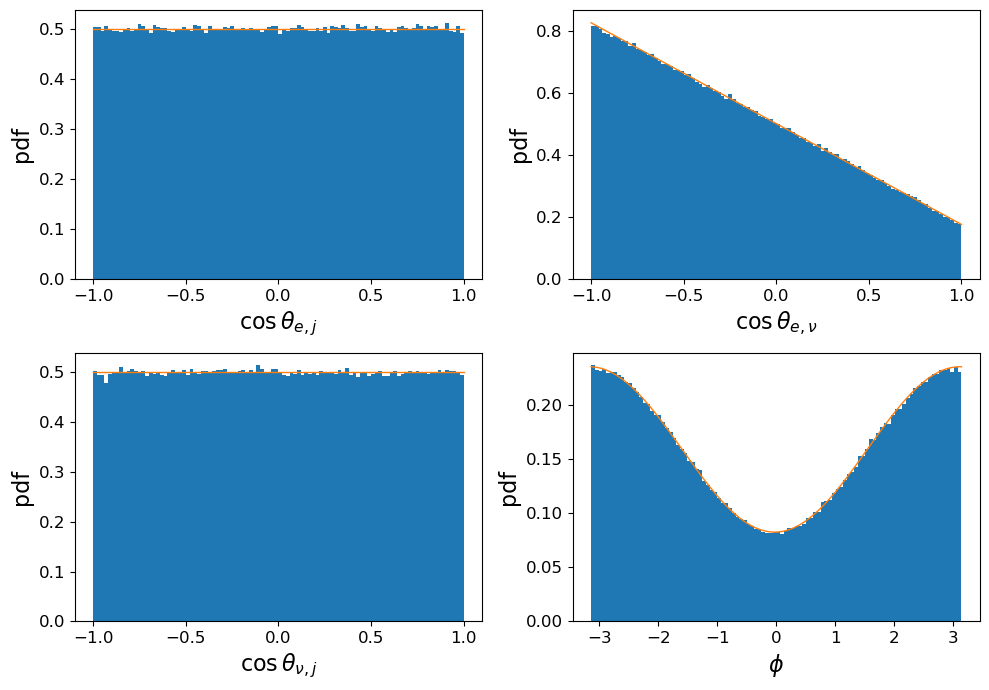

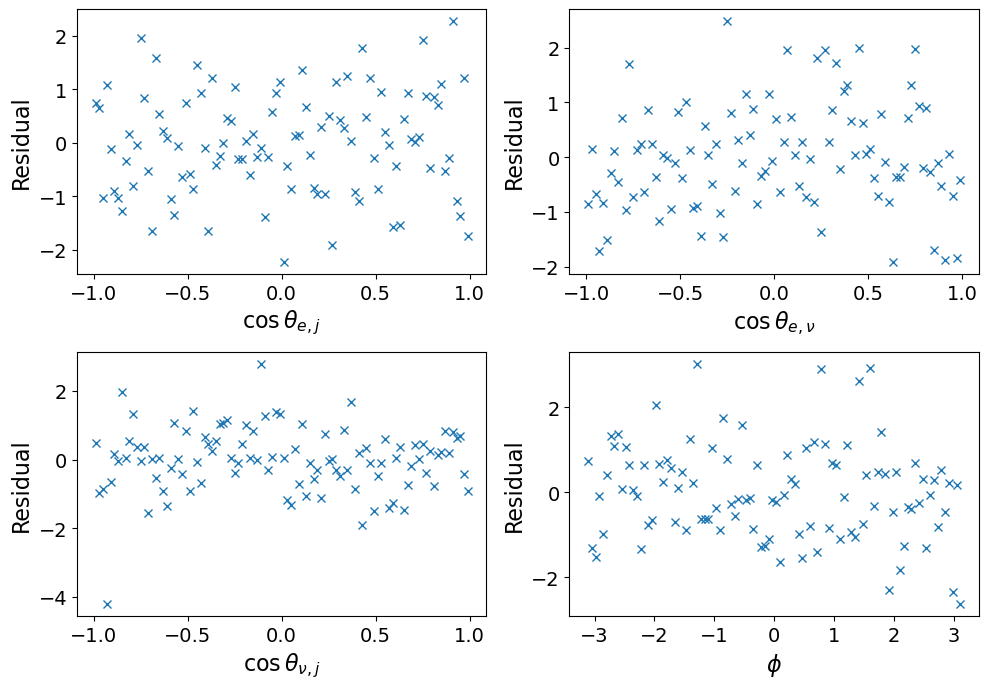

In [30]:
#cspcap

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5
sqrt_jj = np.sqrt(3/5)

def cspcap_real(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2
    a = -1-1/3
    b = 0
    c = Lambda_jj
    A = 0
    B = 0
    D = sqrt_jj*2*coulombCorr
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

cspcapRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_cspcap_real.txt")
cspcapRe_39Ca_polZpos.event_mask()
cspcapRe_39Ca_polZpos.kinematical_data()
cspcapRe_39Ca_polZpos.kinematical_data_ref()
cspcapRe_39Ca_polZpos.theoretical_dist(cspcap_real,numComp=True)
cspcapRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_cspcap_real_hist",lwidth=1)
cspcapRe_39Ca_polZpos.plot_residuals(fileName="39Ca_cspcap_real_res")

1.024133451080504 0.8976288272152168 0.8442335566185484 0.9083620802028085


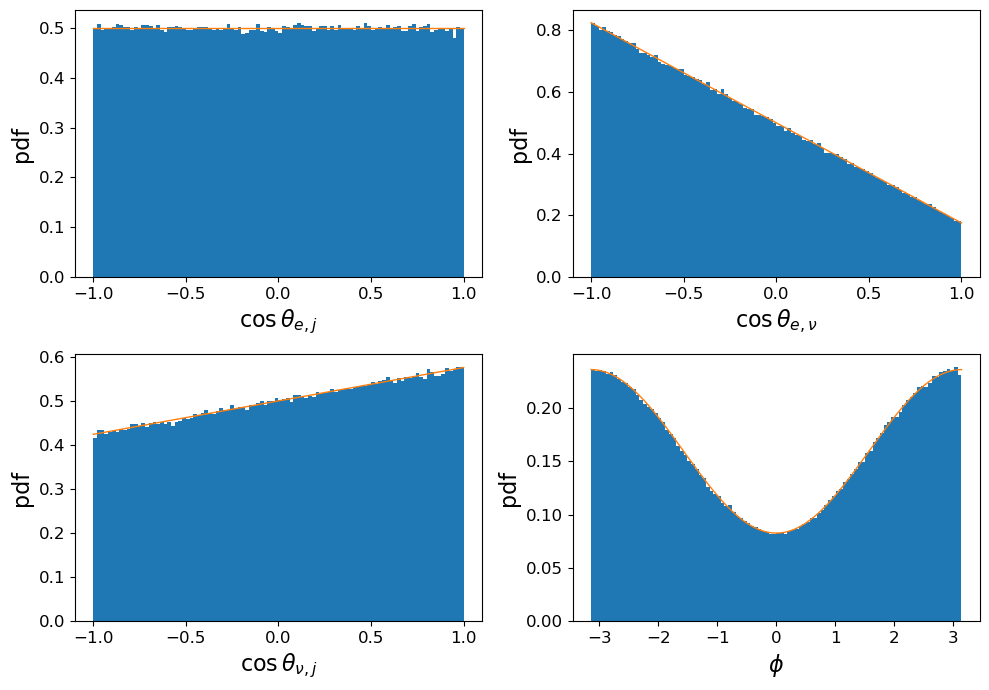

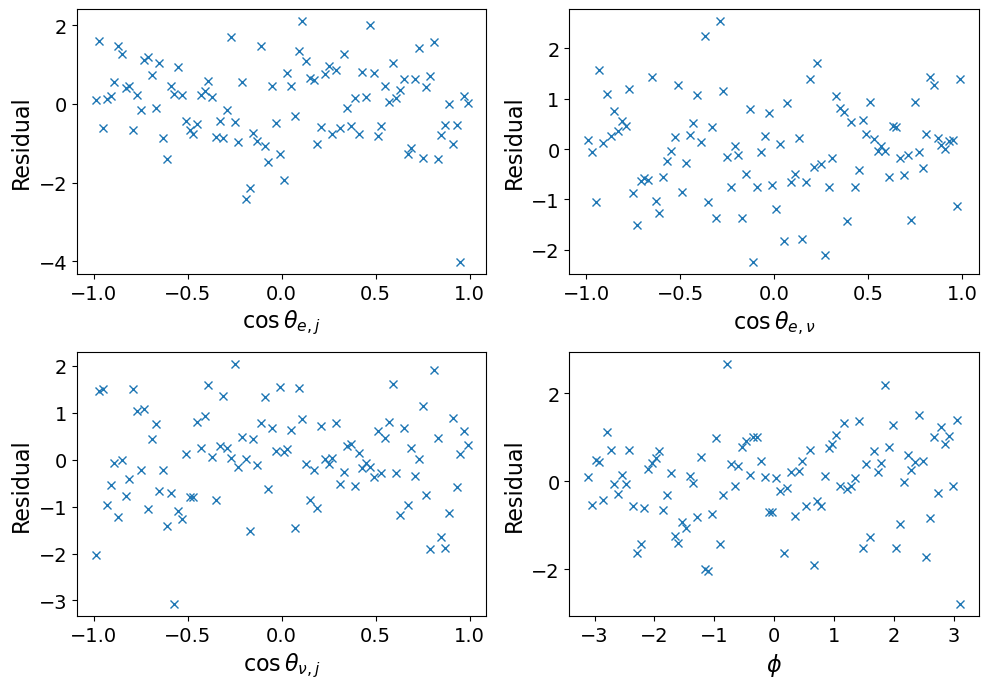

In [31]:
#cspca

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5
sqrt_jj = np.sqrt(3/5)

def cspca_real(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2
    a = -1-1/3
    b = 0
    c = Lambda_jj
    A = 0
    B = sqrt_jj*2*gamma*mass_e/E
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

cspcaRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_cspca_real.txt")
cspcaRe_39Ca_polZpos.event_mask()
cspcaRe_39Ca_polZpos.kinematical_data()
cspcaRe_39Ca_polZpos.kinematical_data_ref()
cspcaRe_39Ca_polZpos.theoretical_dist(cspca_real,numComp=True)
cspcaRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_cspca_real_hist",lwidth=1)
cspcaRe_39Ca_polZpos.plot_residuals(fileName="39Ca_cspca_real_res")

(-0.6666666666666666, 0.0, -0.4, -0.023977508866162768, 0.0, 0.0) 0.975972249863188
1.1212741142933462 0.9118038184656886 0.9722259918174363 0.7331797611279964


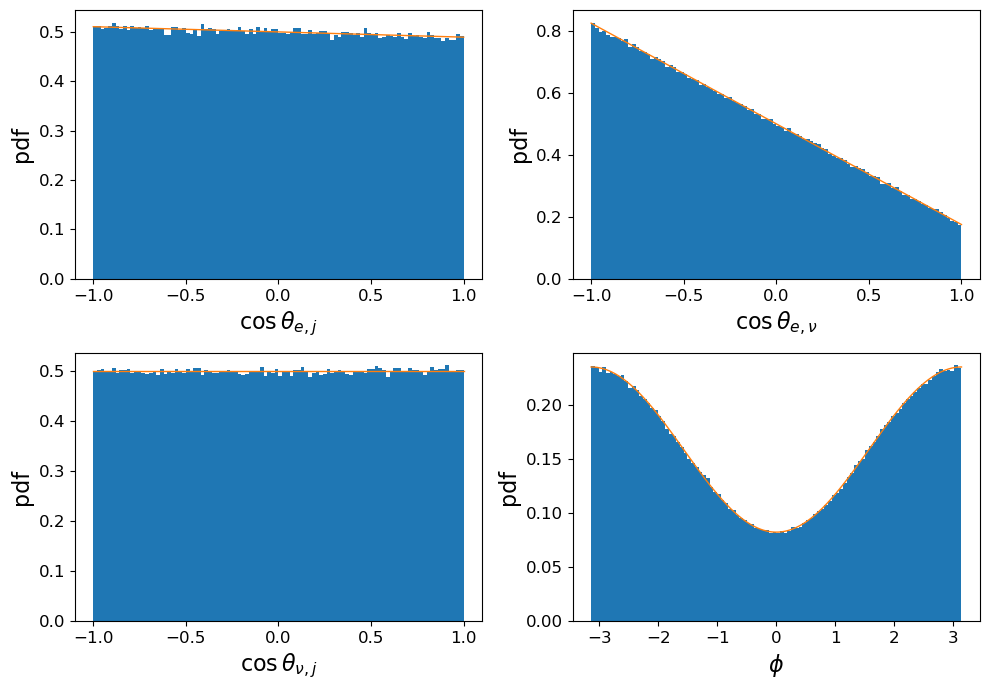

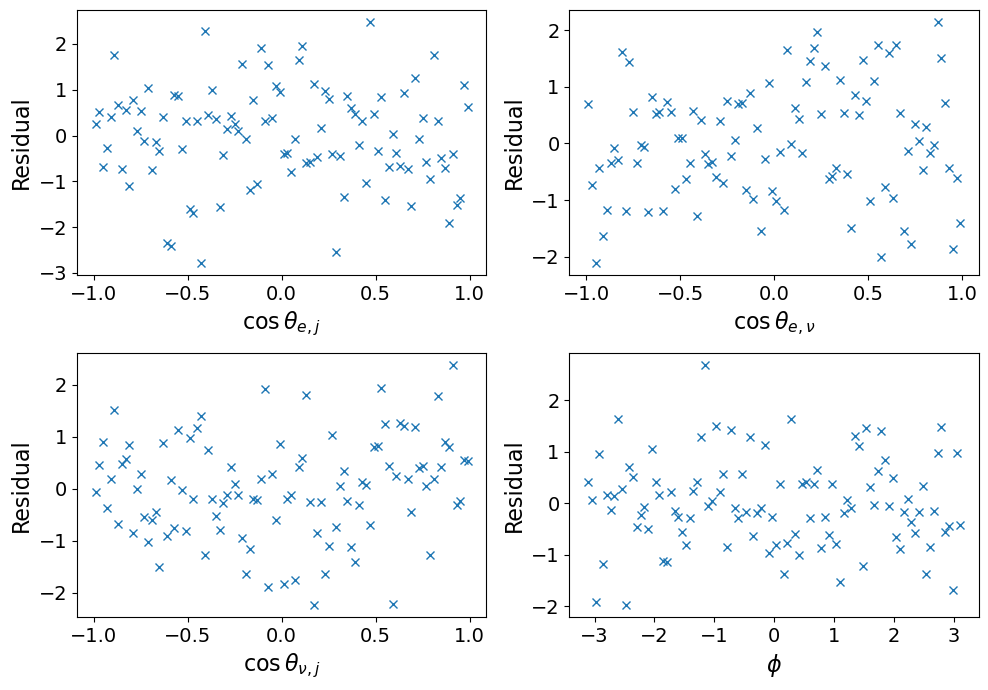

In [32]:
#cspca

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5
sqrt_jj = np.sqrt(3/5)
Q = 6524.49 - 2*mass_e
def beta_E(E):
    return np.sqrt(1-mass_e**2/E**2)
    
def cspca_imag(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2
    a = -1-1/3
    b = 0
    c = Lambda_jj
    A = -sqrt_jj*2*coulombCorr
    B = 0
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

print(cscap_imag(mass_e+Q/3),beta_E(mass_e+Q/3))

cspcaIm_39Ca_polZpos = Ca39_data_analysis("build/39Ca_cspca_imag.txt")
cspcaIm_39Ca_polZpos.event_mask()
cspcaIm_39Ca_polZpos.kinematical_data()
cspcaIm_39Ca_polZpos.kinematical_data_ref()
cspcaIm_39Ca_polZpos.theoretical_dist(cspca_imag,numComp=True)
cspcaIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_cspca_imag_hist",lwidth=1)
cspcaIm_39Ca_polZpos.plot_residuals("39Ca_cspca_imag_res")

1.3012493169955985 1.0687961389796685 0.9659100982605345 1.1298739971531364


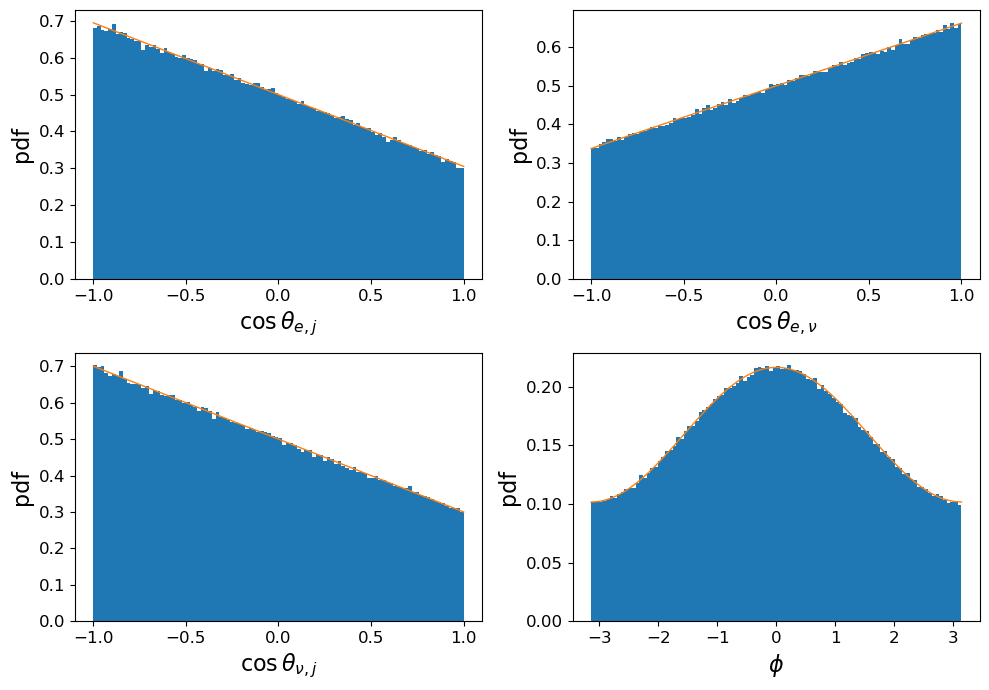

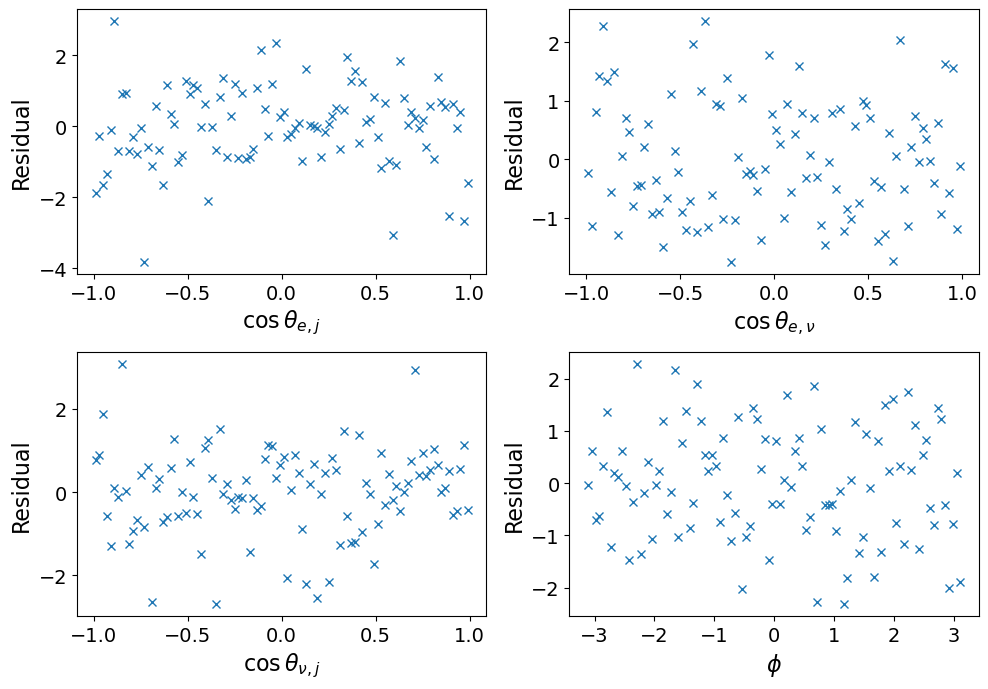

In [33]:
#ctctp

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5

def ctctp_real(E):
    xi = 2
    a = 2/3
    b = 0
    c = -2*Lambda_jj
    A = -2*lambda_jj
    B = -2*lambda_jj
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

ctctpRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_ctctp_real.txt")
ctctpRe_39Ca_polZpos.event_mask()
ctctpRe_39Ca_polZpos.kinematical_data()
ctctpRe_39Ca_polZpos.kinematical_data_ref()
ctctpRe_39Ca_polZpos.theoretical_dist(ctctp_real,numComp=True)
ctctpRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_ctctp_real_hist",lwidth=1)
ctctpRe_39Ca_polZpos.plot_residuals(fileName="39Ca_ctctp_real_res")

1.01470855100902 1.0873062447767428 0.9812479828877235 1.0512456865951156


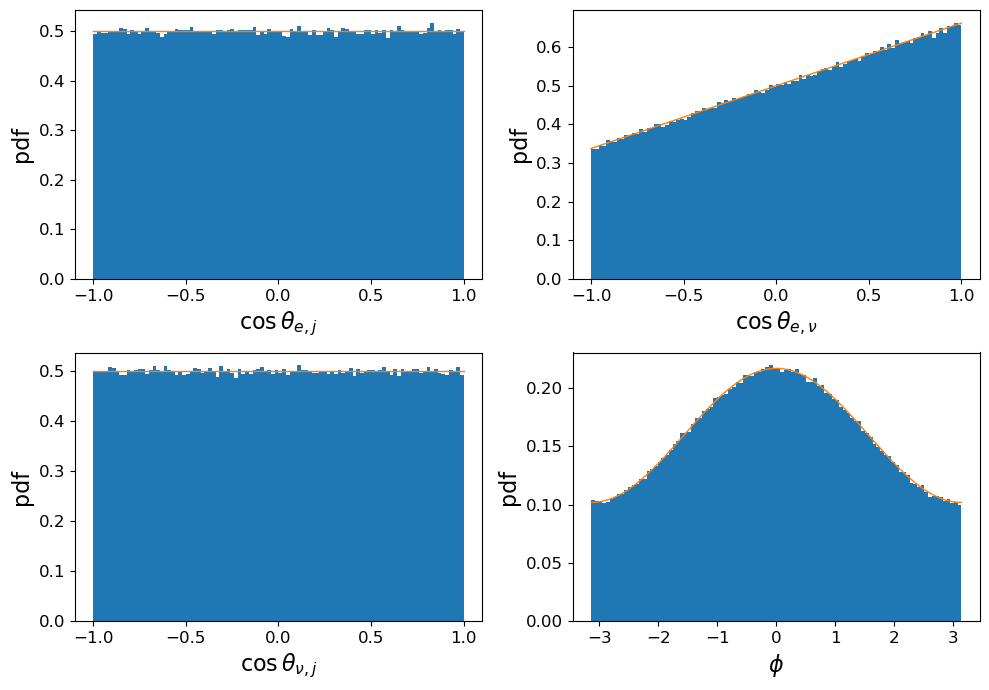

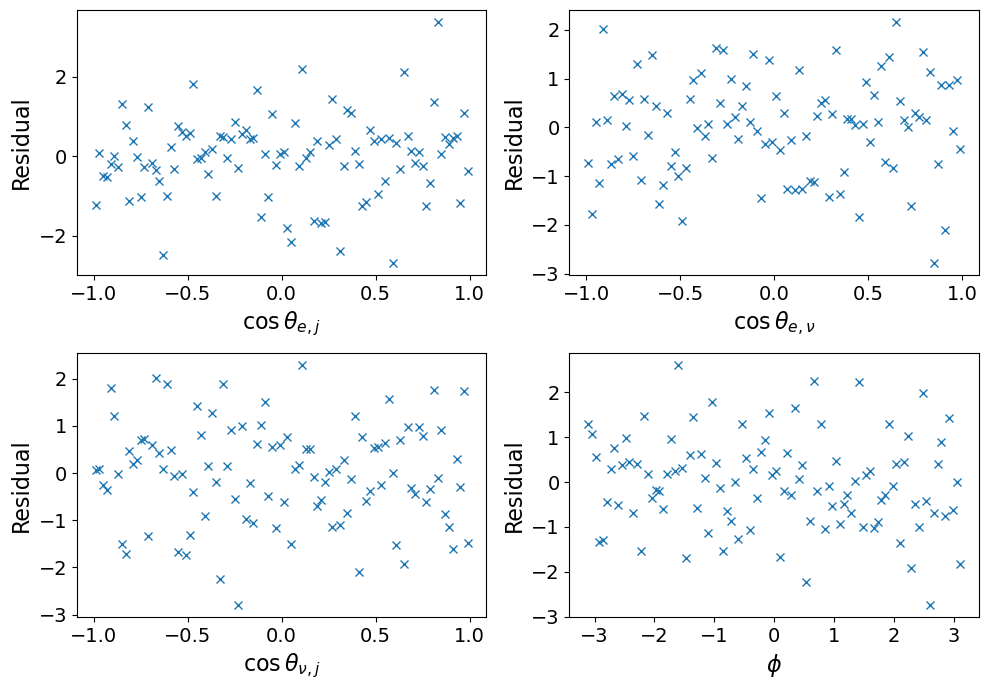

In [34]:
#ctctp

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5

def ctctp_imag(E):
    xi = 2
    a = 2/3
    b = 0
    c = -2*Lambda_jj
    A = 0
    B = 0
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

ctctpIm_39Ca_polZpos = Ca39_data_analysis("build/39Ca_ctctp_imag.txt")
ctctpIm_39Ca_polZpos.event_mask()
ctctpIm_39Ca_polZpos.kinematical_data()
ctctpIm_39Ca_polZpos.kinematical_data_ref()
ctctpIm_39Ca_polZpos.theoretical_dist(ctctp_imag,numComp=True)
ctctpIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_ctctp_imag_hist",lwidth=1)
ctctpIm_39Ca_polZpos.plot_residuals(fileName="39Ca_ctctp_imag_res")

0.843431831533334 0.8008053518766949 0.9515836255641404 1.0956273668838905


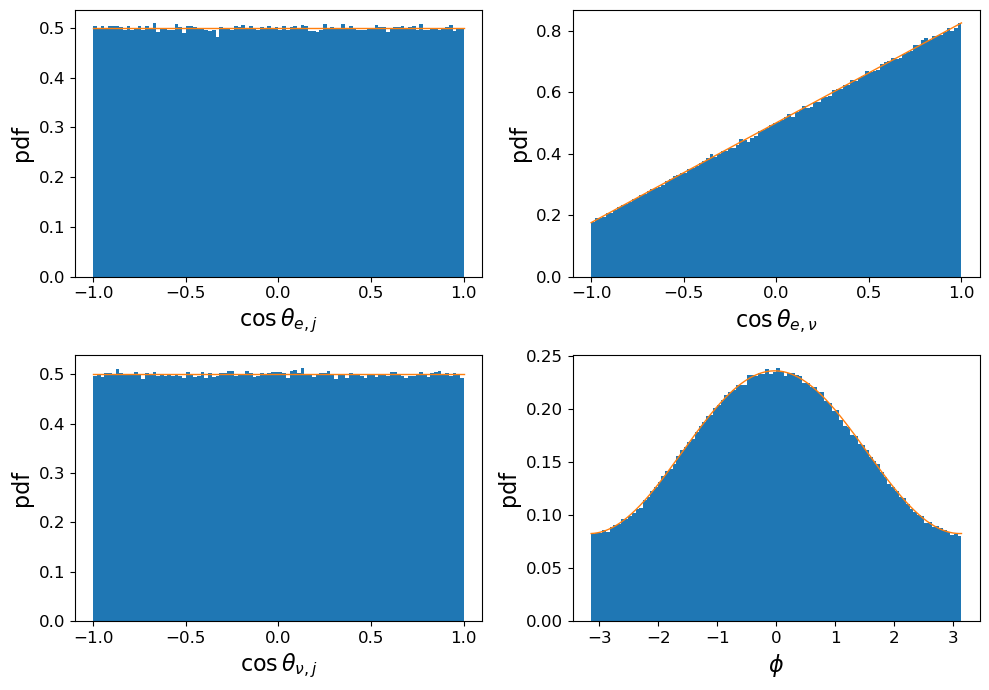

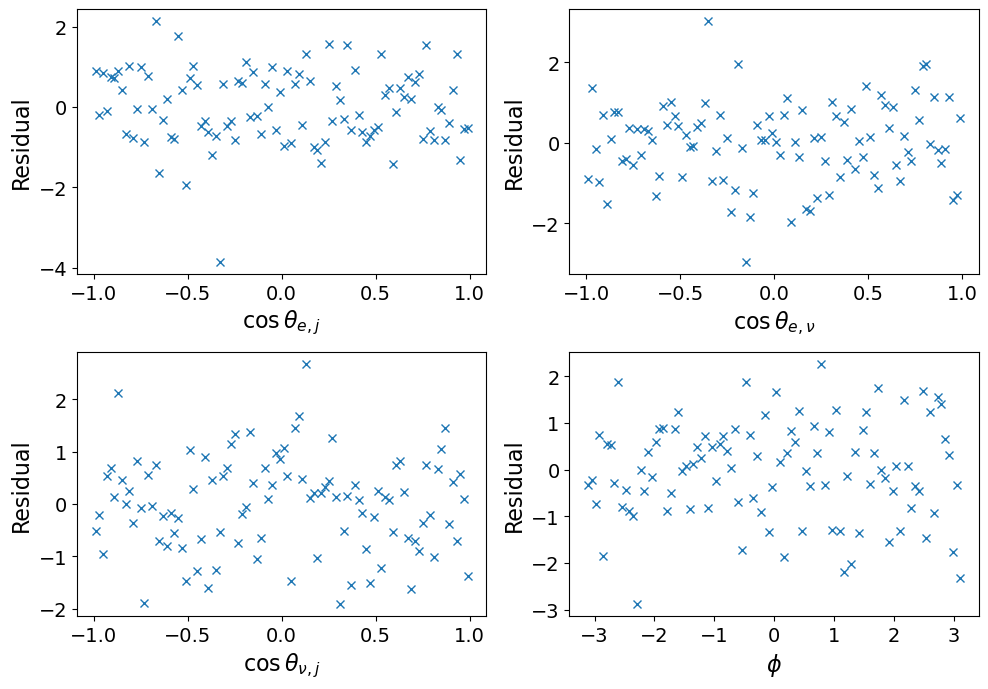

In [35]:
#ctcv

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5
sqrt_jj = np.sqrt(3/5)

def ctcv_real(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2
    a = 1+1/3
    b = 0
    c = -Lambda_jj
    A = 0
    B = 0
    D = -sqrt_jj*2*coulombCorr
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

ctcvRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_ctcv_real.txt")
ctcvRe_39Ca_polZpos.event_mask()
ctcvRe_39Ca_polZpos.kinematical_data()
ctcvRe_39Ca_polZpos.kinematical_data_ref()
ctcvRe_39Ca_polZpos.theoretical_dist(ctcv_real,numComp=True)
ctcvRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_ctcv_real_hist",lwidth=1)
ctcvRe_39Ca_polZpos.plot_residuals(fileName="39Ca_ctcv_real_res")

0.9419303652151194 0.9108432840612344 0.9473510024413005 1.2619266907127586


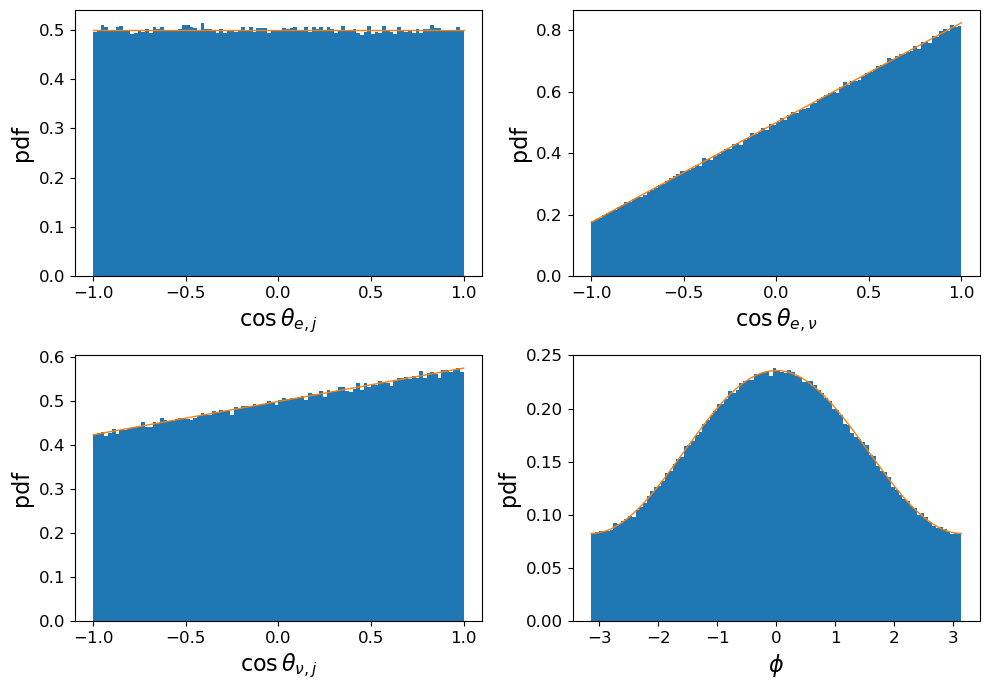

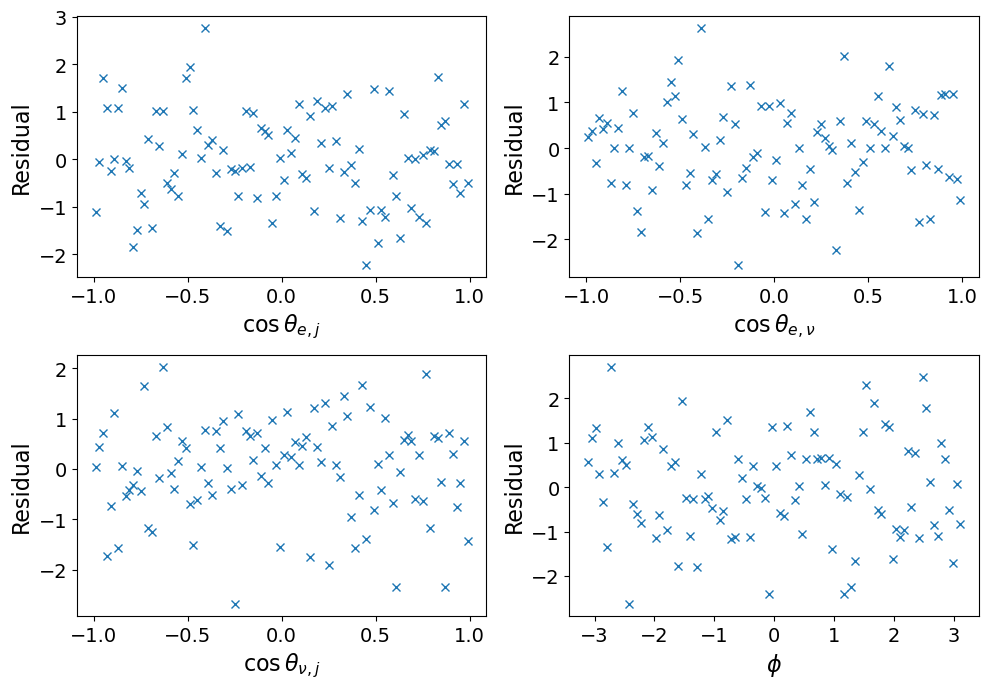

In [37]:
#ctcvp

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5
sqrt_jj = np.sqrt(3/5)

def ctcvp_real(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2
    a = +1+1/3
    b = 0
    c = -Lambda_jj
    A = 0
    B = sqrt_jj*2*gamma*mass_e/E
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

ctcvpRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_ctcvp_real.txt")
ctcvpRe_39Ca_polZpos.event_mask()
ctcvpRe_39Ca_polZpos.kinematical_data()
ctcvpRe_39Ca_polZpos.kinematical_data_ref()
ctcvpRe_39Ca_polZpos.theoretical_dist(ctcvp_real,numComp=True)
ctcvpRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_ctcvp_real_hist",lwidth=1)
ctcvpRe_39Ca_polZpos.plot_residuals(fileName="39Ca_ctcvp_real_res")

(-0.6666666666666666, 0.0, -0.4, -0.023977508866162768, 0.0, 0.0) 0.975972249863188
0.832256233159504 0.8092158510950733 1.0931719563525741 0.8771907214755832


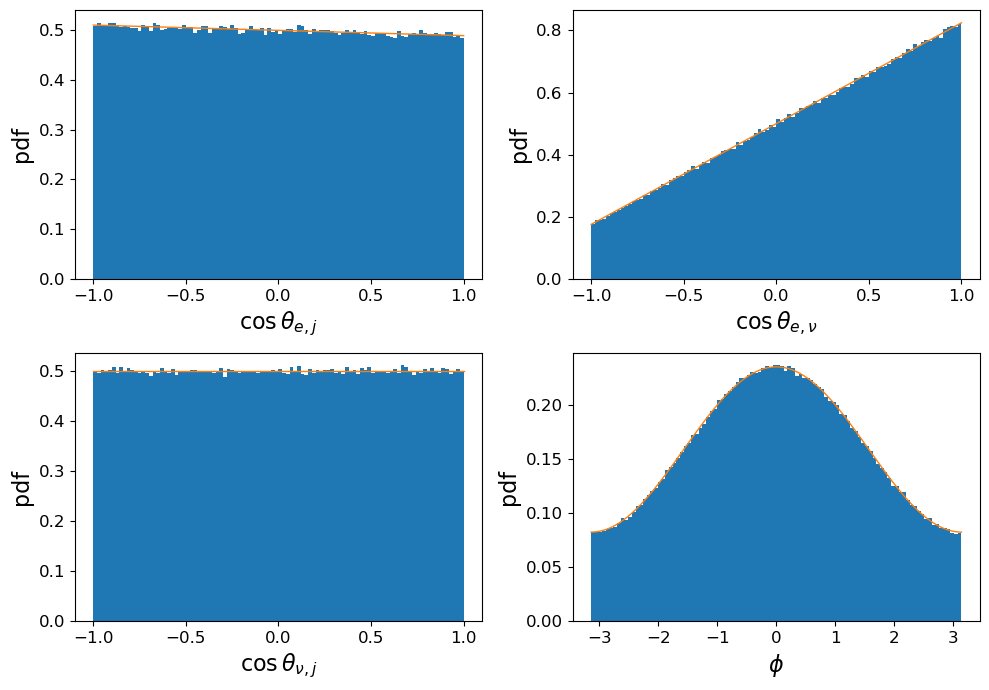

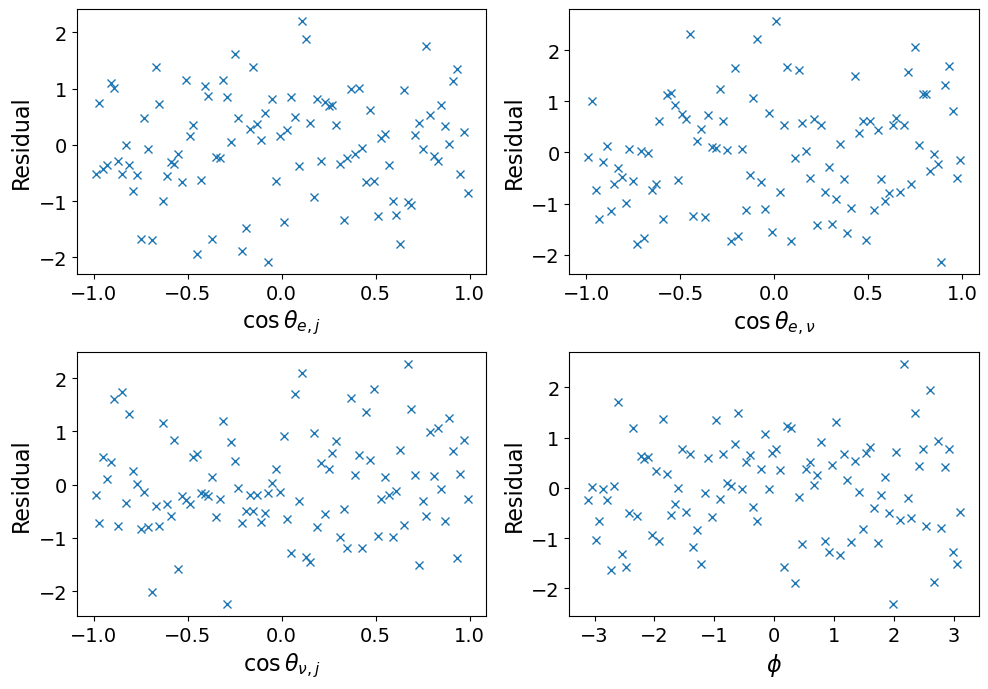

In [38]:
#ctcvp

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5
sqrt_jj = np.sqrt(3/5)
Q = 6524.49 - 2*mass_e
def beta_E(E):
    return np.sqrt(1-mass_e**2/E**2)
    
def ctcvp_imag(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2
    a = +1+1/3
    b = 0
    c = -Lambda_jj
    A = -sqrt_jj*2*coulombCorr
    B = 0
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

print(cscap_imag(mass_e+Q/3),beta_E(mass_e+Q/3))

ctcvpIm_39Ca_polZpos = Ca39_data_analysis("build/39Ca_ctcvp_imag.txt")
ctcvpIm_39Ca_polZpos.event_mask()
ctcvpIm_39Ca_polZpos.kinematical_data()
ctcvpIm_39Ca_polZpos.kinematical_data_ref()
ctcvpIm_39Ca_polZpos.theoretical_dist(ctcvp_imag,numComp=True)
ctcvpIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_ctcvp_imag_hist",lwidth=1)
ctcvpIm_39Ca_polZpos.plot_residuals(fileName="39Ca_ctcvp_imag_res")

0.8334336004503047 0.881761304823741 1.1066236029372487 1.1179031684609557


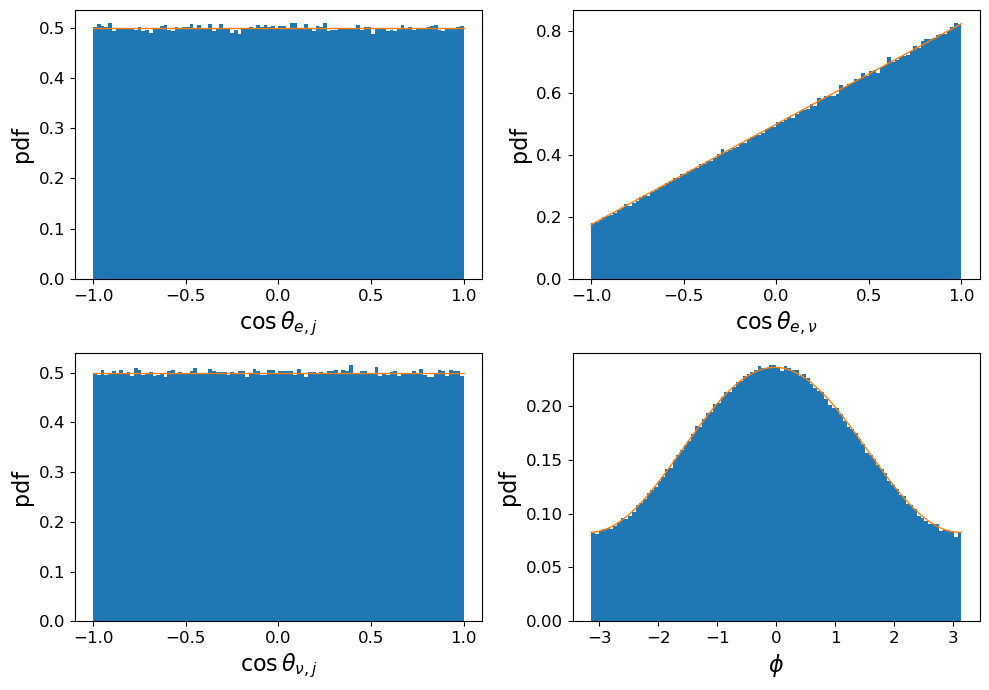

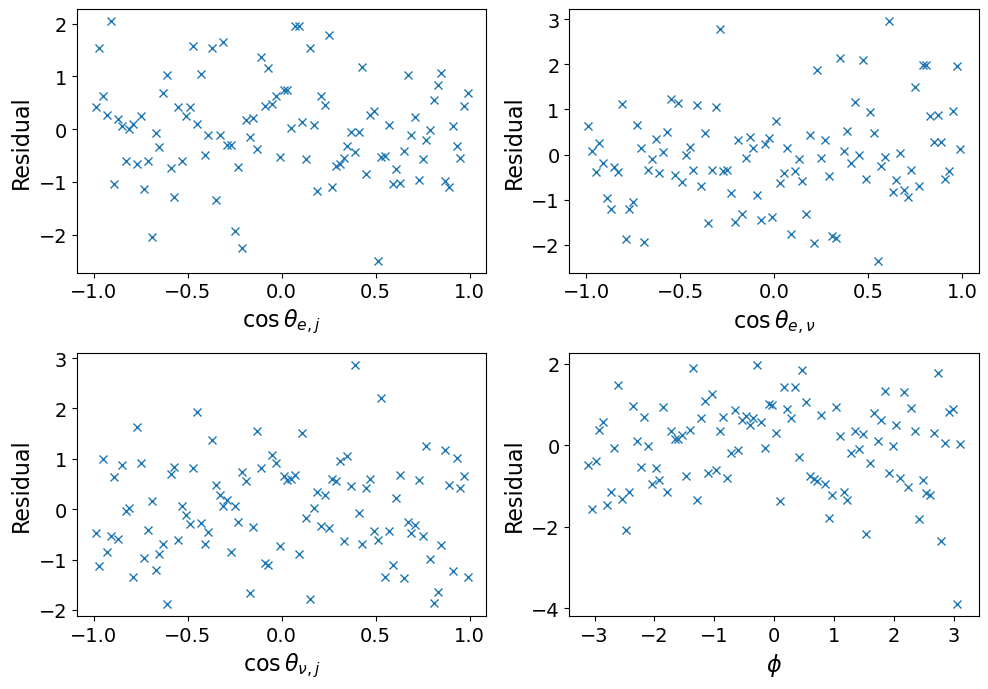

In [48]:
#ctpcvp

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5
sqrt_jj = np.sqrt(3/5)

def ctpcvp_real(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2
    a = 1+1/3
    b = 0
    c = -Lambda_jj
    A = 0
    B = 0
    D = -sqrt_jj*2*coulombCorr
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

ctpcvpRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_ctpcvp_real.txt")
ctpcvpRe_39Ca_polZpos.event_mask()
ctpcvpRe_39Ca_polZpos.kinematical_data()
ctpcvpRe_39Ca_polZpos.kinematical_data_ref()
ctpcvpRe_39Ca_polZpos.theoretical_dist(ctpcvp_real,numComp=True)
ctpcvpRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_ctpcvp_real_hist",lwidth=1)
ctpcvpRe_39Ca_polZpos.plot_residuals(fileName="39Ca_ctpcvp_real_res")

0.9325983526584174 0.9968437415864603 0.7569692557990195 0.9618926592311794


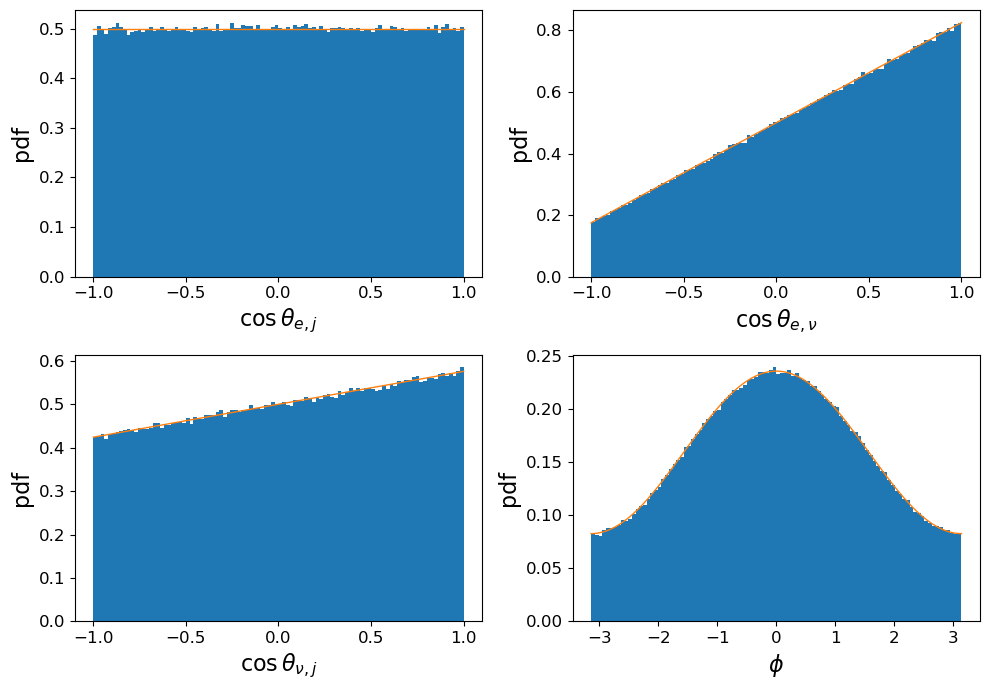

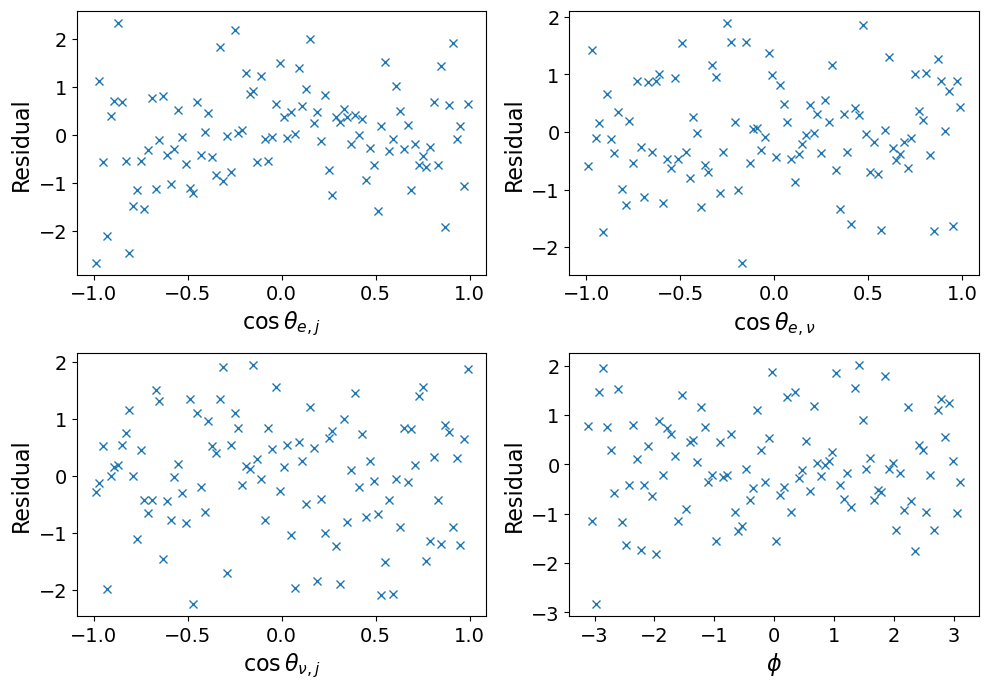

In [47]:
#ctpcv

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5
sqrt_jj = np.sqrt(3/5)

def ctpcv_real(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2
    a = +1+1/3
    b = 0
    c = -Lambda_jj
    A = 0
    B = sqrt_jj*2*gamma*mass_e/E
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

ctpcvRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_ctpcv_real.txt")
ctpcvRe_39Ca_polZpos.event_mask()
ctpcvRe_39Ca_polZpos.kinematical_data()
ctpcvRe_39Ca_polZpos.kinematical_data_ref()
ctpcvRe_39Ca_polZpos.theoretical_dist(ctpcv_real,numComp=True)
ctpcvRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_ctpcv_real_hist",lwidth=1)
ctpcvRe_39Ca_polZpos.plot_residuals(fileName="39Ca_ctpcv_real_res")

(-0.6666666666666666, 0.0, -0.4, -0.023977508866162768, 0.0, 0.0) 0.975972249863188
1.1625733852244033 1.168610165292223 1.017167420088508 1.1466476926206854


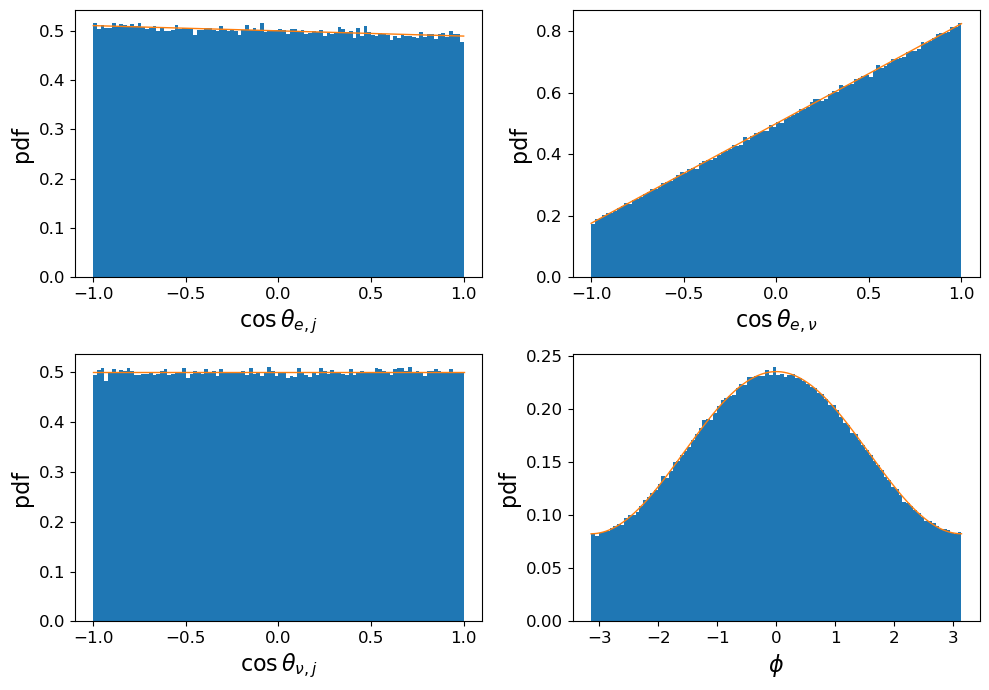

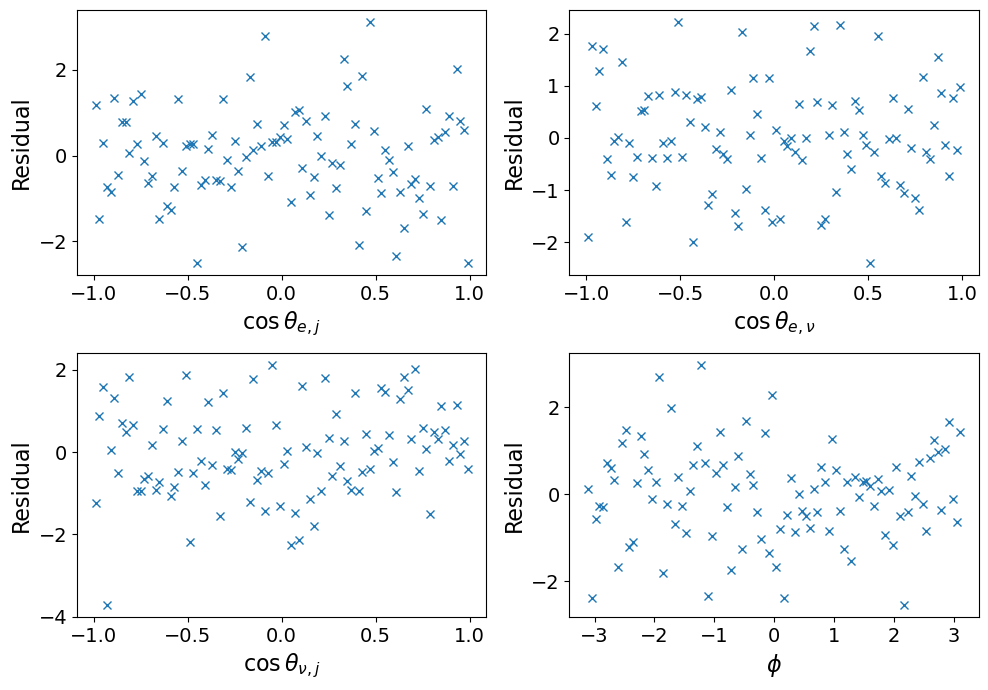

In [46]:
#ctpcv

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5
sqrt_jj = np.sqrt(3/5)
Q = 6524.49 - 2*mass_e
def beta_E(E):
    return np.sqrt(1-mass_e**2/E**2)
    
def ctpcv_imag(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2
    a = +1+1/3
    b = 0
    c = -Lambda_jj
    A = -sqrt_jj*2*coulombCorr
    B = 0
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

print(cscap_imag(mass_e+Q/3),beta_E(mass_e+Q/3))

ctpcvIm_39Ca_polZpos = Ca39_data_analysis("build/39Ca_ctpcv_imag.txt")
ctpcvIm_39Ca_polZpos.event_mask()
ctpcvIm_39Ca_polZpos.kinematical_data()
ctpcvIm_39Ca_polZpos.kinematical_data_ref()
ctpcvIm_39Ca_polZpos.theoretical_dist(ctcvp_imag,numComp=True)
ctpcvIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_ctpcv_imag_hist",lwidth=1)
ctpcvIm_39Ca_polZpos.plot_residuals(fileName="39Ca_ctpcv_imag_res")

0.7235515697026059 0.8323791861847301 1.0620759446633787 1.0264463502743915


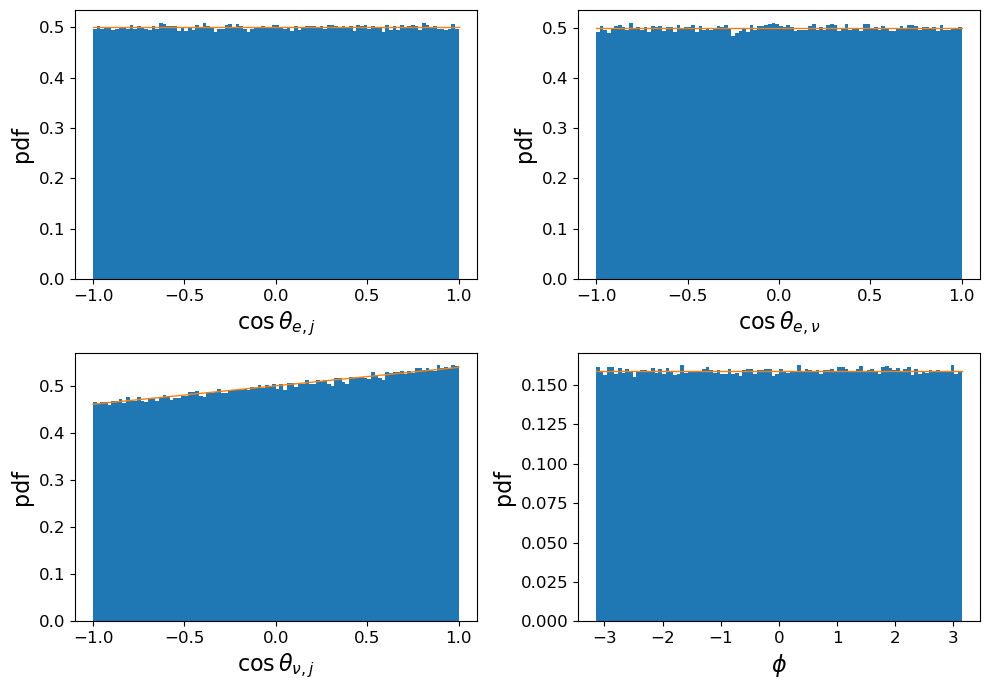

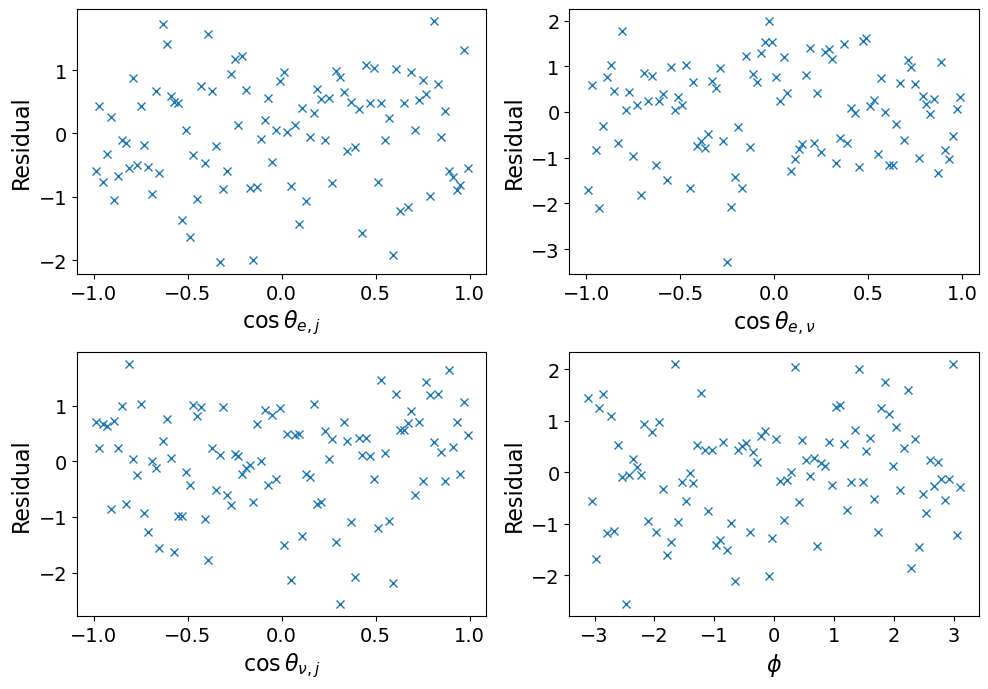

In [40]:
#ctcap

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5

def ctcap_real(E):
    xi = 2
    a = 0
    b = 0
    c = 0
    A = 0
    B = 2*lambda_jj*gamma*mass_e/E
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

ctcapRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_ctcap_real.txt")
ctcapRe_39Ca_polZpos.event_mask()
ctcapRe_39Ca_polZpos.kinematical_data()
ctcapRe_39Ca_polZpos.kinematical_data_ref()
ctcapRe_39Ca_polZpos.theoretical_dist(ctcap_real,numComp=True)
ctcapRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_ctcap_real_hist",lwidth=1)
ctcapRe_39Ca_polZpos.plot_residuals(fileName="39Ca_ctcap_real_res")

1.1811294865144897 1.242797433236552 1.0011446294215605 0.7107538202627589


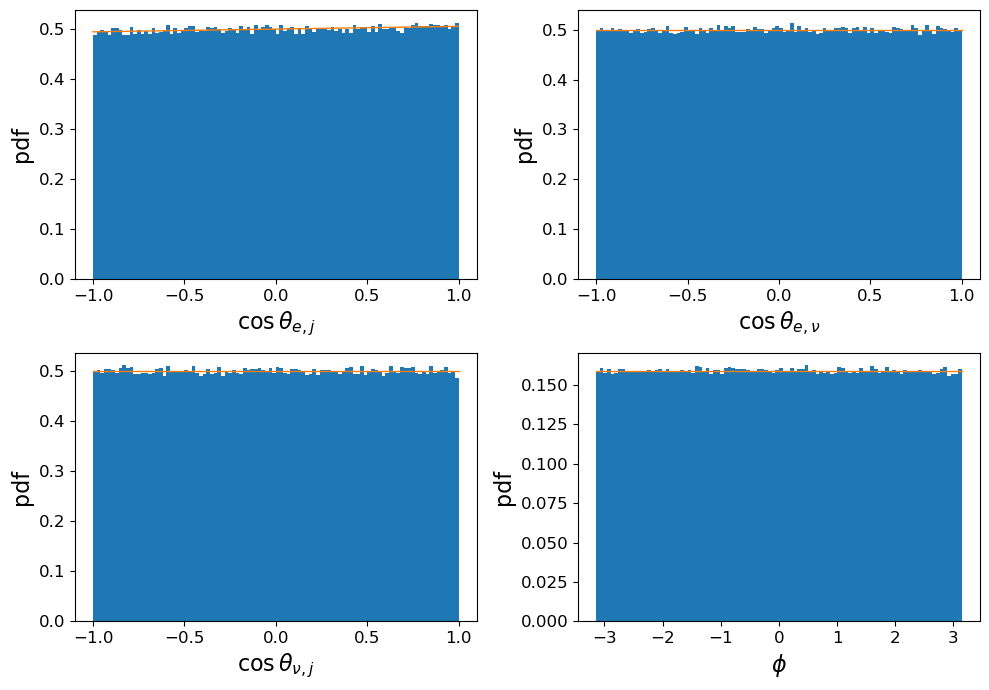

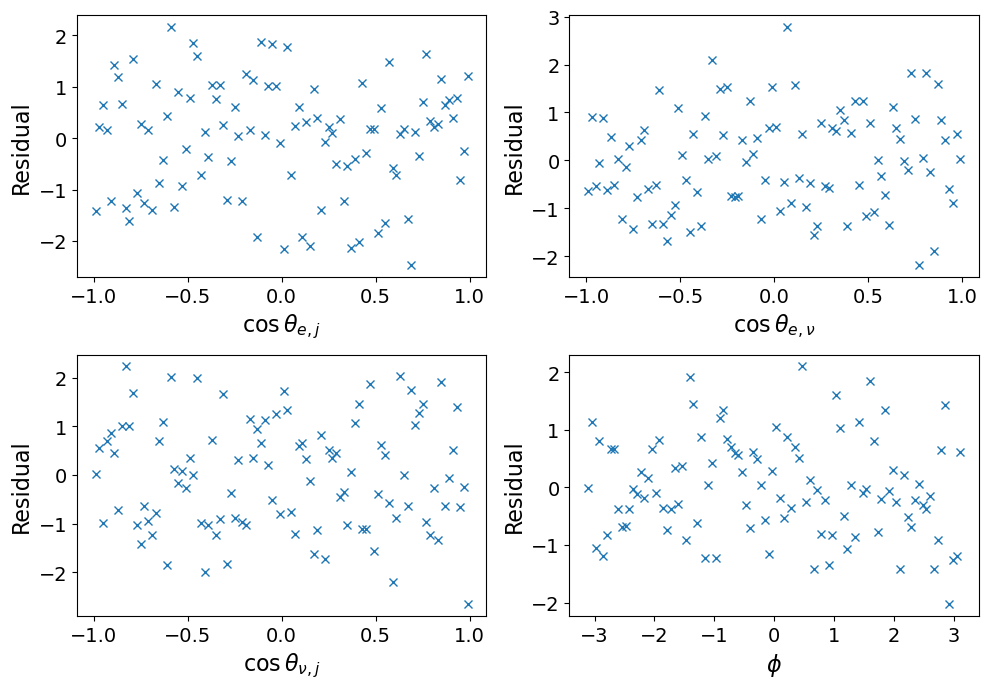

In [45]:
#ctcap

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5

def ctcap_imag(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2
    a = 0
    b = 0
    c = 0
    A = 2*coulombCorr*lambda_jj
    B = 0
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

ctcapIm_39Ca_polZpos = Ca39_data_analysis("build/39Ca_ctcap_imag.txt")
ctcapIm_39Ca_polZpos.event_mask()
ctcapIm_39Ca_polZpos.kinematical_data()
ctcapIm_39Ca_polZpos.kinematical_data_ref()
ctcapIm_39Ca_polZpos.theoretical_dist(ctcap_imag,numComp=True)
ctcapIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_ctcap_imag_hist",lwidth=1)
ctcapIm_39Ca_polZpos.plot_residuals(fileName="39Ca_ctcap_imag_res")

0.947036396365605 0.9618426222500726 0.9570518862068127 1.092229163935433


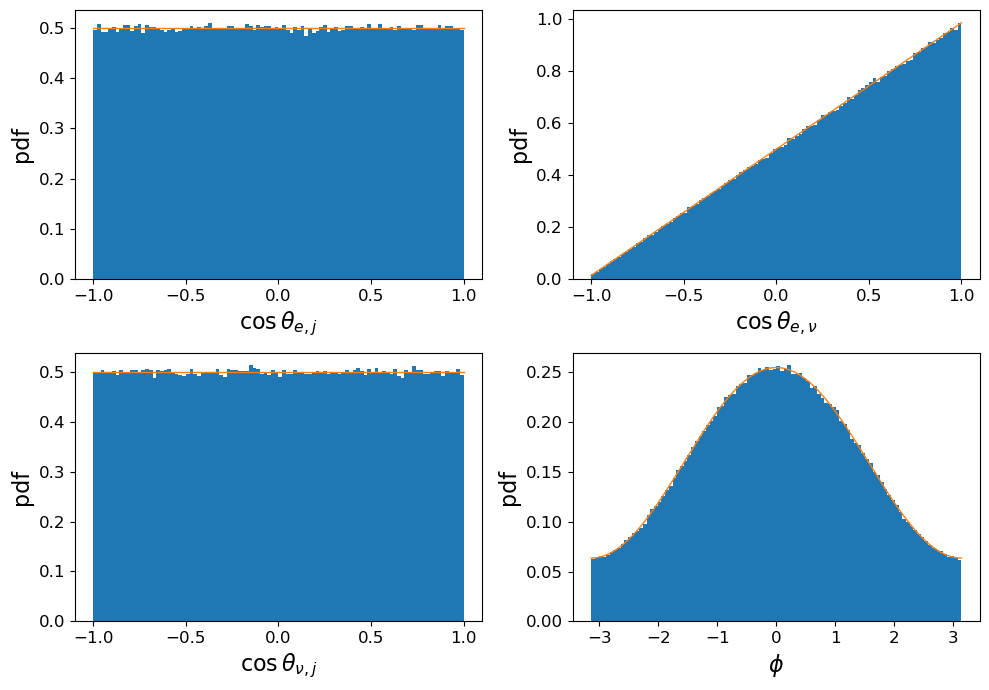

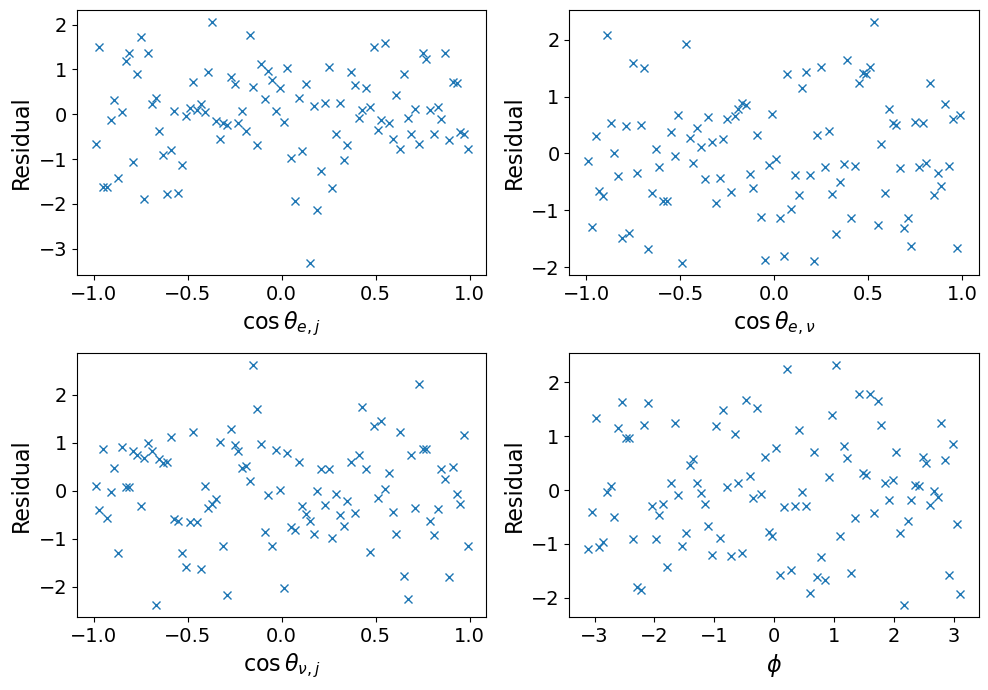

In [50]:
#cvcvp

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5

def cvcvp_real(E):
    xi = 2
    a = 2
    b = 0
    c = 0
    A = 0
    B = 0
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

cvcvpRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_cvcvp_real.txt")
cvcvpRe_39Ca_polZpos.event_mask()
cvcvpRe_39Ca_polZpos.kinematical_data()
cvcvpRe_39Ca_polZpos.kinematical_data_ref()
cvcvpRe_39Ca_polZpos.theoretical_dist(cvcvp_real,numComp=True)
cvcvpRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_cvcvp_real_hist",lwidth=1)
cvcvpRe_39Ca_polZpos.plot_residuals(fileName="39Ca_cvcvp_real_res")

0.9797808474085704 1.3041198952632298 0.9303317519213785 1.1239117365216762


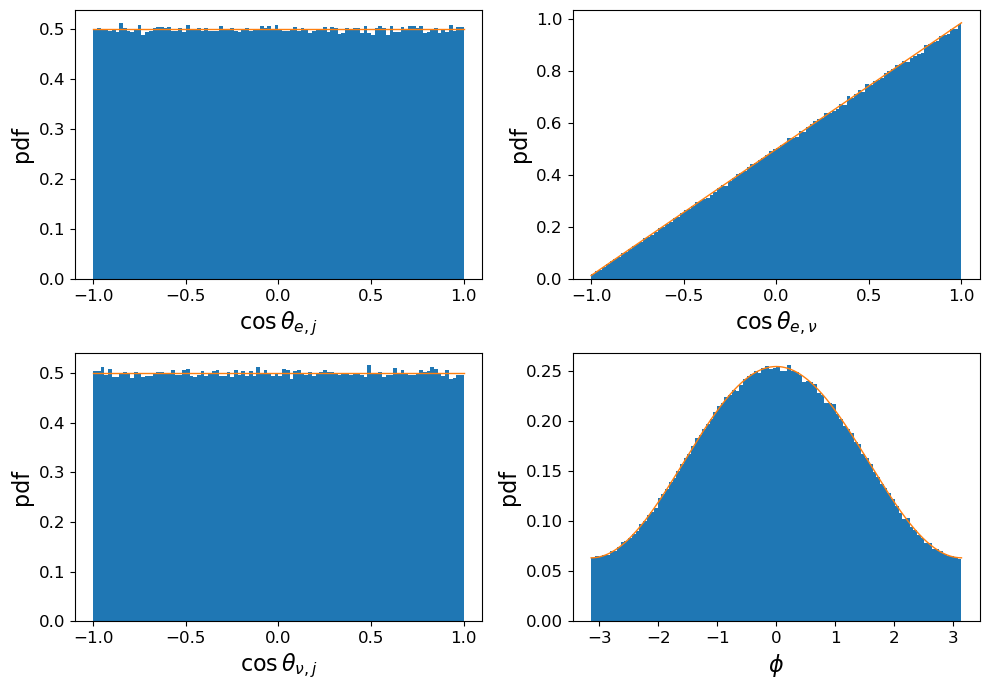

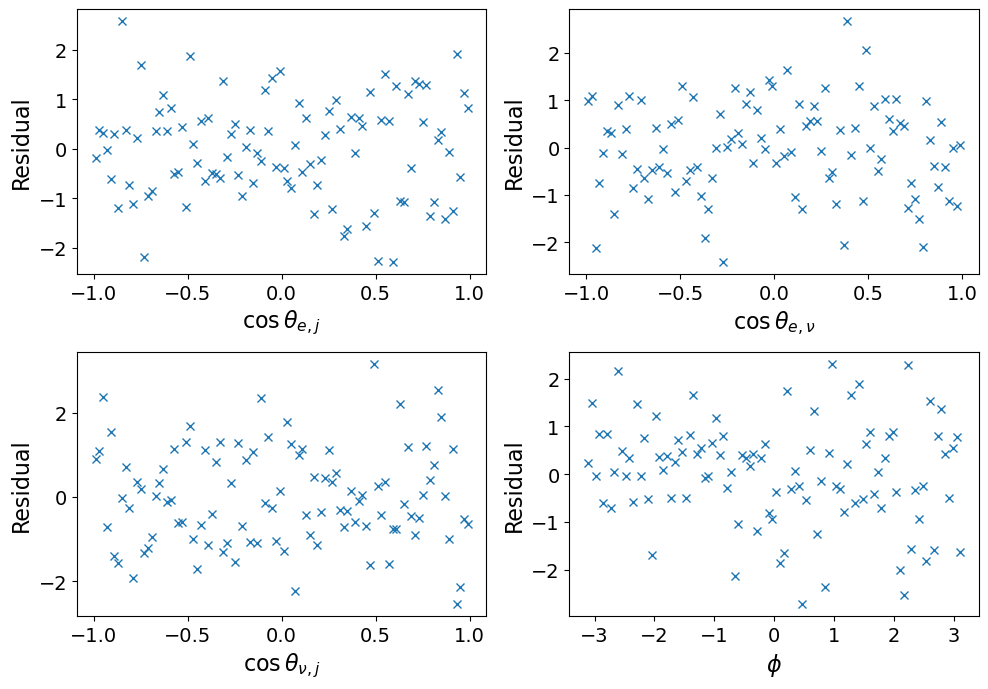

In [49]:
#cvcvp

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5

def cvcvp_imag(E):
    xi = 2
    a = 2
    b = 0
    c = 0
    A = 0
    B = 0
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

cvcvpIm_39Ca_polZpos = Ca39_data_analysis("build/39Ca_cvcvp_imag.txt")
cvcvpIm_39Ca_polZpos.event_mask()
cvcvpIm_39Ca_polZpos.kinematical_data()
cvcvpIm_39Ca_polZpos.kinematical_data_ref()
cvcvpIm_39Ca_polZpos.theoretical_dist(cvcvp_imag,numComp=True)
cvcvpIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_cvcvp_imag_hist",lwidth=1)
cvcvpIm_39Ca_polZpos.plot_residuals(fileName="39Ca_cvcvp_imag_res")

/tmp/ipykernel_5799/180552967.py:36: RuntimeWarning: divide by zero encountered in divide
  data_cosphi = (self.data_angle_elenu-self.cos_el*self.cos_enu)/sin_el/sin_enu
/tmp/ipykernel_5799/180552967.py:37: RuntimeWarning: divide by zero encountered in divide
  data_sinphi = z_cross_elenu/sin_el/sin_enu


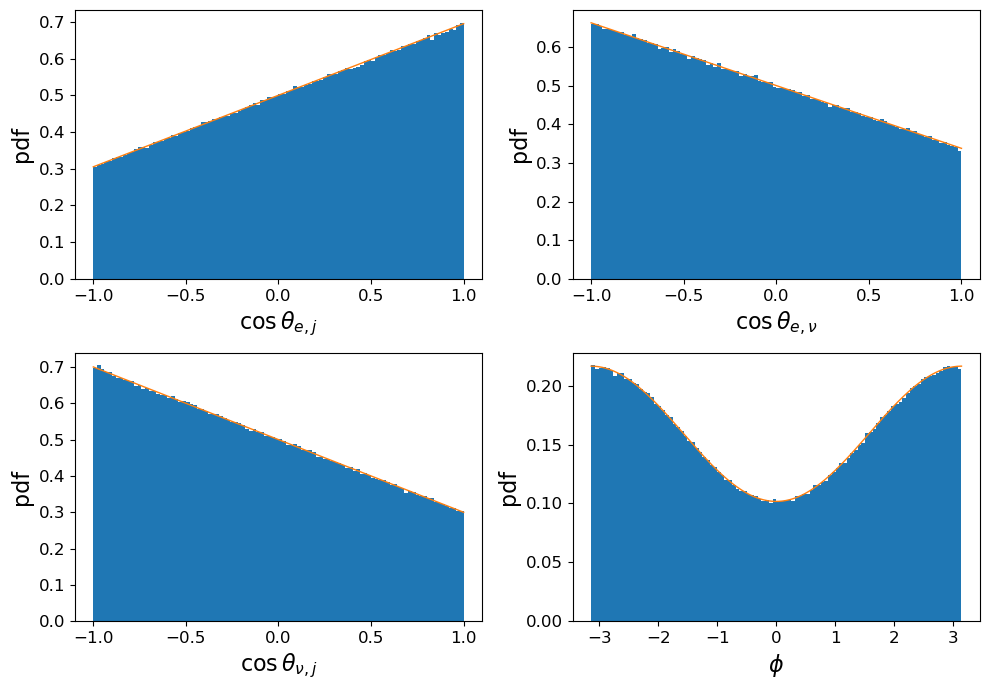

In [28]:
#cacap

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5

def cacap_real(E):
    xi = 2
    a = -2/3
    b = 0
    c = 2*Lambda_jj
    A = 2*lambda_jj
    B = -2*lambda_jj
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

SM_39Ca_polZpos = Ca39_data_analysis("build/39Ca_cacap_real.txt")
SM_39Ca_polZpos.event_mask()
SM_39Ca_polZpos.kinematical_data()
SM_39Ca_polZpos.kinematical_data_ref()
SM_39Ca_polZpos.theoretical_dist(cacap_real)
SM_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_cacap_real",lwidth=1)

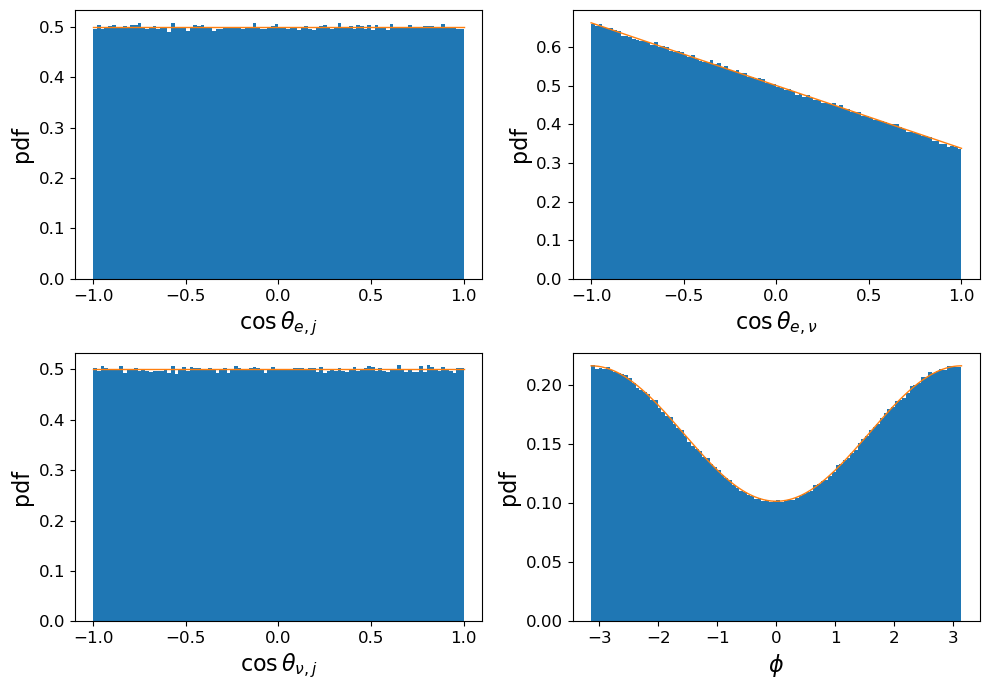

In [29]:
#cacap

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5

def cacap_imag(E):
    xi = 2
    a = -2/3
    b = 0
    c = 2*Lambda_jj
    A = 0
    B = 0
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

SM_39Ca_polZpos = Ca39_data_analysis("build/39Ca_cacap_imag.txt")
SM_39Ca_polZpos.event_mask()
SM_39Ca_polZpos.kinematical_data()
SM_39Ca_polZpos.kinematical_data_ref()
SM_39Ca_polZpos.theoretical_dist(cacap_imag)
SM_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_cacap_imag",lwidth=1)

0.8483528589582556 0.9922295498754469 1.1473824265991133 0.9875109672553272


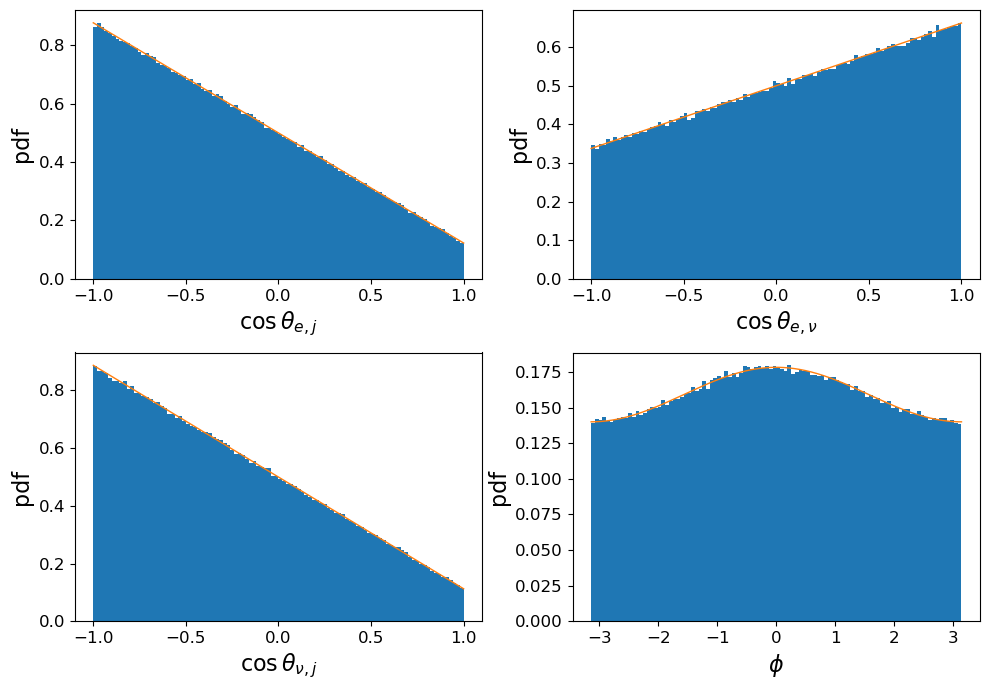

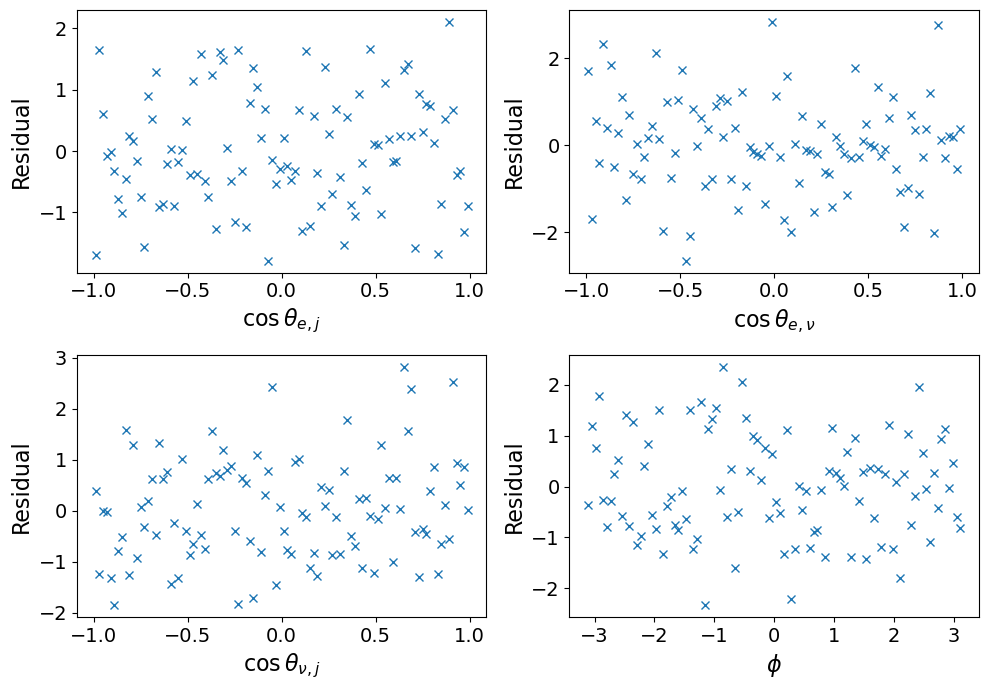

In [51]:
#cvcap

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5

def cvcap_real(E):
    xi = 2
    a = 1-1/3
    b = 0
    c = Lambda_jj
    A = -2*sqrt_jj
    B = -2*sqrt_jj
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

cvcapRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_cvcap_real.txt")
cvcapRe_39Ca_polZpos.event_mask()
cvcapRe_39Ca_polZpos.kinematical_data()
cvcapRe_39Ca_polZpos.kinematical_data_ref()
cvcapRe_39Ca_polZpos.theoretical_dist(cvcap_real,numComp=True)
cvcapRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_cvcap_real_hist",lwidth=1)
cvcapRe_39Ca_polZpos.plot_residuals(fileName="39Ca_cvcap_real_res")

1.096652178797201 0.8170517412978907 1.0431927168442383 1.057963996362354


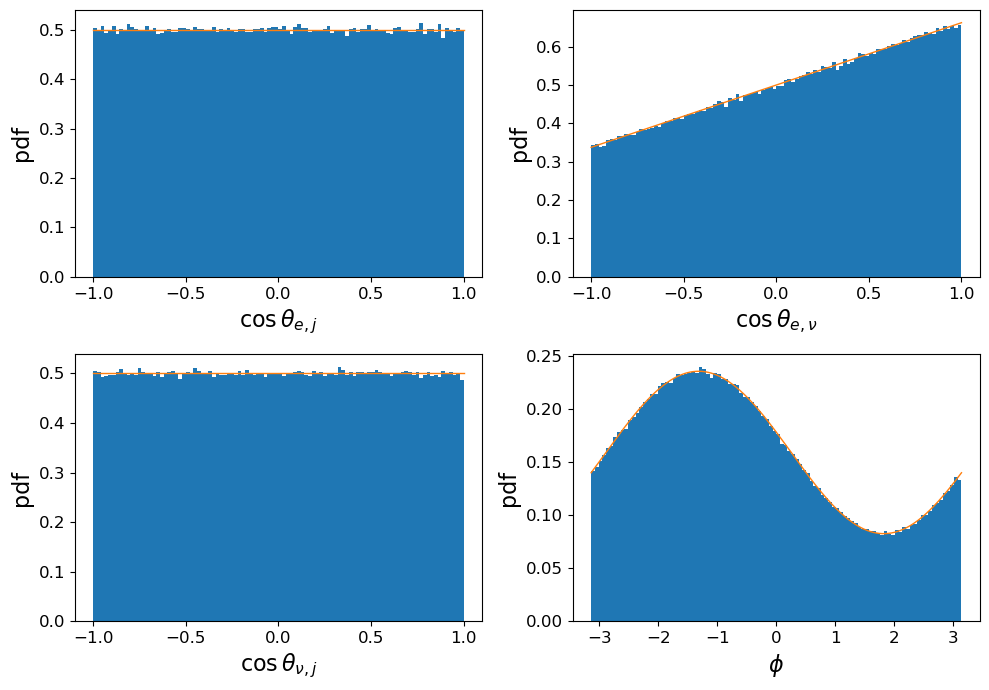

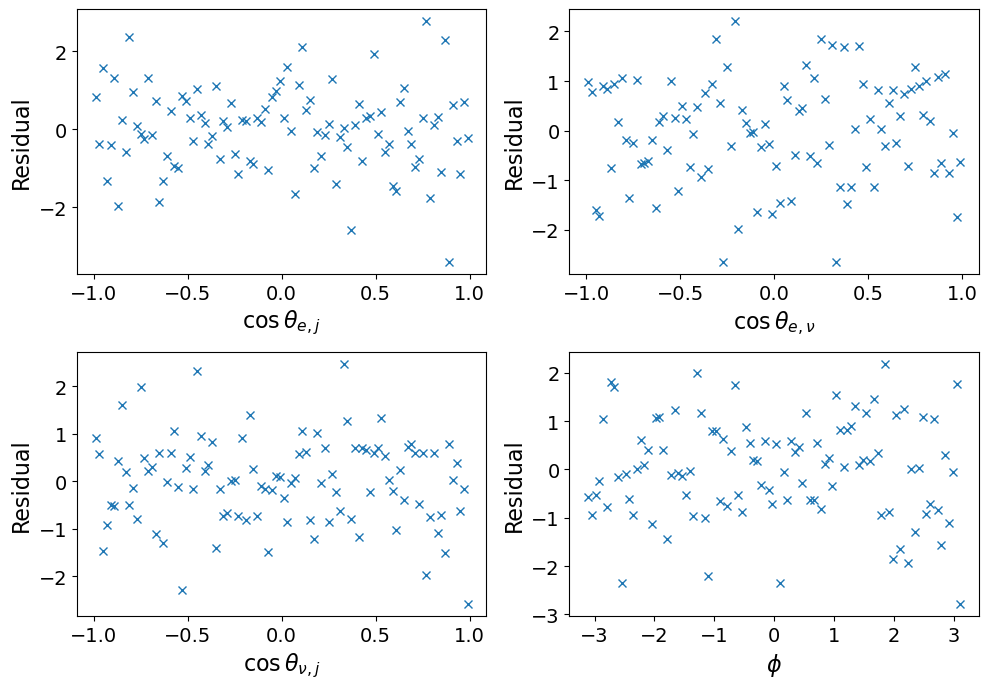

In [53]:
#cvca

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)
lambda_jj = 0.4
Lambda_jj = -4/5

def cvca_imag(E):
    xi = 2
    a = 1-1/3
    b = 0
    c = Lambda_jj
    A = 0
    B = 0
    D = -2*sqrt_jj
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

cvcaIm_39Ca_polZpos = Ca39_data_analysis("build/39Ca_cvca_imag.txt")
cvcaIm_39Ca_polZpos.event_mask()
cvcaIm_39Ca_polZpos.kinematical_data()
cvcaIm_39Ca_polZpos.kinematical_data_ref()
cvcaIm_39Ca_polZpos.theoretical_dist(cvca_imag,numComp=True)
cvcaIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_cvca_imag_hist",lwidth=1)
cvcaIm_39Ca_polZpos.plot_residuals(fileName="39Ca_cvca_imag_res")

cs csp real


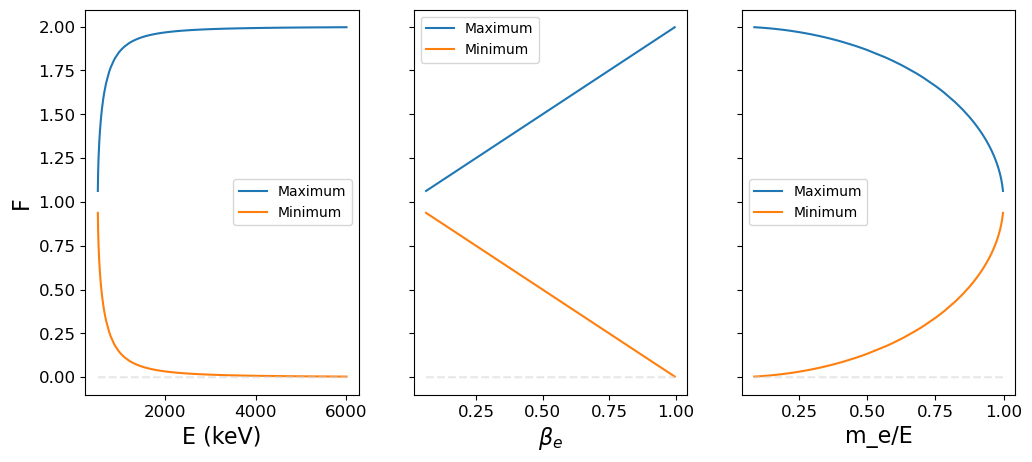

ct ctp real


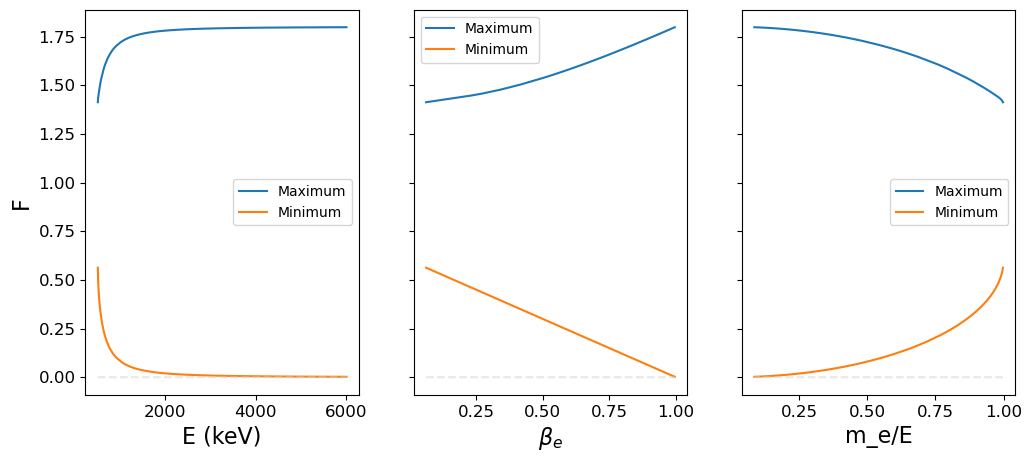

cv cvp real


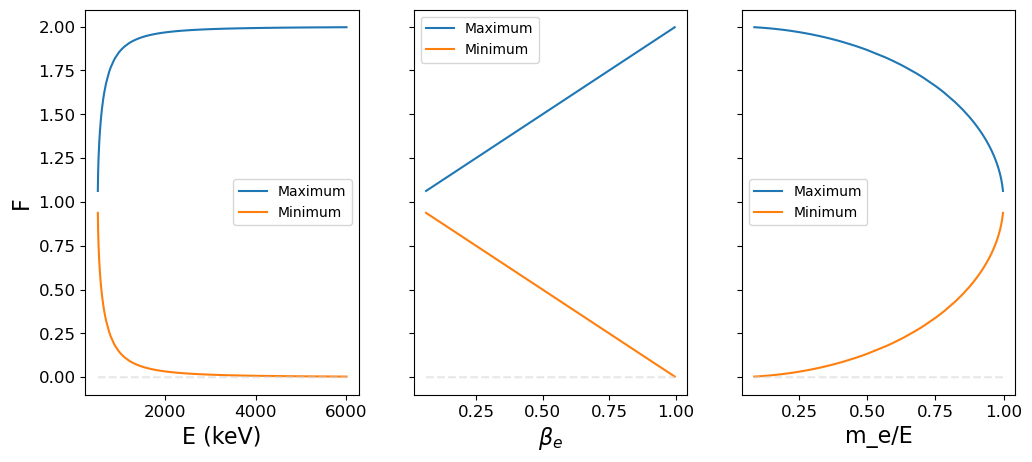

ca cap real


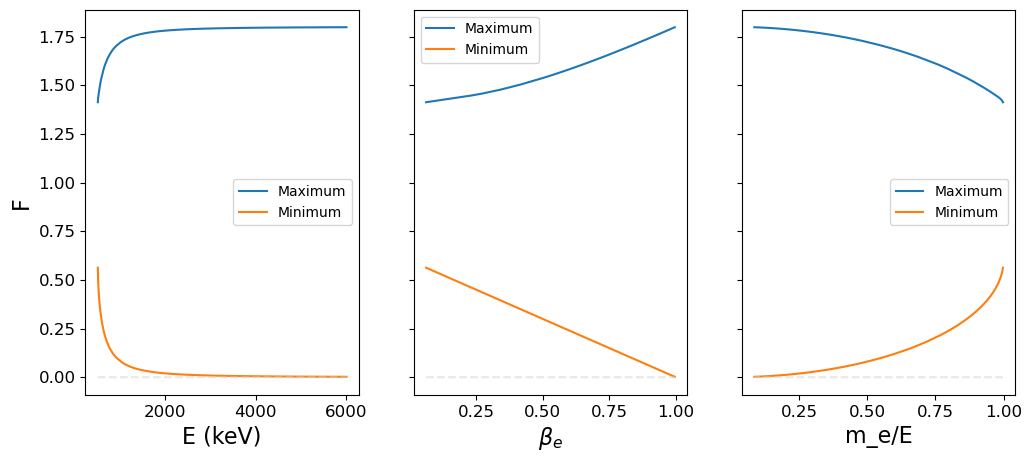

cs ctp real


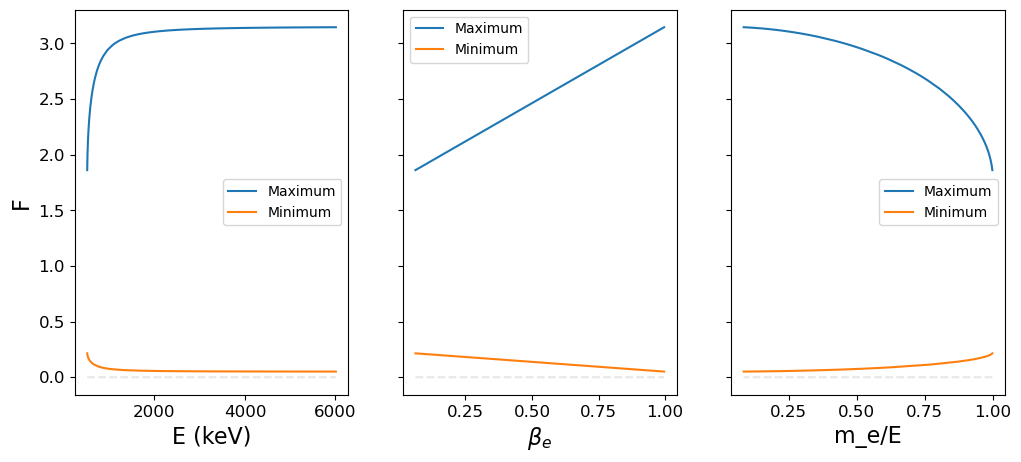

cs ca real


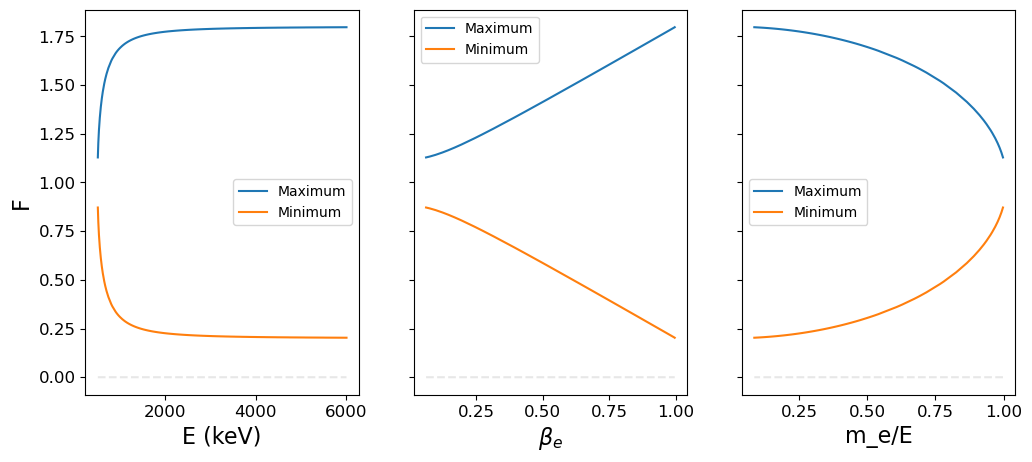

cs cap real


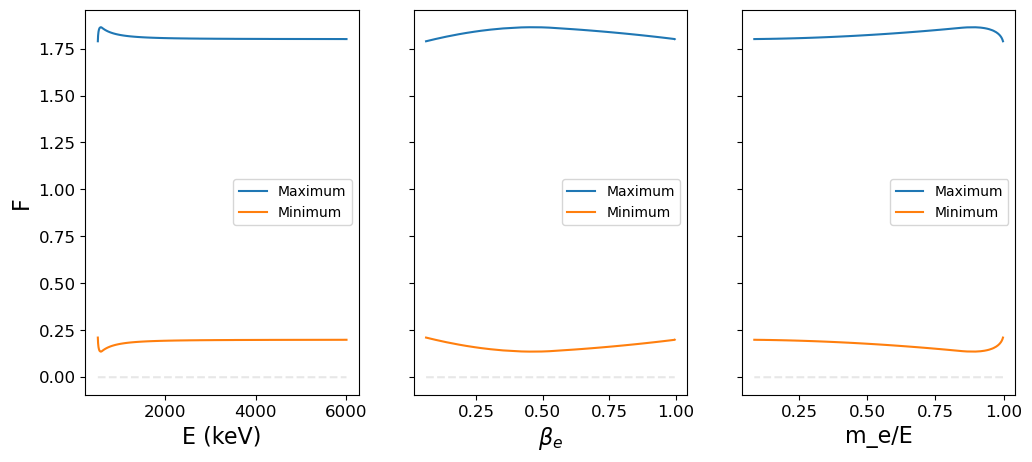

csp ct real


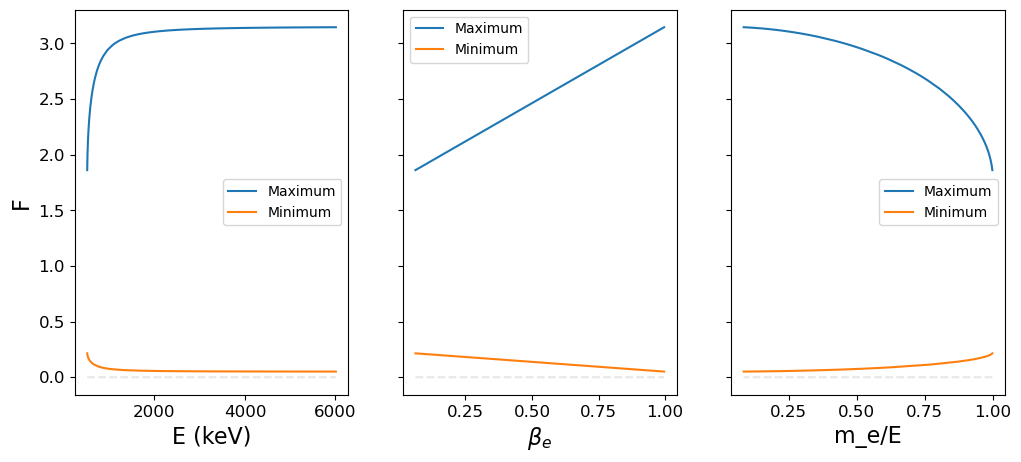

csp ca real


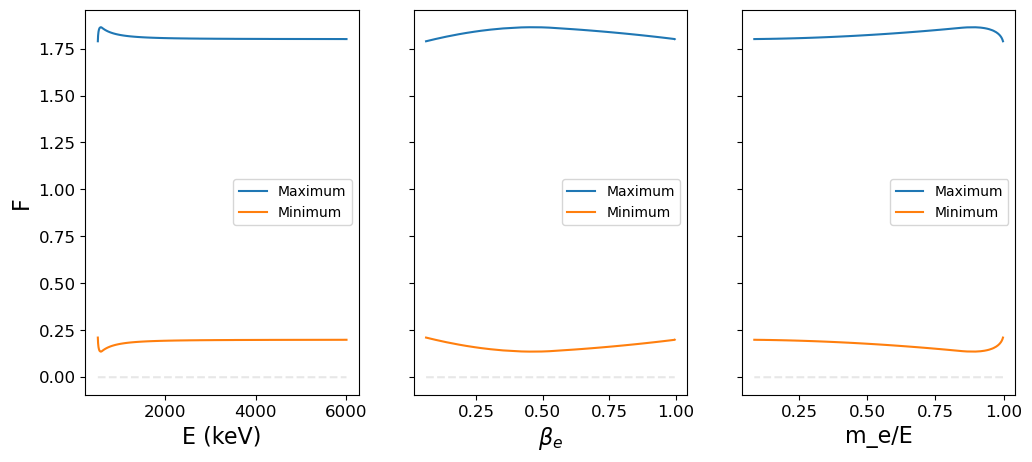

csp cap real


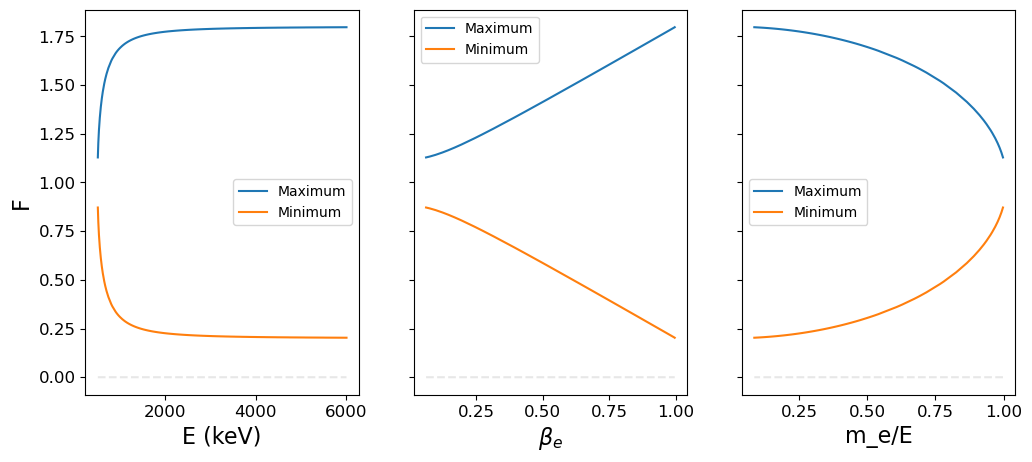

ct cv real


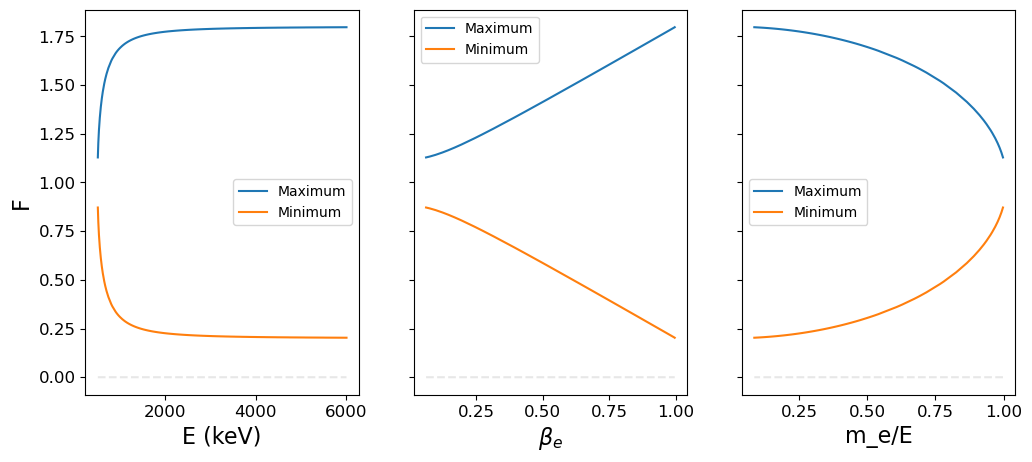

ct cvp real


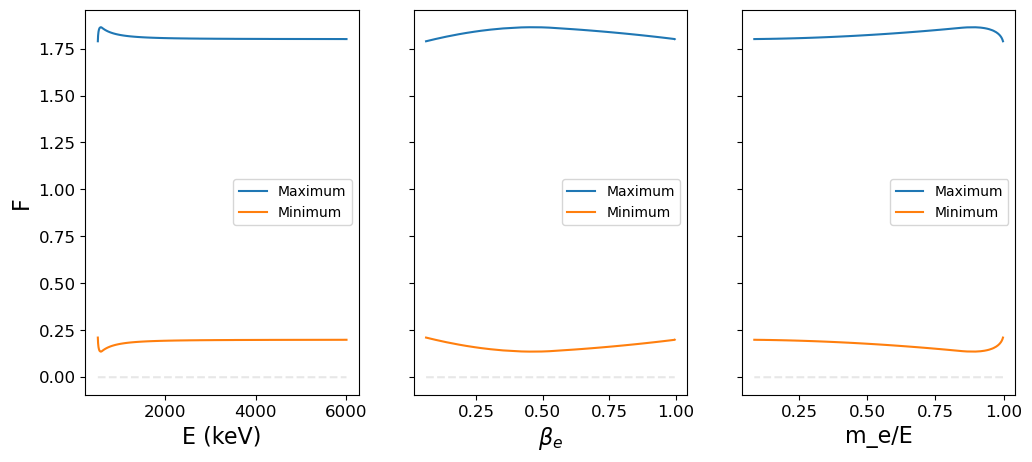

ct cap real


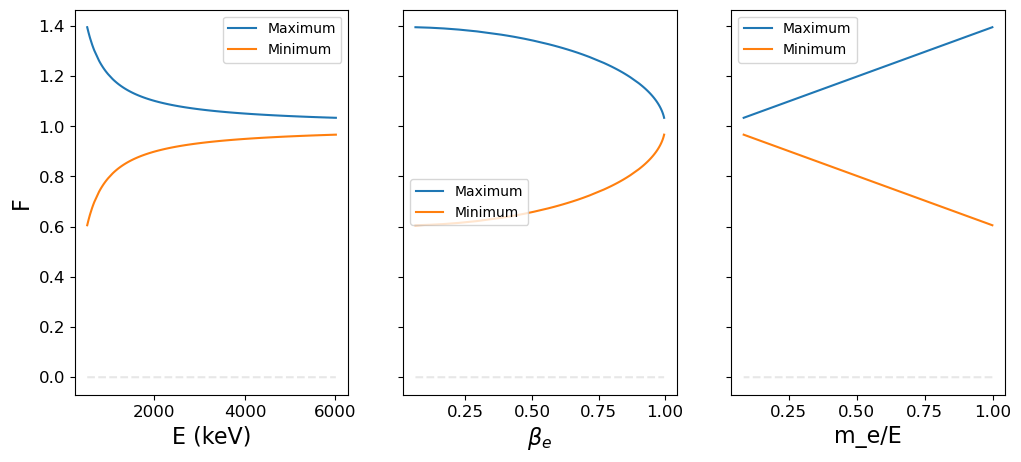

ctp cv real


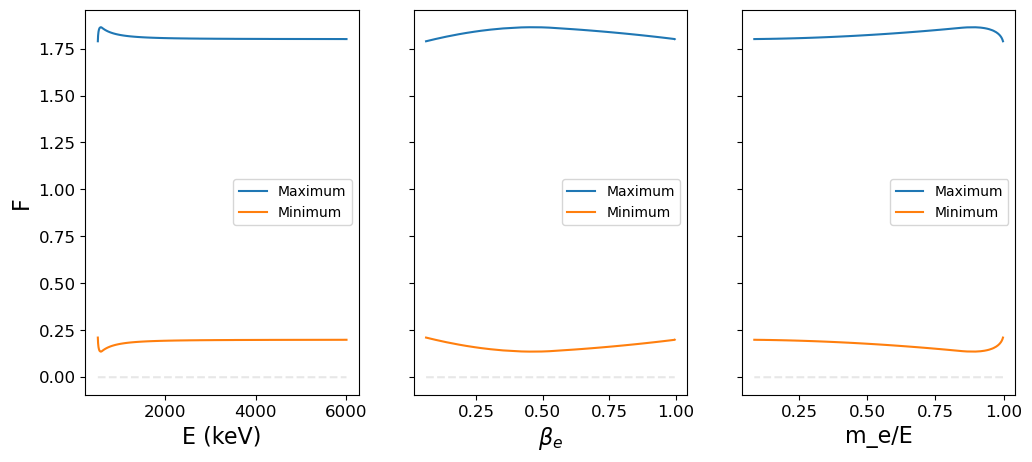

ctp cvp real


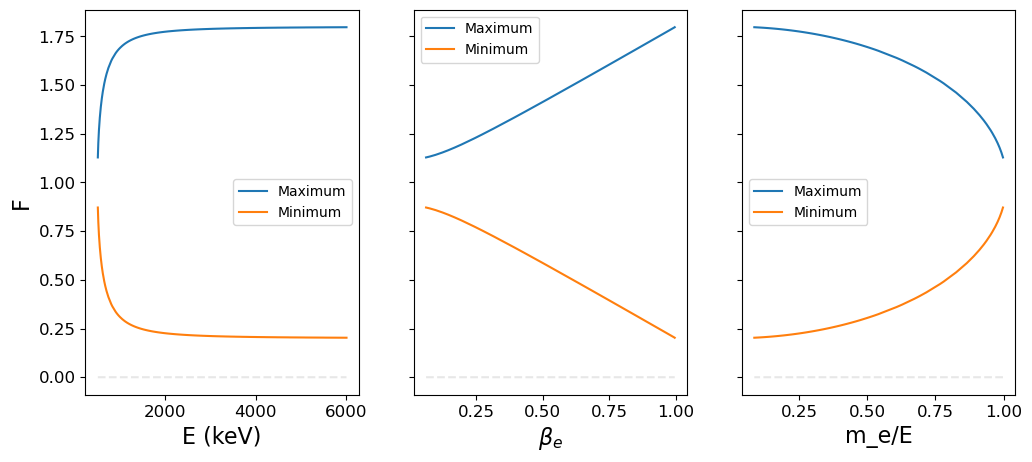

ctp ca real


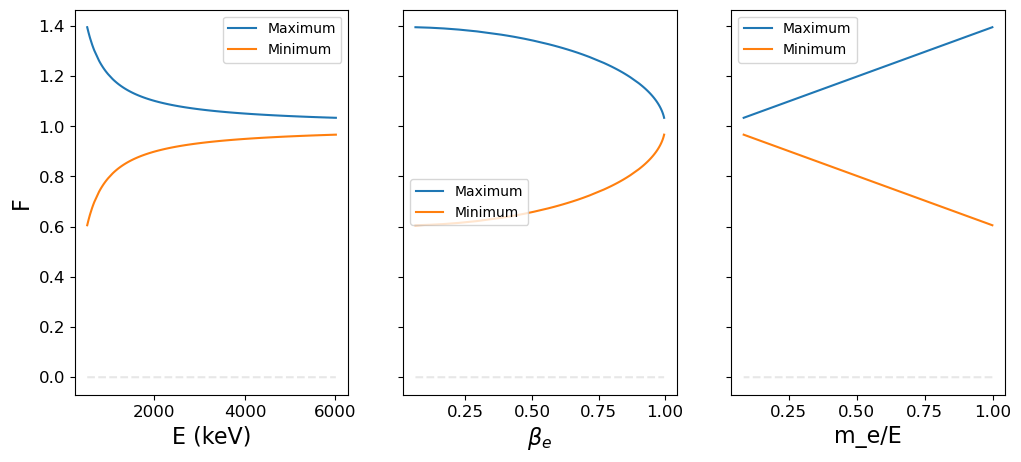

cv cap real


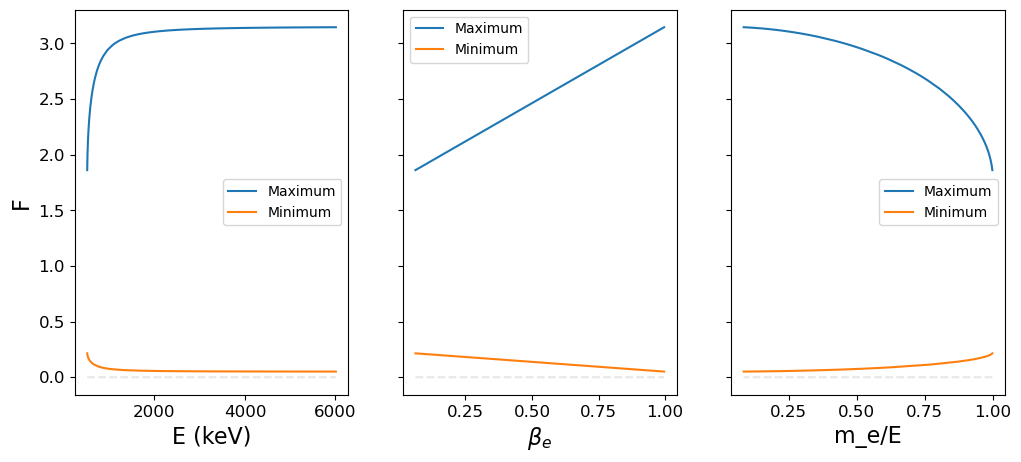

cvp ca real


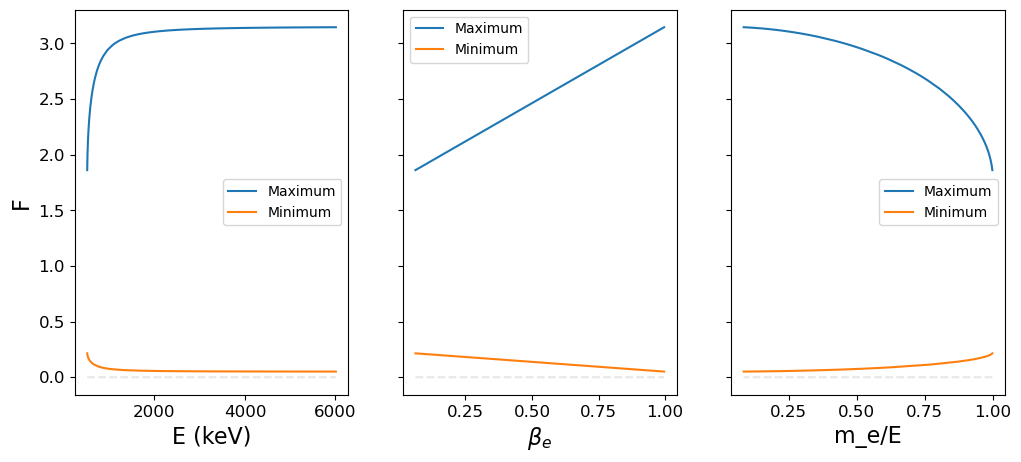

cs csp imag


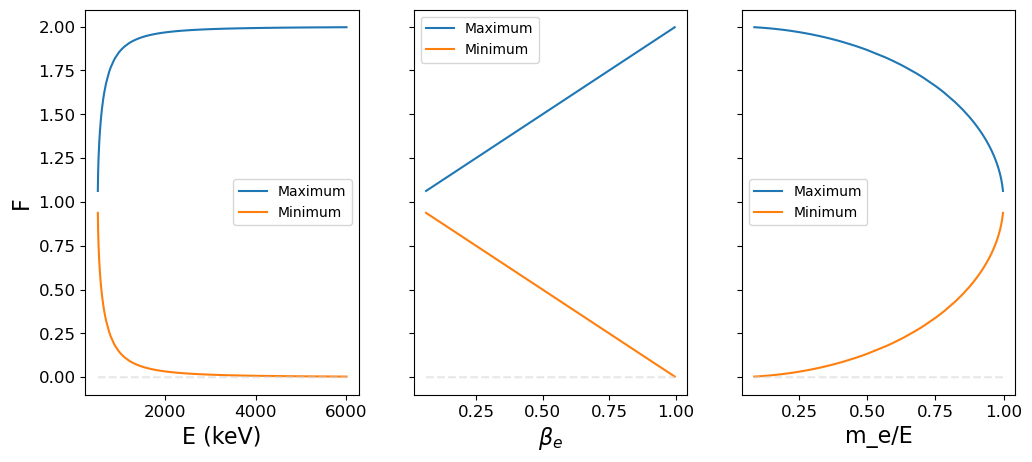

ct ctp imag


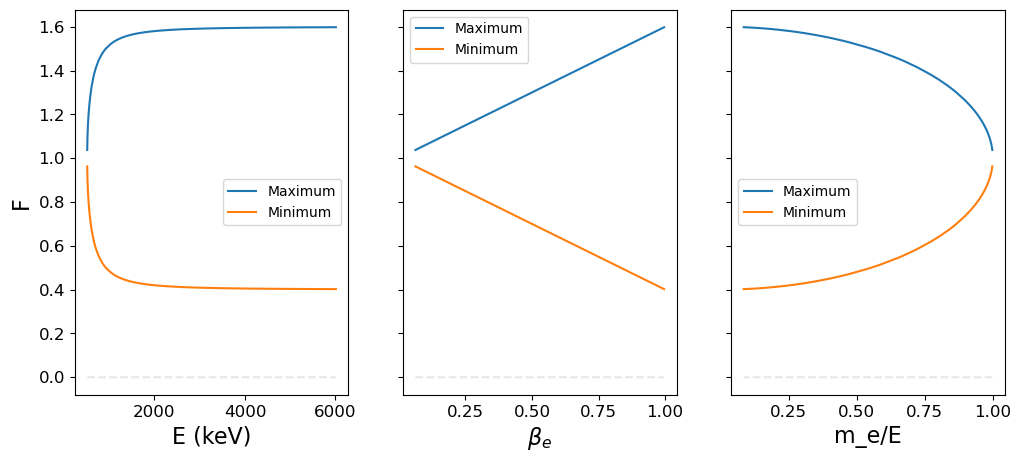

cv cvp imag


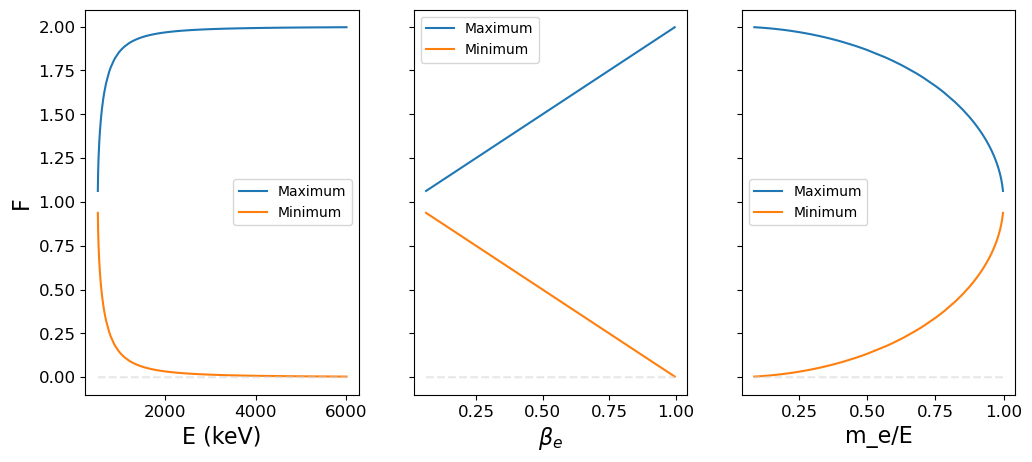

ca cap imag


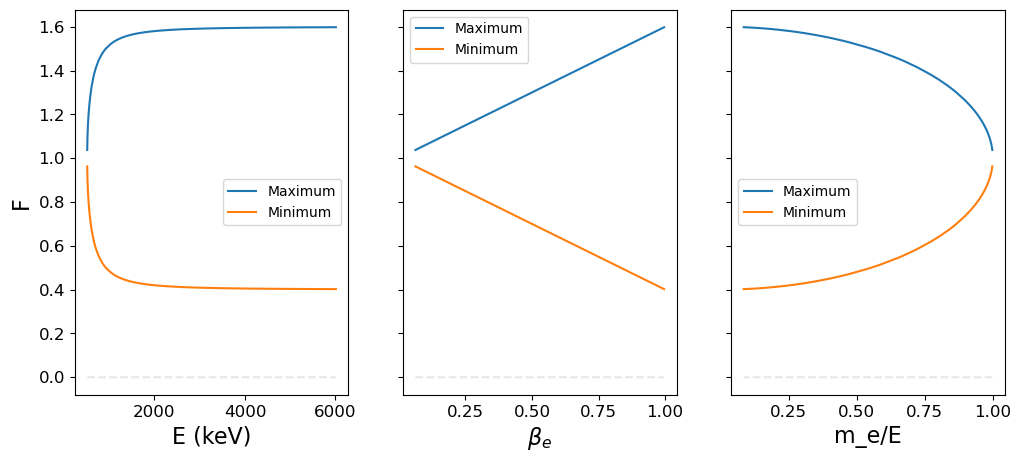

cs ct imag


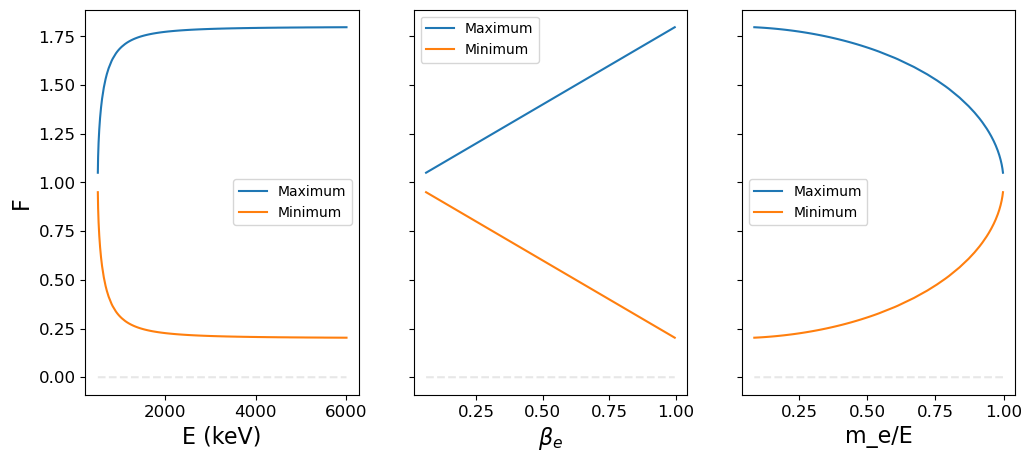

cs cap imag


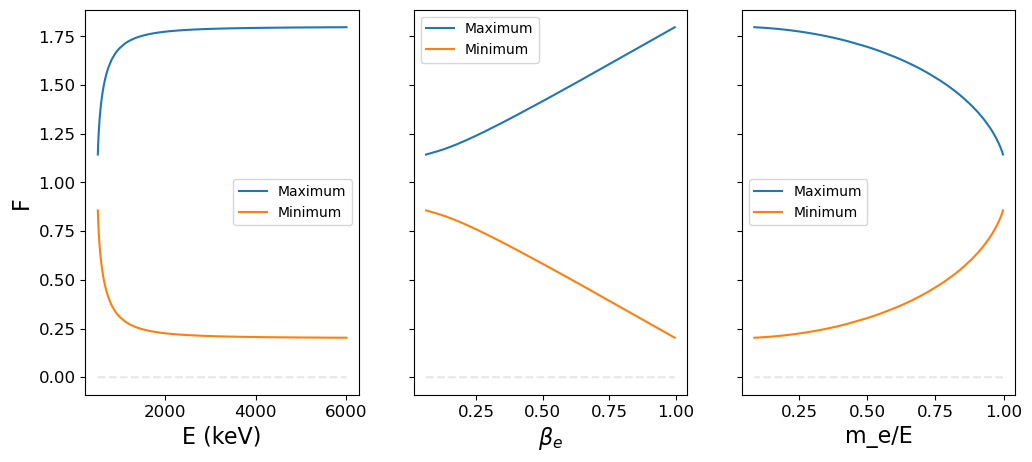

csp ctp imag


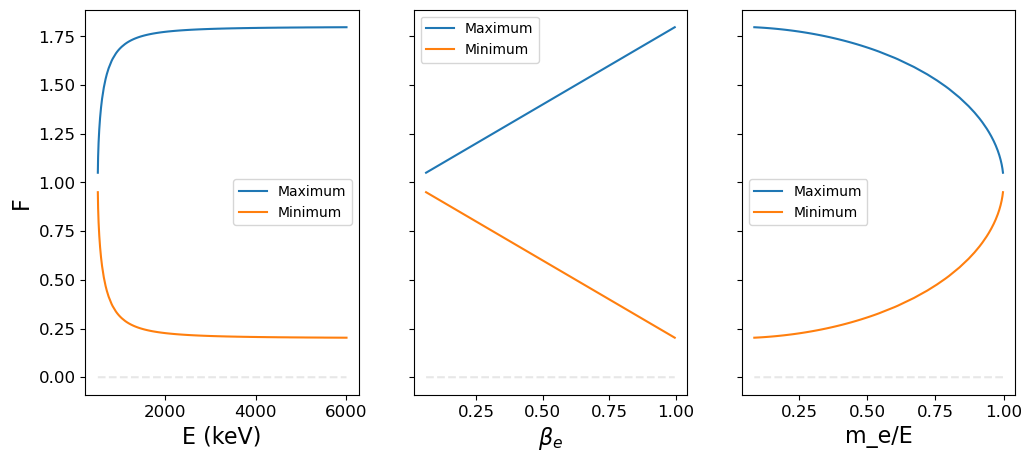

csp ca imag


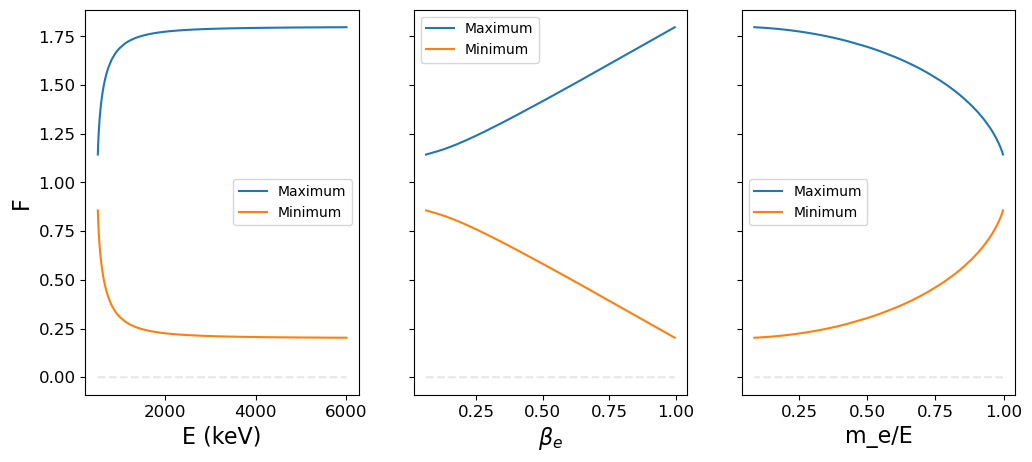

ct cvp imag


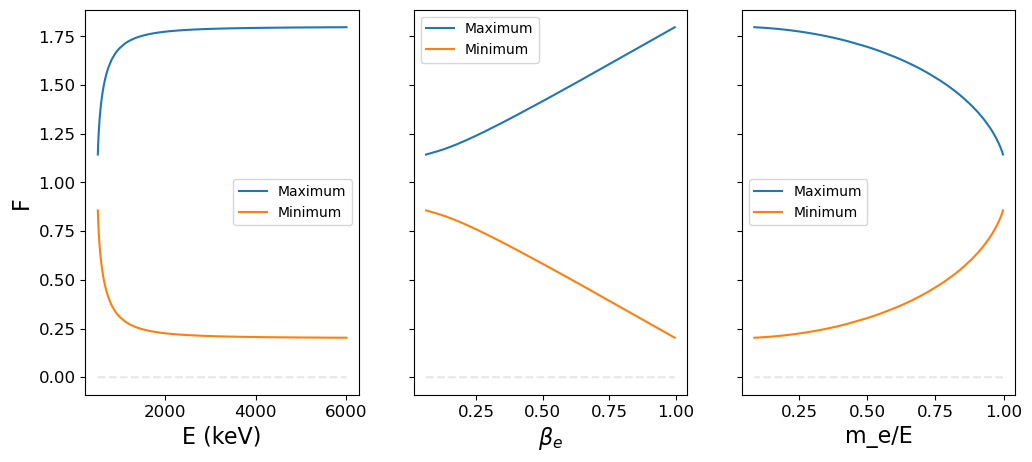

ct cap imag


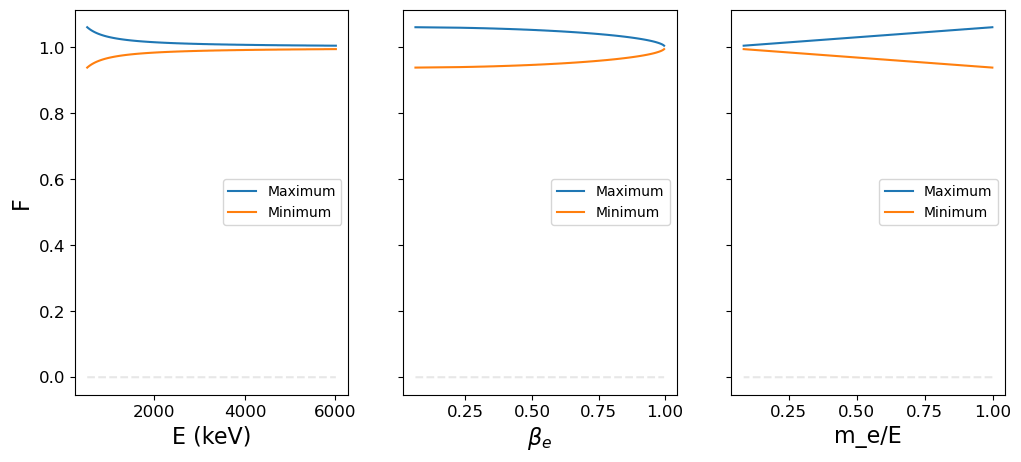

ctp cv imag


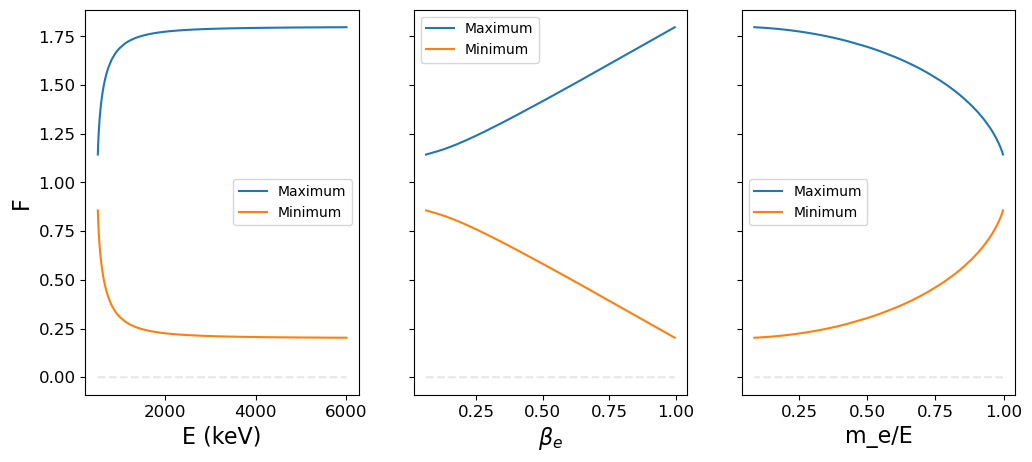

ctp ca imag


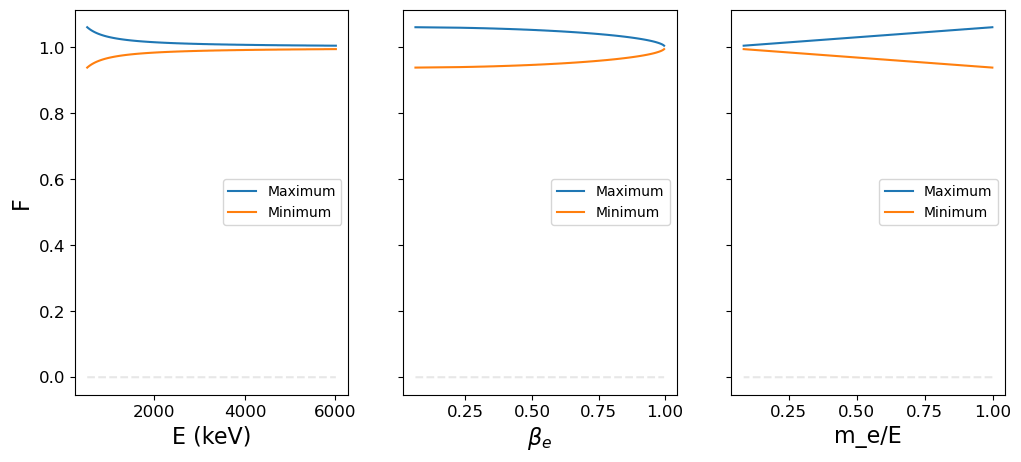

cv ca imag


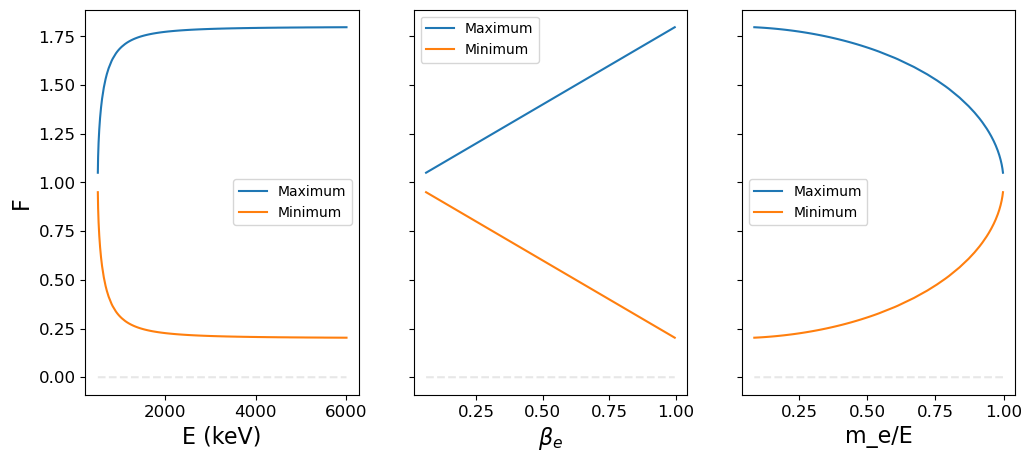

cvp cap imag


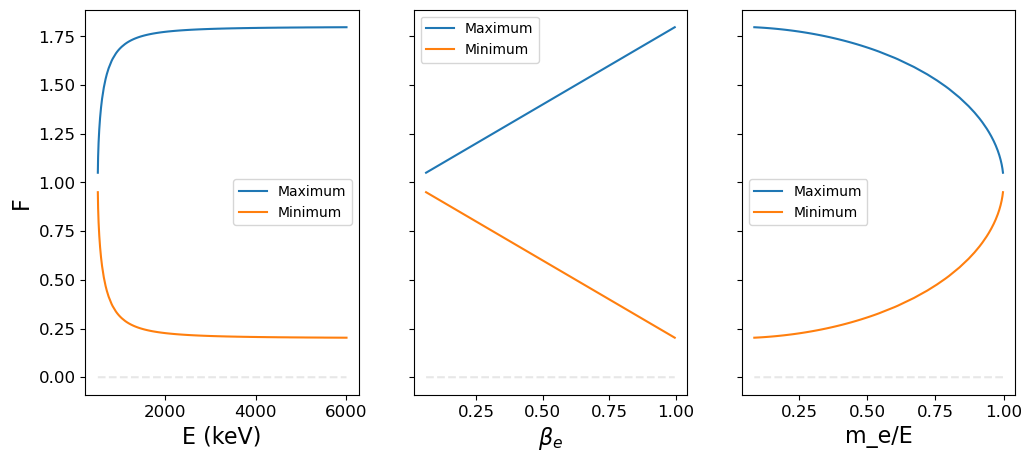

In [15]:
ccNames = ["cs","csp","ct","ctp","cv","cvp","ca","cap"]
real_interest = [(0,1),(2,3),(4,5),(6,7),(0,3),(0,6),(0,7),(1,2),(1,6),(1,7),(2,4),(2,5),(2,7),(3,4),(3,5),
                 (3,6),(4,7),(5,6)]
complex_interest = [(0,1),(2,3),(4,5),(6,7),(0,2),(0,7),(1,3),(1,6),(2,5),(2,7),(3,4),(3,6),(4,6),(5,7)]

for pair in real_interest:
    i, j = pair
    print(ccNames[i],ccNames[j],"real")
    inputFile = f"build/39Ca_{ccNames[i]}{ccNames[j]}_minmaxf_real.txt"
    outputFile = f"plots/39Ca_{ccNames[i]}{ccNames[j]}_minmaxf_real.pdf"
    minmax_f_plot(iFile=inputFile,oFile=outputFile)
for pair in complex_interest:
    i, j = pair
    print(ccNames[i],ccNames[j],"imag")
    inputFile = f"build/39Ca_{ccNames[i]}{ccNames[j]}_minmaxf_imag.txt"
    outputFile = f"plots/39Ca_{ccNames[i]}{ccNames[j]}_minmaxf_imag.pdf"
    minmax_f_plot(iFile=inputFile,oFile=outputFile)

(0.594576644552252, 0.0, -0.24325401326864876, -0.5910195457768667, -0.8342735590455154, 0)
-1.0649315477925323


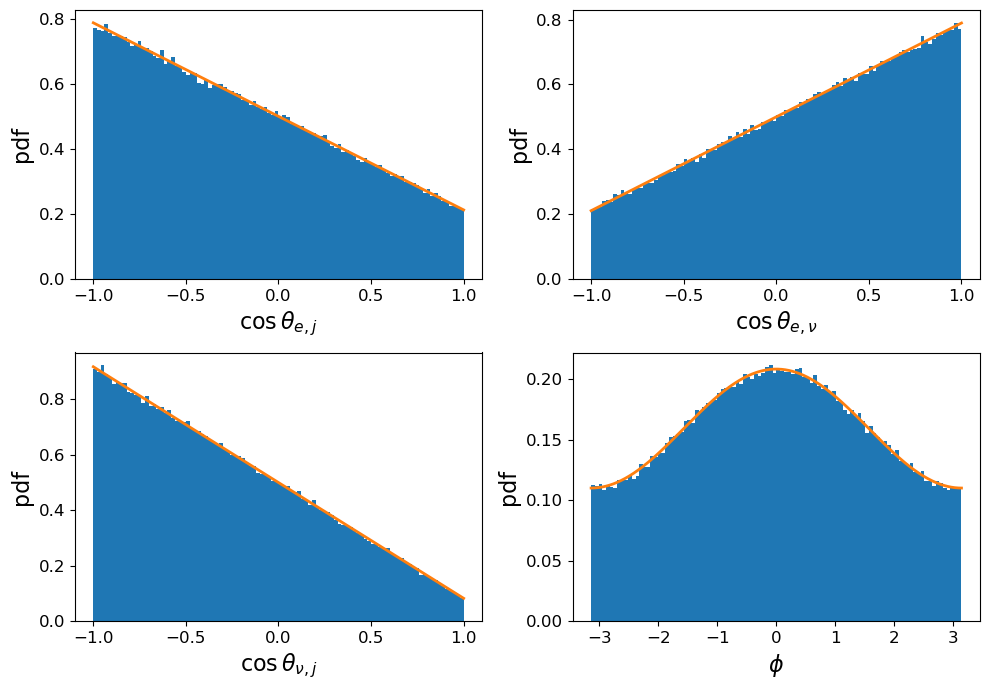

In [33]:
#Standard Model Mixed

alpha = 0.0072973525664
Z = 19 #need Z of daughter nuclei, 39K
gamma = np.sqrt(1-Z**2*alpha**2)

cv = 1
ca = 0.661
lambda_jj = 0.4
Lambda_jj = -4/5

def SM_coeffs(E):
    xi = 2*(cv**2+ca**2)
    a = 2*cv**2-2/3*ca**2
    b = 0
    c = Lambda_jj*2*ca**2
    A = lambda_jj*2*ca**2-np.sqrt(3/5)*4*cv*ca
    B = -lambda_jj*2*ca**2-np.sqrt(3/5)*4*cv*ca
    return (a/xi, b/xi, c/xi, A/xi, B/xi, 0)

a, b, c, A, B, D = SM_coeffs(mass_e)
print((a, b, c, A, B, D))
print(-abs(A)-abs(B)+abs(a-2*c)/3)
   
SM_39Ca_polZpos = Ca39_data_analysis("build/39Ca_polZpos_SM.txt")
SM_39Ca_polZpos.event_mask()
SM_39Ca_polZpos.kinematical_data()
SM_39Ca_polZpos.kinematical_data_ref()
SM_39Ca_polZpos.theoretical_dist(SM_coeffs)
SM_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100,fileName="39Ca_SM_hists")

(0.5736694322781583, -0.20955468393099835, -0.1597627536860059, -0.5437204549636255, -0.7048380836441172, 0.006662745349686358)


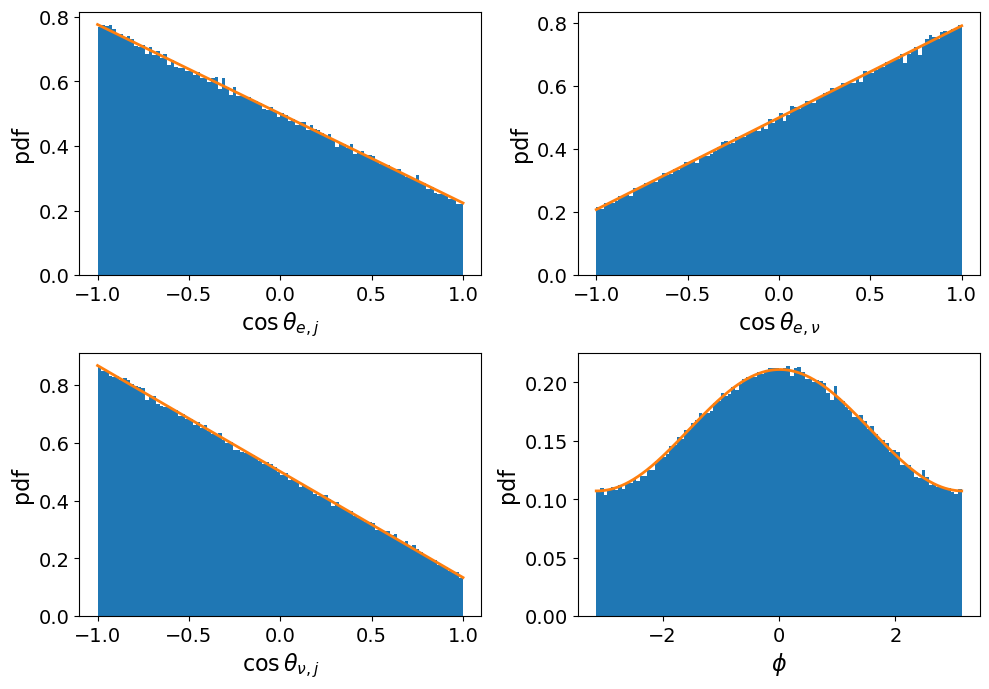

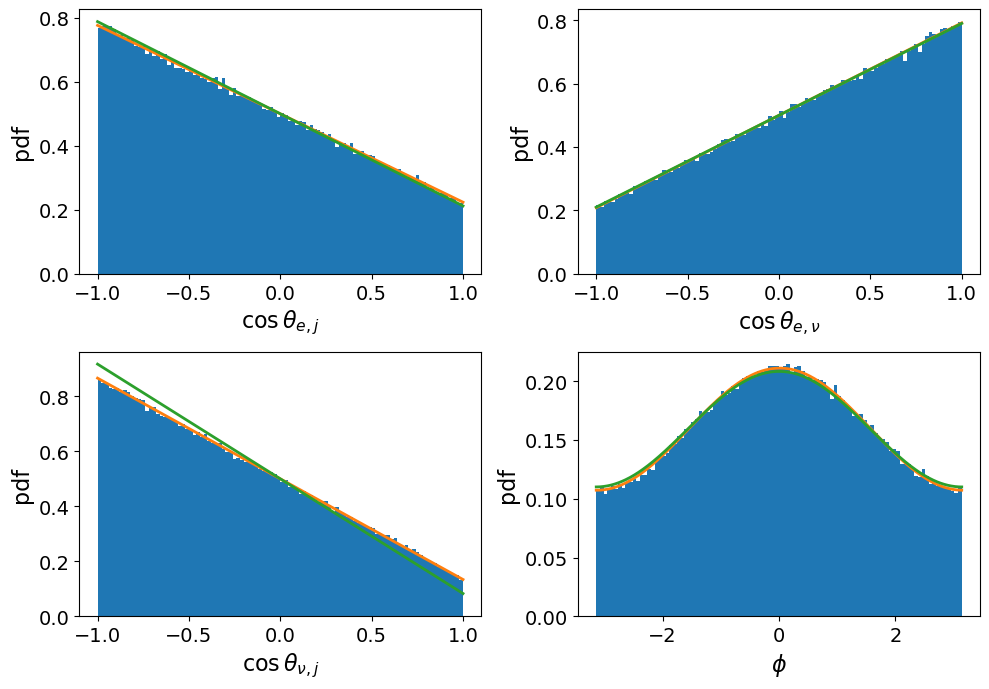

In [9]:
ct = 0.5
Q = 6524.49

def ctre_coeffs(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2*(cv**2+ca**2)+ct**2
    a = 2*cv**2+1/3*(ct**2-2*ca**2)
    b = -2*gamma*ct*ca
    c = Lambda_jj*(2*ca**2-ct**2)
    A = lambda_jj*2*ca**2-np.sqrt(3/5)*4*cv*ca
    B = -lambda_jj*(2*ca**2-2*gamma*mass_e/E*ca*ct)-np.sqrt(3/5)*(4*cv*ca-2*gamma*mass_e/E*cv*ct)
    D = np.sqrt(3/5)*2*cv*ct*coulombCorr
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

a, b, c, A, B, D = ctre_coeffs(mass_e+Q/3)
print((a, b, c, A, B, D))
   
CTRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_polZpos_ctRe.txt")
CTRe_39Ca_polZpos.event_mask()
CTRe_39Ca_polZpos.kinematical_data()
CTRe_39Ca_polZpos.kinematical_data_ref()
CTRe_39Ca_polZpos.theoretical_dist(ctre_coeffs)
CTRe_39Ca_polZpos.theoretical_dist2(SM_coeffs)
CTRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100)
CTRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,compareTheory=True,
                                               bins=100,fileName="39Ca_CTRe_hists")

(0.5717742202919189, 0.0, -0.16431126245298042, -0.5481089459298247, -0.7675069332810309, 0.0)


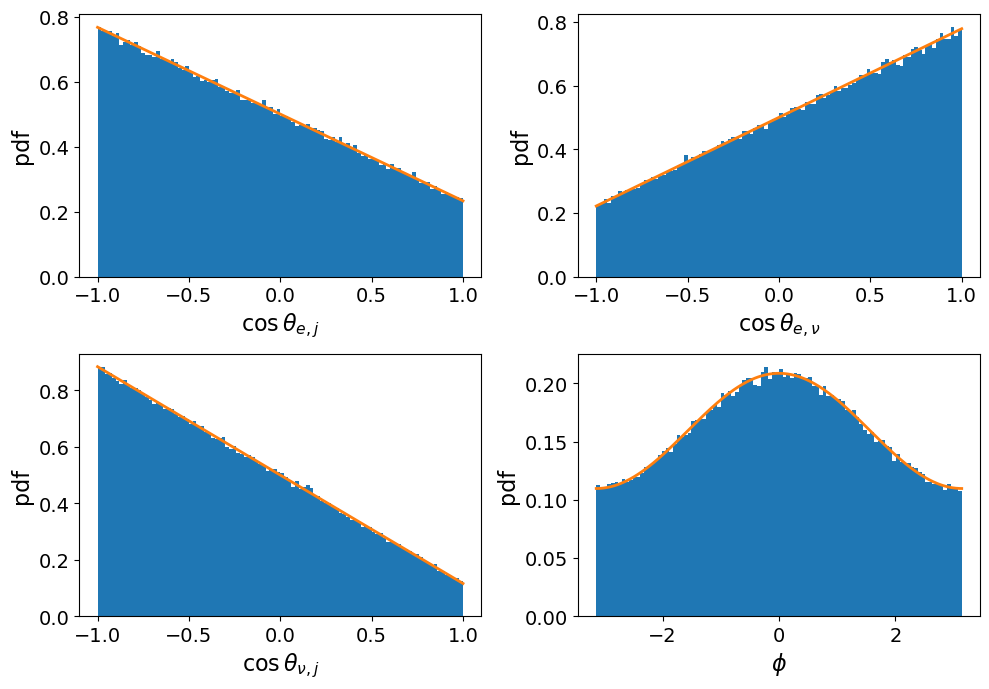

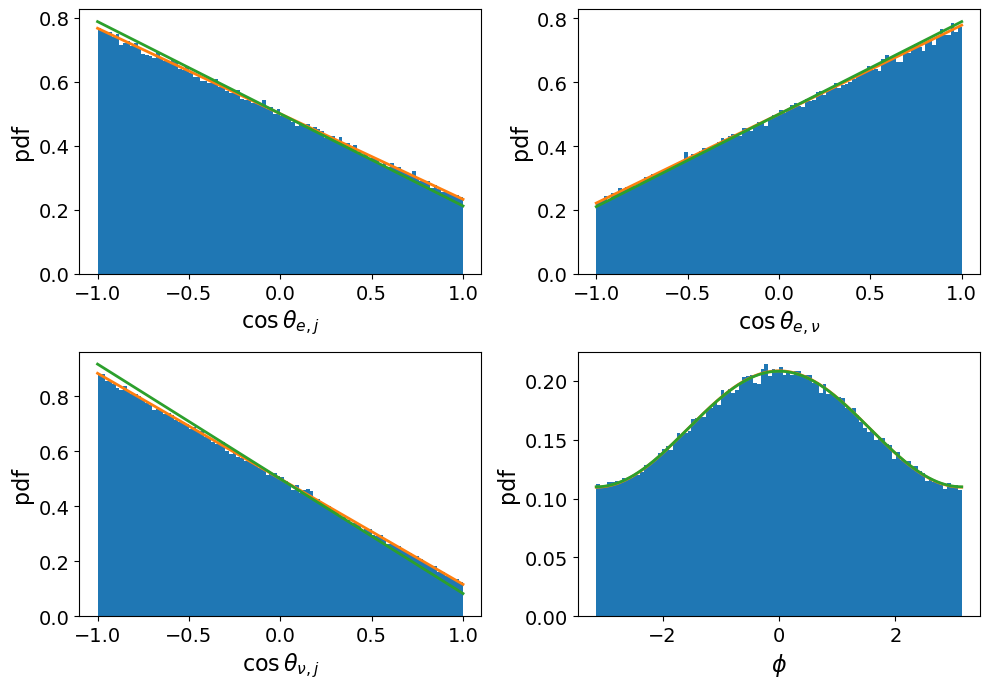

In [10]:
ct = 0.5
Q = 6524.49
Z = 19

def ctIm_coeffs(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2*(cv**2+ca**2)+ct**2
    a = 2*cv**2+1/3*(ct**2-2*ca**2-2*ct*ca*coulombCorr)
    b = 0
    c = Lambda_jj*(2*ca**2-ct**2+2*ct*ca*coulombCorr)
    A = lambda_jj*(2*ca**2+2*ca*ct*coulombCorr)-np.sqrt(3/5)*(4*cv*ca+2*cv*ct*coulombCorr)
    B = -lambda_jj*(2*ca**2)-np.sqrt(3/5)*(4*cv*ca)
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

a, b, c, A, B, D = ctIm_coeffs(mass_e+Q/3)
print((a, b, c, A, B, D))
   
CTIm_39Ca_polZpos = Ca39_data_analysis("build/39Ca_polZpos_ctIm.txt")
CTIm_39Ca_polZpos.event_mask()
CTIm_39Ca_polZpos.kinematical_data()
CTIm_39Ca_polZpos.kinematical_data_ref()
CTIm_39Ca_polZpos.theoretical_dist(ctIm_coeffs)
CTIm_39Ca_polZpos.theoretical_dist2(SM_coeffs)
CTIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100)
CTIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,compareTheory=True,
                                               bins=100,fileName="39Ca_CTIm_hists")

(0.5736694322781583, -0.20955468393099835, -0.1597627536860059, -0.5437204549636255, -0.7048380836441172, 0.006662745349686358)


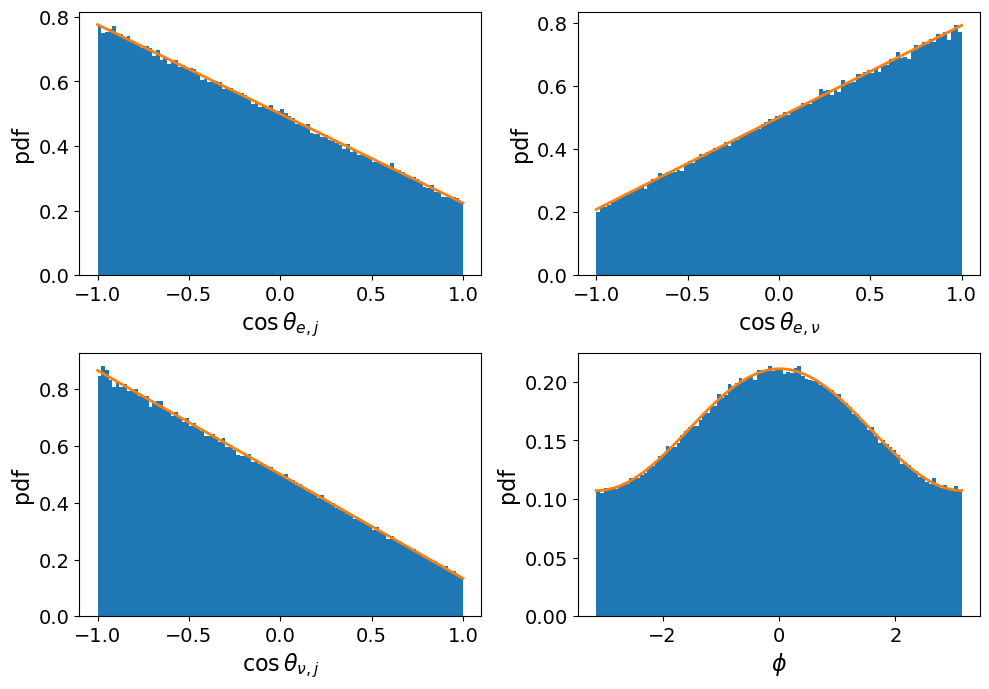

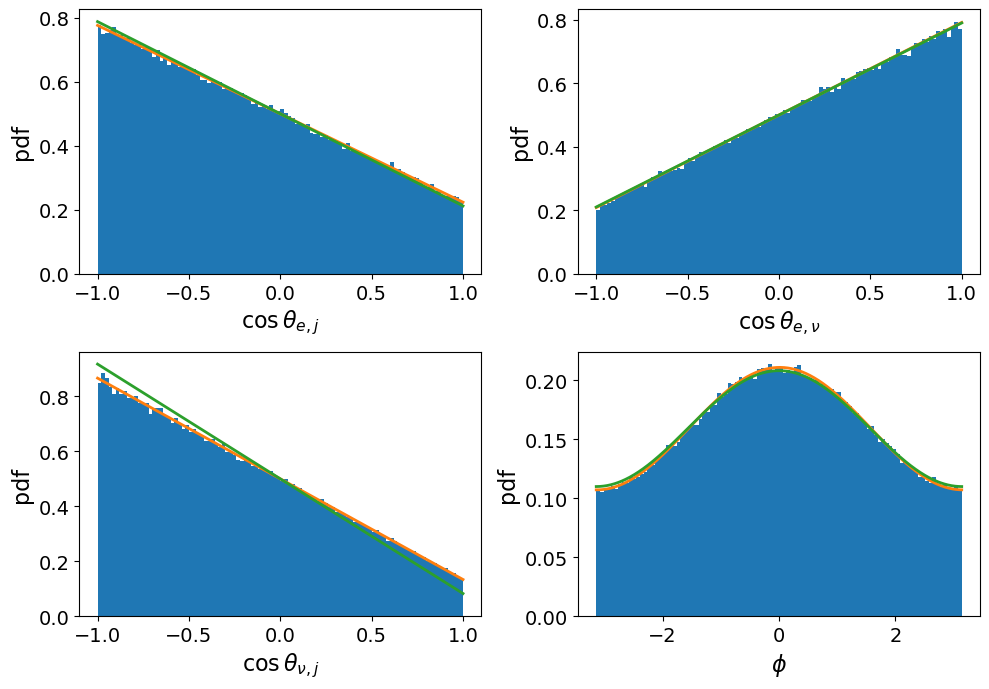

In [11]:
ct = 0.5
Q = 6524.49

a, b, c, A, B, D = ctre_coeffs(mass_e+Q/3)
print((a, b, c, A, B, D))
   
CTPRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_polZpos_ctpRe.txt")
CTPRe_39Ca_polZpos.event_mask()
CTPRe_39Ca_polZpos.kinematical_data()
CTPRe_39Ca_polZpos.kinematical_data_ref()
CTPRe_39Ca_polZpos.theoretical_dist(ctre_coeffs)
CTPRe_39Ca_polZpos.theoretical_dist2(SM_coeffs)
CTPRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100)
CTPRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,compareTheory=True,
                                                bins=100,fileName="39Ca_CTPRe_hists")

(0.5717742202919189, 0.0, -0.16431126245298042, -0.5481089459298247, -0.7675069332810309, 0.0)


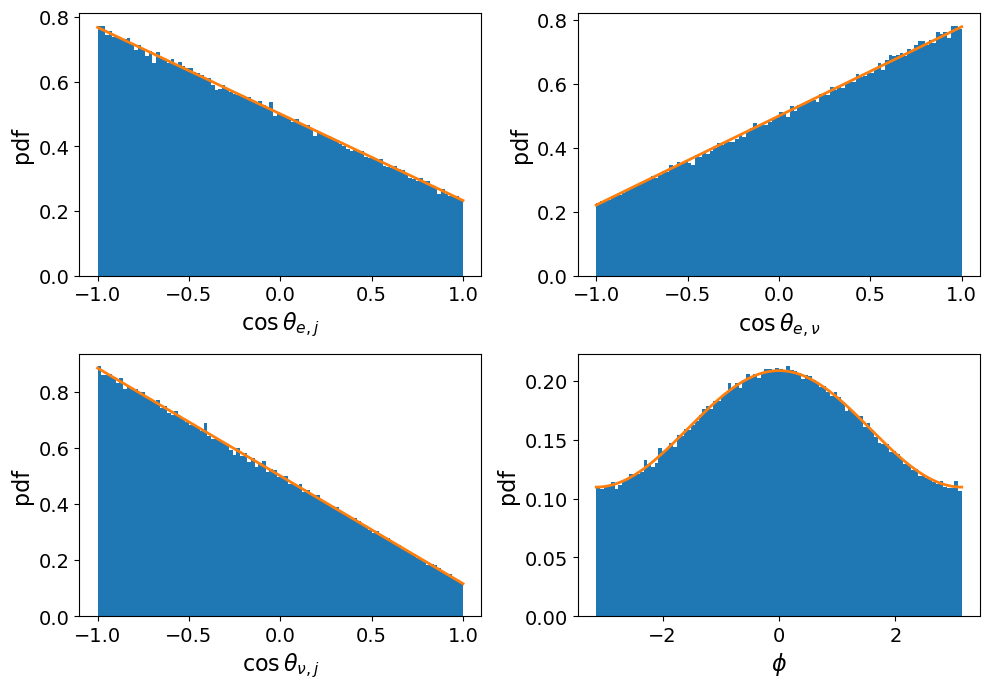

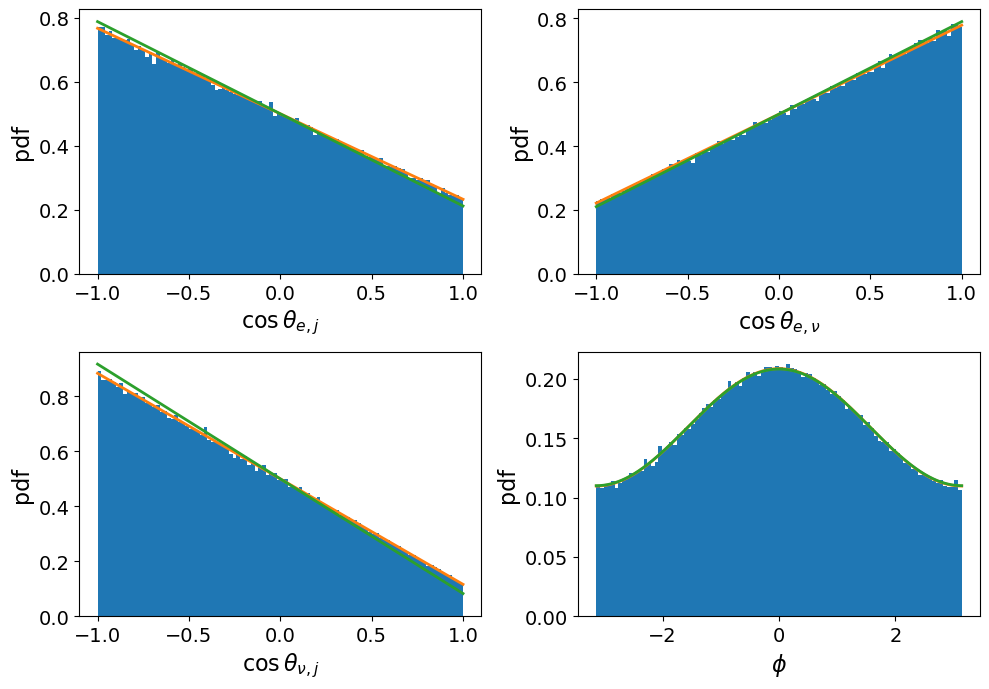

In [12]:
a, b, c, A, B, D = ctIm_coeffs(mass_e+Q/3)
print((a, b, c, A, B, D))
   
CTPIm_39Ca_polZpos = Ca39_data_analysis("build/39Ca_polZpos_ctpIm.txt")
CTPIm_39Ca_polZpos.event_mask()
CTPIm_39Ca_polZpos.kinematical_data()
CTPIm_39Ca_polZpos.kinematical_data_ref()
CTPIm_39Ca_polZpos.theoretical_dist(ctIm_coeffs)
CTPIm_39Ca_polZpos.theoretical_dist2(SM_coeffs)
CTPIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100)
CTPIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,compareTheory=True,
                                                bins=100,fileName="39Ca_CTPIm_hists")

(0.46696322455915923, -0.31702675329954366, -0.22378647831740534, -0.5437204549636255, -0.720785818930022, -0.004404074676142683)


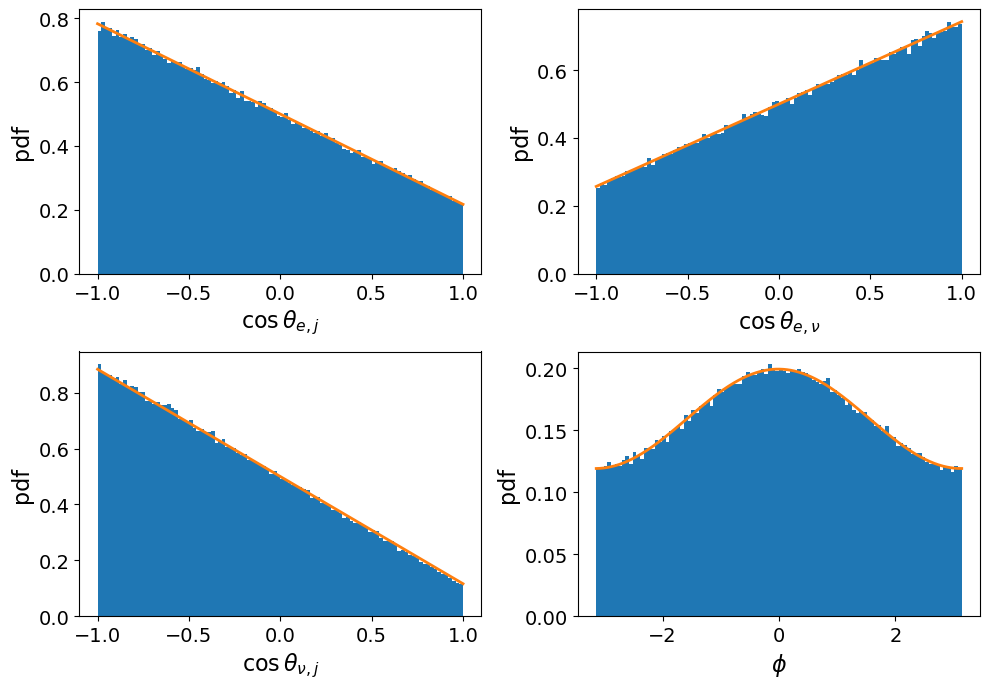

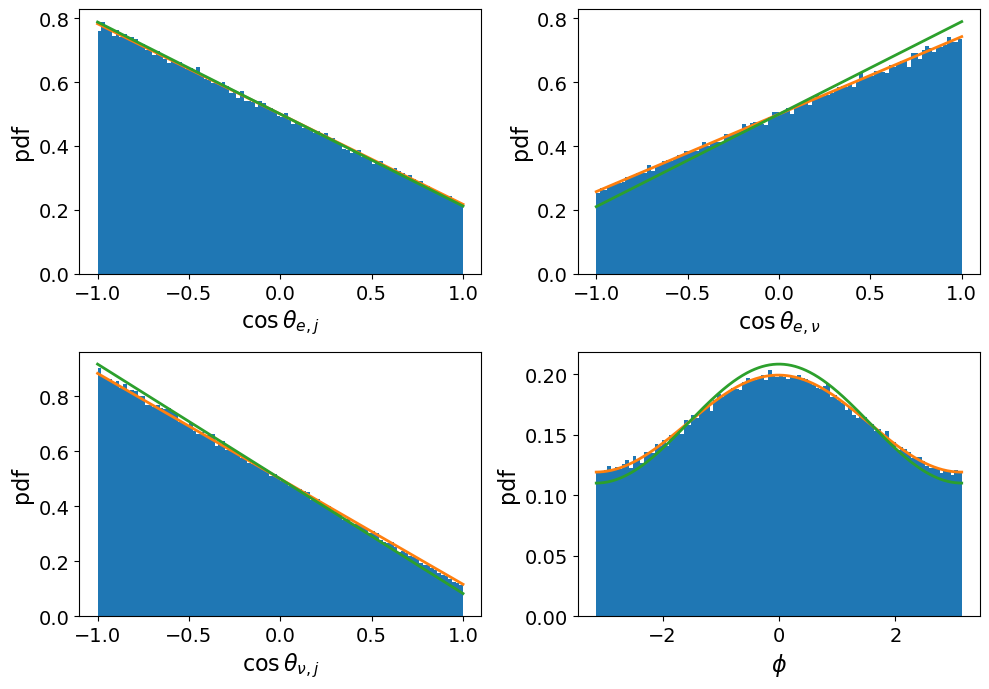

In [13]:
cs = 0.5
Q = 6524.49

def csre_coeffs(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2*(cv**2+ca**2)+cs**2
    a = 2*cv**2-cs**2+1/3*(-2*ca**2)
    b = -2*gamma*cs*cv
    c = Lambda_jj*(2*ca**2)
    A = lambda_jj*2*ca**2-np.sqrt(3/5)*4*cv*ca
    B = -lambda_jj*(2*ca**2)-np.sqrt(3/5)*(4*cv*ca-2*gamma*mass_e/E*cs*cv)
    D = -np.sqrt(3/5)*2*cs*ca*coulombCorr
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

a, b, c, A, B, D = csre_coeffs(mass_e+Q/3)
print((a, b, c, A, B, D))
   
CSRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_polZpos_csRe.txt")
CSRe_39Ca_polZpos.event_mask()
CSRe_39Ca_polZpos.kinematical_data()
CSRe_39Ca_polZpos.kinematical_data_ref()
CSRe_39Ca_polZpos.theoretical_dist(csre_coeffs)
CSRe_39Ca_polZpos.theoretical_dist2(SM_coeffs)
CSRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100)
CSRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,compareTheory=True,
                                               bins=100,fileName="39Ca_CSRe_hists")                                               

(0.4755647918189446, 0.0, -0.22378647831740534, -0.5481245296397682, -0.7675069332810309, 0.0)


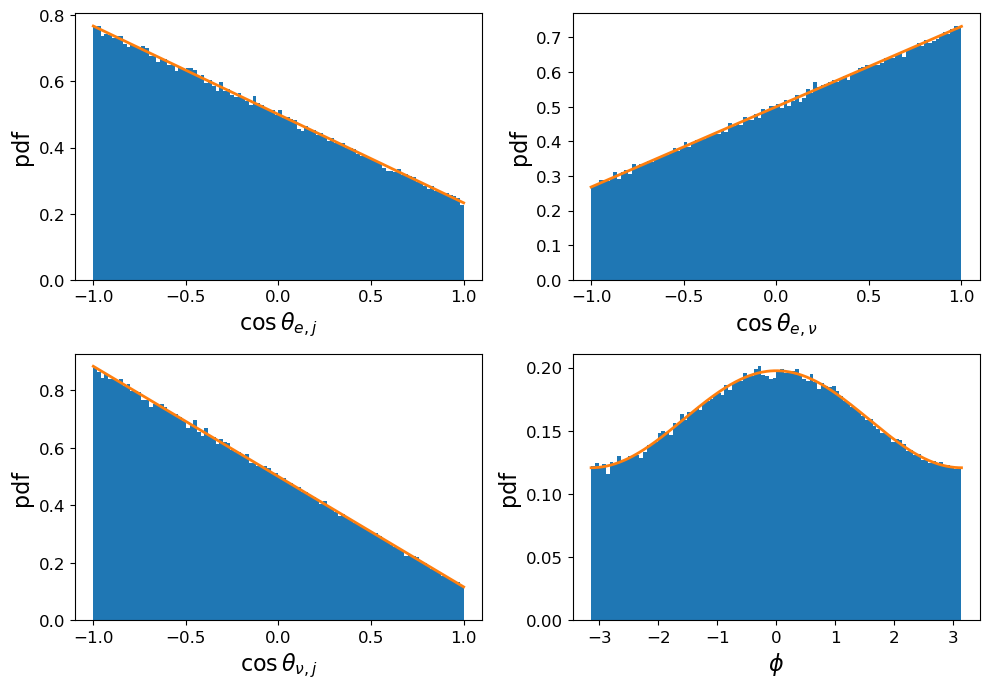

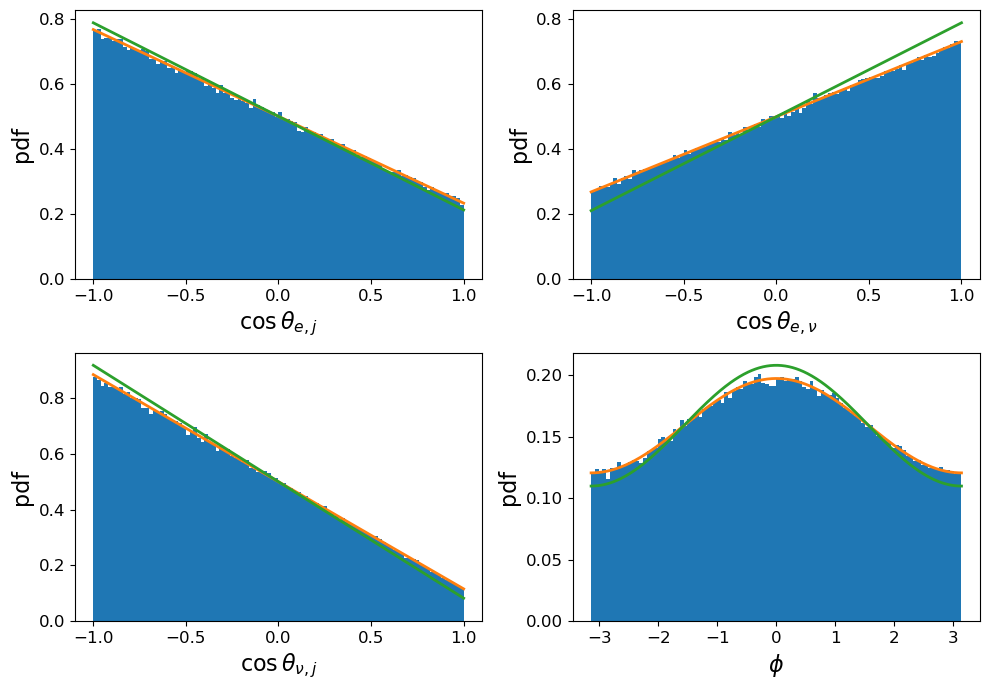

In [35]:
cs = 0.5
Q = 6524.49
Z = 19

def csIm_coeffs(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2*(cv**2+ca**2)+cs**2
    a = 2*cv**2-cs**2+2*coulombCorr*cs*cv+1/3*(-2*ca**2)
    b = 0
    c = Lambda_jj*(2*ca**2)
    A = lambda_jj*(2*ca**2)-np.sqrt(3/5)*(4*cv*ca+2*ca*cs*coulombCorr)
    B = -lambda_jj*(2*ca**2)-np.sqrt(3/5)*(4*cv*ca)
    D = 0
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

a, b, c, A, B, D = csIm_coeffs(mass_e+Q/3)
print((a, b, c, A, B, D))
   
CSIm_39Ca_polZpos = Ca39_data_analysis("build/39Ca_polZpos_csIm.txt")
CSIm_39Ca_polZpos.event_mask()
CSIm_39Ca_polZpos.kinematical_data()
CSIm_39Ca_polZpos.kinematical_data_ref()
CSIm_39Ca_polZpos.theoretical_dist(csIm_coeffs)
CSIm_39Ca_polZpos.theoretical_dist2(SM_coeffs)
CSIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100)
CSIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,compareTheory=True,
                                               bins=100,fileName="39Ca_CSIm_hists")

(0.46696322455915923, -0.31702675329954366, -0.22378647831740534, -0.5437204549636255, -0.720785818930022, -0.004404074676142683)


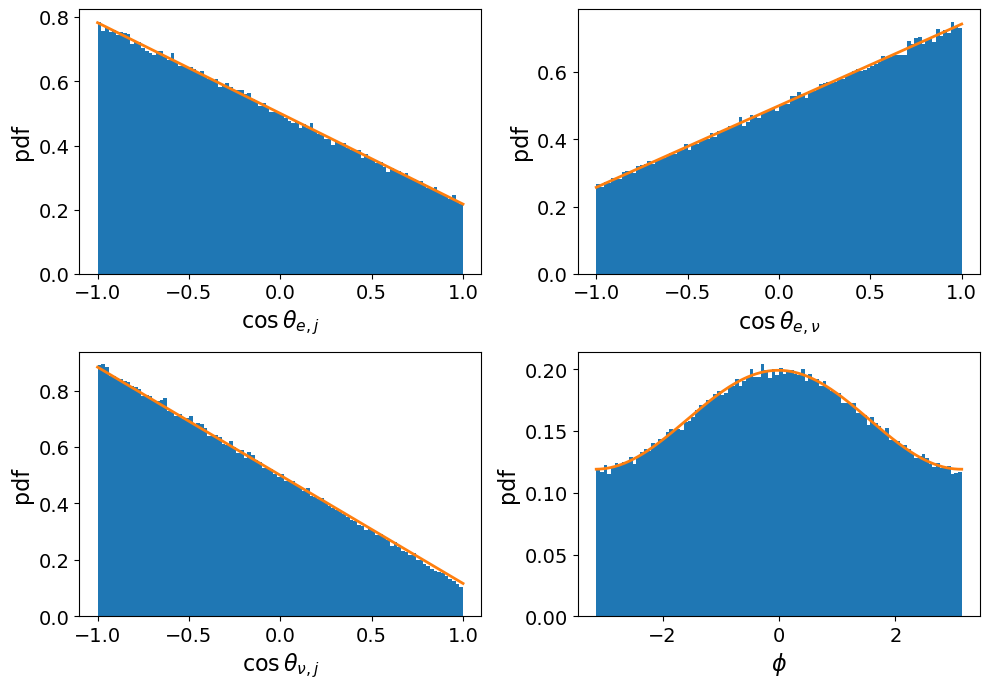

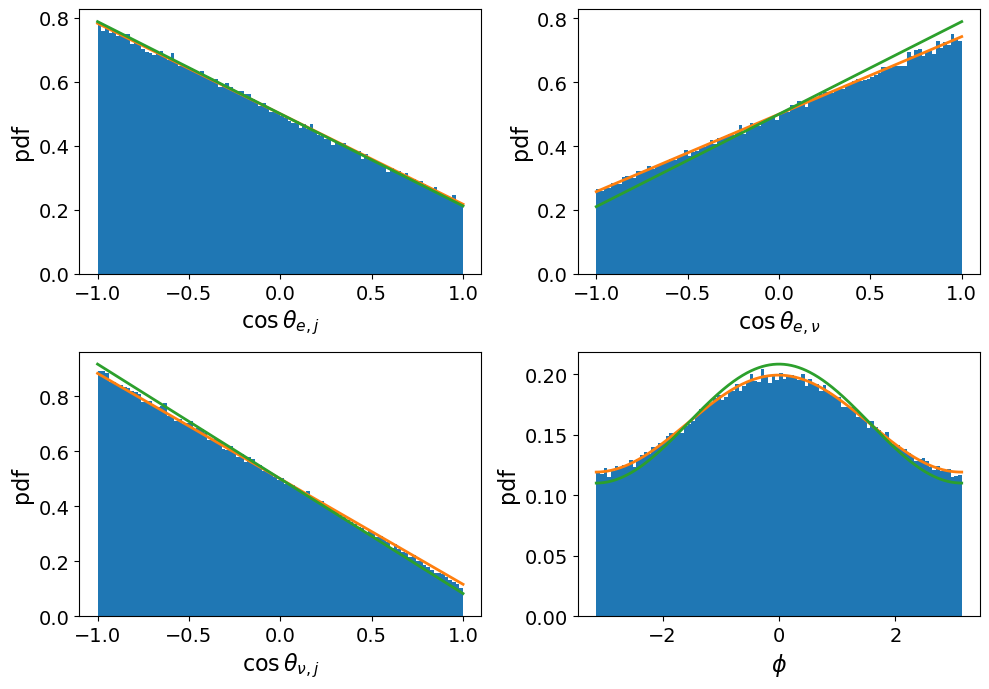

In [15]:
cs = 0.5
Q = 6524.49

a, b, c, A, B, D = csre_coeffs(mass_e+Q/3)
print((a, b, c, A, B, D))
   
CSPRe_39Ca_polZpos = Ca39_data_analysis("build/39Ca_polZpos_cspRe.txt")
CSPRe_39Ca_polZpos.event_mask()
CSPRe_39Ca_polZpos.kinematical_data()
CSPRe_39Ca_polZpos.kinematical_data_ref()
CSPRe_39Ca_polZpos.theoretical_dist(csre_coeffs)
CSPRe_39Ca_polZpos.theoretical_dist2(SM_coeffs)
CSPRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100)
CSPRe_39Ca_polZpos.plot_distribution_histograms(showTheory=True,compareTheory=True,
                                               bins=100,fileName="39Ca_CSPRe_hists")                                               

(0.4755647918189446, 0.0, -0.22378647831740534, -0.5458502752562809, -0.7675069332810309, 0.0)


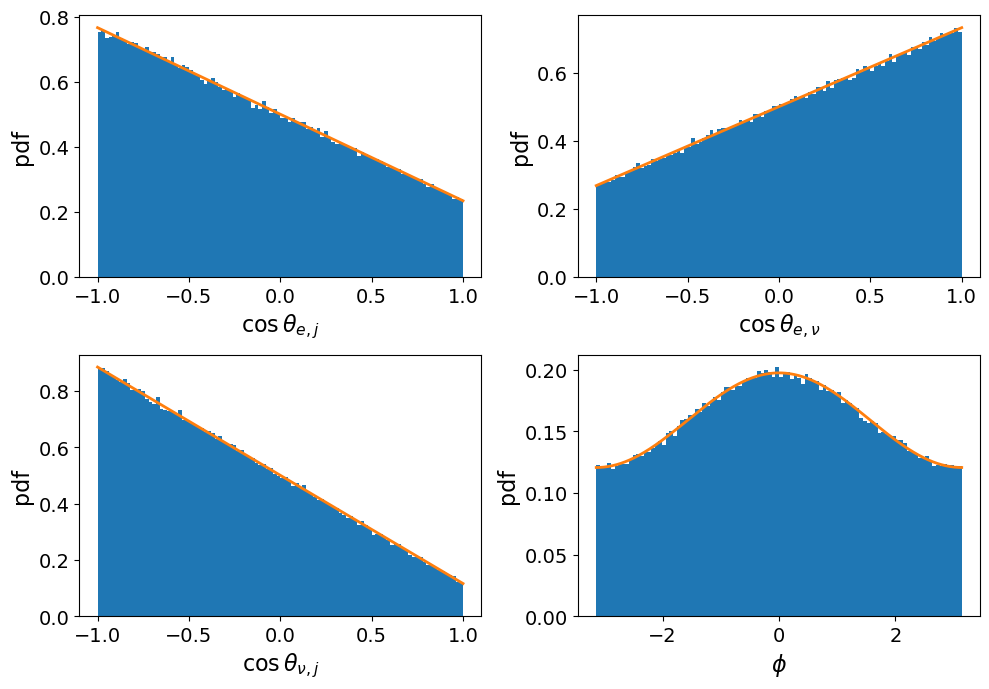

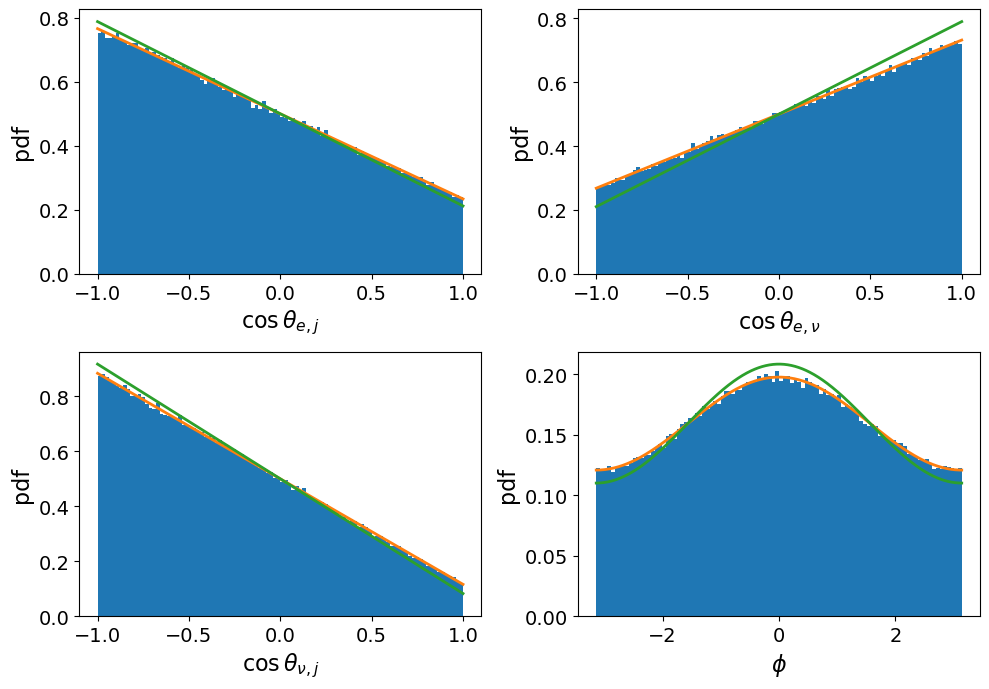

In [16]:
cs = 0.5
Q = 6524.49
Z = 19

a, b, c, A, B, D = csIm_coeffs(mass_e+Q/3)
print((a, b, c, A, B, D))
   
CSPIm_39Ca_polZpos = Ca39_data_analysis("build/39Ca_polZpos_cspIm.txt")
CSPIm_39Ca_polZpos.event_mask()
CSPIm_39Ca_polZpos.kinematical_data()
CSPIm_39Ca_polZpos.kinematical_data_ref()
CSPIm_39Ca_polZpos.theoretical_dist(csIm_coeffs)
CSPIm_39Ca_polZpos.theoretical_dist2(SM_coeffs)
CSPIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100)
CSPIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,compareTheory=True,bins=100)

(0.45530653891472944, -0.29353522988947117, -0.15213588031794117, -0.5074943479485156, -0.6673759512680196, -0.11887218431248783)


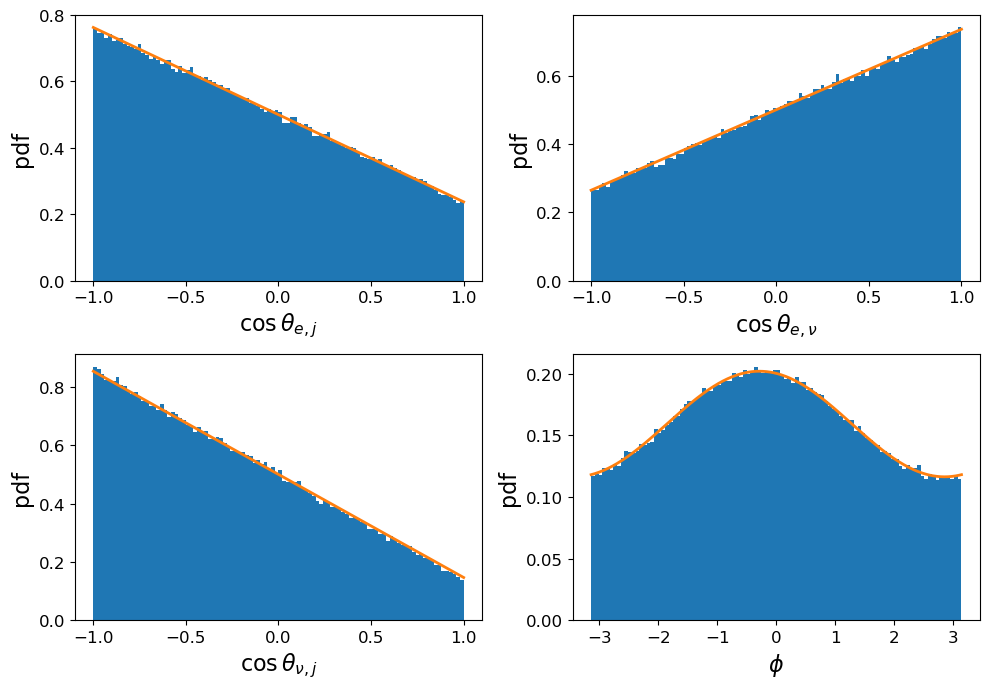

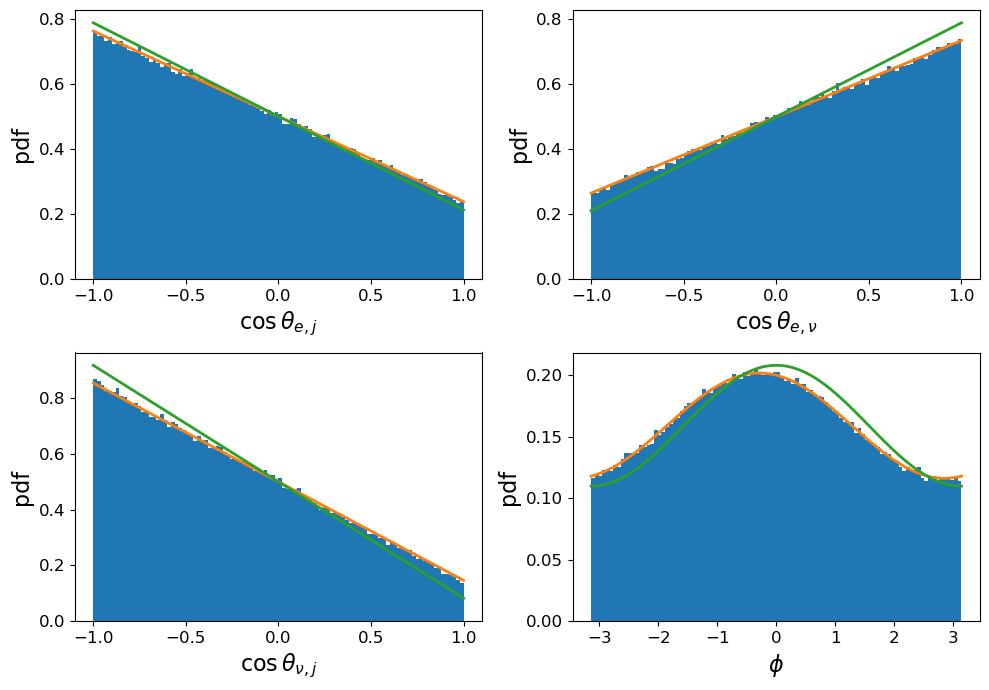

In [41]:
ct = 0.5
cs = 0.5

def csctIm_coeffs(E):
    coulombCorr = alpha*Z/np.sqrt(E**2/mass_e**2-1)
    xi = 2*(cv**2+ca**2)+ct**2+cs**2
    a = 2*cv**2-cs**2+1/3*(ct**2-2*ca**2-2*ct*ca*coulombCorr)
    b = -2*gamma*cs*cv
    c = Lambda_jj*(2*ca**2-ct**2+2*ct*ca*coulombCorr)
    A = lambda_jj*(2*ca**2+2*ca*ct*coulombCorr)-np.sqrt(3/5)*(4*cv*ca+2*cv*ct*coulombCorr)
    B = -lambda_jj*(2*ca**2)-np.sqrt(3/5)*(4*cv*ca-2*gamma*mass_e/E*cs*cv)
    D = -np.sqrt(3/5)*(2*cs*ca*coulombCorr+2*cs*ct)
    return (a/xi, b/xi, c/xi, A/xi, B/xi, D/xi)

a, b, c, A, B, D = csctIm_coeffs(mass_e+Q/3)
print((a, b, c, A, B, D))

CSCTIm_39Ca_polZpos = Ca39_data_analysis("build/39Ca_polZpos_cscstIm.txt")
CSCTIm_39Ca_polZpos.event_mask()
CSCTIm_39Ca_polZpos.kinematical_data()
CSCTIm_39Ca_polZpos.kinematical_data_ref()
CSCTIm_39Ca_polZpos.theoretical_dist(csctIm_coeffs)
CSCTIm_39Ca_polZpos.theoretical_dist2(SM_coeffs)
CSCTIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,bins=100)
CSCTIm_39Ca_polZpos.plot_distribution_histograms(showTheory=True,compareTheory=True,
                                               bins=100,fileName="39Ca_csctIm_hists")                                               